In [3]:
import os
import pandas as pd
import altair as alt
# Set Path
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

In [8]:

# Commit and Push to Github
os.chdir(path_wd)
!git init
!git config --global user.email "veexu@ctcultures.com"
!git config --global user.name "Herais"
!git add --all


#!git commit
#!git push

Reinitialized existing Git repository in /content/drive/MyDrive/Github/Content/.git/


In [ ]:
!pip install -r requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [4]:
!#Load Libraries
import gc
import pandas as pd
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: use options instead of chrome_options
  # This is added back by InteractiveShellApp.init_path()


In [12]:
# For obtaining data from the net
from bs4 import BeautifulSoup
import re

url = 'https://m.hx168.com.cn/stock/concept/BK2505.html'
driver.get(url)
driver.implicitly_wait(2)
html = driver.page_source

tables = pd.read_html(html)

XXXX年XX月XX日，最新的备案公示新鲜出炉！
这一批次中，最遥远的项目是XXX, 最近期的项目是XXX，预计处理的大部分备案是在XXX至XXX期间完成提交。

In [105]:
#df1['公示日期'] = df1['公示日期'].astype('datetime64')
df1.iloc[:1]['公示批次起始']
df1['公示批次起始']

txt = ''
txt += str(df1[:1]['公示日期'].dt.date.iloc[0].year) + '年' + str(df1[:1]['公示日期'].dt.date.iloc[0].month) + '月' \
 + str(df1[:1]['公示日期'].dt.date.iloc[0].day) + '日，'
txt += '最新的备案公示新鲜出炉！ 这一批次中，最遥远的项目是'
txt += '《' + record_earliest['片名'].iloc[0] + '》,'
txt += '备案号为' + record_earliest['备案立项号'].iloc[0] + ','
txt += '最近期的项目是' + '《' + record_latest['片名'].iloc[0] + '》,'
txt += '备案号为' + record_latest['备案立项号'].iloc[0] + '。'

print(txt)

2020年11月3日，最新的备案公示新鲜出炉！ 这一批次中，最遥远的项目是《终极心跳》,备案号为影剧备字[2017]第3452号,最近期的项目是《扣杀》,备案号为影剧备字[2020]第7310号。


In [101]:
record_earliest['备案立项号'].iloc[0]

'影剧备字[2017]第3452号'

备案中，国家电影局直备的有XX部，各地备案量排名前三的分别是XXX、XXX、XXX。
补备案的共有两部，先拍片、再备案属于高风险行为，切记慎之又慎。

AttributeError: ignored

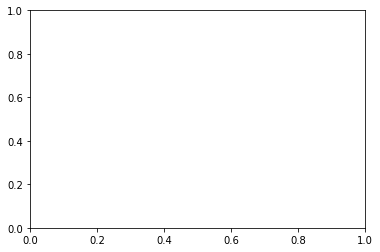

In [116]:
df1_location_count = df1_curr_issue.groupby('备案地')['备案地'].count().sort_values(ascending=False)
# pie chart

In [120]:
chart = alt.Chart(df1_location_count)
chart

/usr/local/lib/python3.7/dist-packages/altair/vegalite/v4/api.py:96: UserWarning: data of type <class 'pandas.core.series.Series'> not recognized
  warnings.warn("data of type {} not recognized".format(type(data)))


SchemaValidationError: ignored

alt.Chart(...)

In [ ]:
pd.{
"全国": [116.413384, 39.910925],
"北京市": [116.413384, 39.910925],
"北京市-市辖区": [116.413384, 39.910925],
"北京市-市辖区-东城区": [116.422401, 39.934827],
"北京市-市辖区-西城区": [116.372514, 39.918124],
"北京市-市辖区-朝阳区": [116.449559, 39.926375],
"北京市-市辖区-丰台区": [116.292402, 39.864937],
"北京市-市辖区-石景山区": [116.229613, 39.911354],
"北京市-市辖区-海淀区": [116.305434, 39.96549],
"北京市-市辖区-门头沟区": [116.107604, 39.946147],
"北京市-市辖区-房山区": [116.149444, 39.754326],
"北京市-市辖区-通州区": [116.663415, 39.916017],
"北京市-市辖区-顺义区": [116.661424, 40.136351],
"北京市-市辖区-昌平区": [116.237618, 40.226413],
"北京市-市辖区-大兴区": [116.348625, 39.732555],
"北京市-市辖区-怀柔区": [116.638386, 40.322618],
"北京市-市辖区-平谷区": [117.127379, 40.146951],
"北京市-市辖区-密云区": [116.849547, 40.382176],
"北京市-市辖区-延庆区": [115.981632, 40.462169],
"天津市": [117.209523, 39.093668],
"天津市-市辖区": [117.209523, 39.093668],
"天津市-市辖区-和平区": [117.221467, 39.12339],
"天津市-市辖区-河东区": [117.258413, 39.134487],
"天津市-市辖区-河西区": [117.229416, 39.115718],
"天津市-市辖区-南开区": [117.156515, 39.144105],
"天津市-市辖区-河北区": [117.203593, 39.153485],
"天津市-市辖区-红桥区": [117.157518, 39.173286],
"天津市-市辖区-东丽区": [117.320569, 39.092332],
"天津市-市辖区-西青区": [117.01441, 39.148727],
"天津市-市辖区-津南区": [117.363387, 38.944148],
"天津市-市辖区-北辰区": [117.141403, 39.230344],
"天津市-市辖区-武清区": [117.050597, 39.389871],
"天津市-市辖区-宝坻区": [117.316601, 39.723194],
"天津市-市辖区-滨海新区": [117.717399, 39.009416],
"天津市-市辖区-宁河区": [117.832393, 39.336956],
"天津市-市辖区-静海区": [116.980469, 38.953371],
"天津市-市辖区-蓟州区": [117.414579, 40.051509],
"河北省": [114.536596, 38.043202],
"河北省-石家庄市": [114.521532, 38.048312],
"河北省-石家庄市-长安区": [114.545612, 38.043256],
"河北省-石家庄市-桥西区": [114.46742, 38.010381],
"河北省-石家庄市-新华区": [114.469438, 38.05712],
"河北省-石家庄市-井陉矿区": [114.068632, 38.070566],
"河北省-石家庄市-裕华区": [114.537583, 38.012088],
"河北省-石家庄市-藁城区": [114.853378, 38.027817],
"河北省-石家庄市-鹿泉区": [114.320598, 38.091749],
"河北省-石家庄市-栾城区": [114.654576, 37.905816],
"河北省-石家庄市-井陉县": [114.151463, 38.038386],
"河北省-石家庄市-正定县": [114.577481, 38.151714],
"河北省-石家庄市-行唐县": [114.559607, 38.444239],
"河北省-石家庄市-灵寿县": [114.389478, 38.314629],
"河北省-石家庄市-高邑县": [114.618413, 37.62188],
"河北省-石家庄市-深泽县": [115.207404, 38.190451],
"河北省-石家庄市-赞皇县": [114.392464, 37.671667],
"河北省-石家庄市-无极县": [114.982439, 38.185436],
"河北省-石家庄市-平山县": [113.985435, 38.271951],
"河北省-石家庄市-元氏县": [114.532566, 37.772339],
"河北省-石家庄市-赵县": [114.782597, 37.761859],
"河北省-石家庄市-晋州市": [115.050529, 38.039491],
"河北省-石家庄市-新乐市": [114.690532, 38.349293],
"河北省-唐山市": [118.186459, 39.636584],
"河北省-唐山市-路南区": [118.160607, 39.631043],
"河北省-唐山市-路北区": [118.206399, 39.630661],
"河北省-唐山市-古冶区": [118.453401, 39.739736],
"河北省-唐山市-开平区": [118.268608, 39.677144],
"河北省-唐山市-丰南区": [118.090366, 39.58154],
"河北省-唐山市-丰润区": [118.168541, 39.838353],
"河北省-唐山市-曹妃甸区": [118.46646, 39.279284],
"河北省-唐山市-滦县": [118.71048, 39.747116],
"河北省-唐山市-滦南县": [118.680405, 39.510045],
"河北省-唐山市-乐亭县": [118.919384, 39.431931],
"河北省-唐山市-迁西县": [118.320384, 40.147837],
"河北省-唐山市-玉田县": [117.745434, 39.906592],
"河北省-唐山市-遵化市": [117.972375, 40.195533],
"河北省-唐山市-迁安市": [118.706457, 40.004184],
"河北省-秦皇岛市": [119.608531, 39.941748],
"河北省-秦皇岛市-海港区": [119.617475, 39.940413],
"河北省-秦皇岛市-山海关区": [119.782435, 39.984446],
"河北省-秦皇岛市-北戴河区": [119.491526, 39.841006],
"河北省-秦皇岛市-抚宁区": [119.251549, 39.881414],
"河北省-秦皇岛市-青龙满族自治县": [118.956481, 40.412794],
"河北省-秦皇岛市-昌黎县": [119.169375, 39.719051],
"河北省-秦皇岛市-卢龙县": [118.899489, 39.897958],
"河北省-邯郸市": [114.545628, 36.631263],
"河北省-邯郸市-邯山区": [114.496389, 36.586692],
"河北省-邯郸市-丛台区": [114.499433, 36.642673],
"河北省-邯郸市-复兴区": [114.479412, 36.623325],
"河北省-邯郸市-峰峰矿区": [114.219483, 36.425654],
"河北省-邯郸市-邯郸县": [114.537309, 36.599675],
"河北省-邯郸市-临漳县": [114.626427, 36.340766],
"河北省-邯郸市-成安县": [114.676577, 36.449796],
"河北省-邯郸市-大名县": [115.154613, 36.291288],
"河北省-邯郸市-涉县": [113.697584, 36.590692],
"河北省-邯郸市-磁县": [114.380432, 36.380359],
"河北省-邯郸市-肥乡县": [114.806547, 36.553825],
"河北省-邯郸市-永年县": [114.550625, 36.747569],
"河北省-邯郸市-邱县": [115.193395, 36.817362],
"河北省-邯郸市-鸡泽县": [114.896586, 36.916398],
"河北省-邯郸市-广平县": [114.954415, 36.48978],
"河北省-邯郸市-馆陶县": [115.288537, 36.553957],
"河北省-邯郸市-魏县": [114.94545, 36.366156],
"河北省-邯郸市-曲周县": [114.963404, 36.771545],
"河北省-邯郸市-武安市": [114.210516, 36.702488],
"河北省-邢台市": [114.511462, 37.076686],
"河北省-邢台市-桥东区": [114.513471, 37.07375],
"河北省-邢台市-桥西区": [114.474393, 37.066172],
"河北省-邢台市-邢台县": [114.143411, 37.177109],
"河北省-邢台市-临城县": [114.505443, 37.450789],
"河北省-邢台市-内丘县": [114.518493, 37.292858],
"河北省-邢台市-柏乡县": [114.699497, 37.488759],
"河北省-邢台市-隆尧县": [114.776616, 37.355908],
"河北省-邢台市-任县": [114.678606, 37.126727],
"河北省-邢台市-南和县": [114.690548, 37.010998],
"河北省-邢台市-宁晋县": [114.925562, 37.625612],
"河北省-邢台市-巨鹿县": [115.043587, 37.227088],
"河北省-邢台市-新河县": [115.248547, 37.534591],
"河北省-邢台市-广宗县": [115.149605, 37.080457],
"河北省-邢台市-平乡县": [115.036582, 37.069096],
"河北省-邢台市-威县": [115.273618, 36.981582],
"河北省-邢台市-清河县": [115.674394, 37.046375],
"河北省-邢台市-临西县": [115.507629, 36.87676],
"河北省-邢台市-南宫市": [115.414529, 37.364069],
"河北省-邢台市-沙河市": [114.509474, 36.861127],
"河北省-保定市": [115.471464, 38.879988],
"河北省-保定市-竞秀区": [115.465434, 38.883788],
"河北省-保定市-莲池区": [115.535488, 38.860676],
"河北省-保定市-满城区": [115.328375, 38.955441],
"河北省-保定市-清苑区": [115.496606, 38.771002],
"河北省-保定市-徐水区": [115.66248, 39.024713],
"河北省-保定市-涞水县": [115.720543, 39.400334],
"河北省-保定市-阜平县": [114.201563, 38.855351],
"河北省-保定市-定兴县": [115.81441, 39.269424],
"河北省-保定市-唐县": [114.989447, 38.75402],
"河北省-保定市-高阳县": [115.785447, 38.706258],
"河北省-保定市-容城县": [115.868631, 39.048559],
"河北省-保定市-涞源县": [114.700476, 39.366272],
"河北省-保定市-望都县": [115.161588, 38.700158],
"河北省-保定市-安新县": [115.942426, 38.941734],
"河北省-保定市-易县": [115.503607, 39.355054],
"河北省-保定市-曲阳县": [114.751455, 38.628384],
"河北省-保定市-蠡县": [115.590445, 38.494201],
"河北省-保定市-顺平县": [115.141597, 38.843261],
"河北省-保定市-博野县": [115.470467, 38.463408],
"河北省-保定市-雄县": [116.114601, 39.00018],
"河北省-保定市-涿州市": [115.98162, 39.491066],
"河北省-保定市-安国市": [115.333408, 38.424828],
"河北省-保定市-高碑店市": [115.880569, 39.332335],
"河北省-张家口市": [114.892572, 40.773237],
"河北省-张家口市-桥东区": [114.900606, 40.794268],
"河北省-张家口市-桥西区": [114.876516, 40.825606],
"河北省-张家口市-宣化区": [115.105444, 40.614592],
"河北省-张家口市-下花园区": [115.293517, 40.508145],
"河北省-张家口市-万全区": [114.747426, 40.77315],
"河北省-张家口市-崇礼区": [115.289549, 40.980478],
"河北省-张家口市-张北县": [114.726375, 41.164944],
"河北省-张家口市-康保县": [114.606356, 41.858637],
"河北省-张家口市-沽源县": [115.695407, 41.676016],
"河北省-张家口市-尚义县": [113.975524, 41.081888],
"河北省-张家口市-蔚县": [114.595401, 39.847089],
"河北省-张家口市-阳原县": [114.157524, 40.109588],
"河北省-张家口市-怀安县": [114.392469, 40.680369],
"河北省-张家口市-怀来县": [115.524553, 40.42029],
"河北省-张家口市-涿鹿县": [115.211383, 40.385834],
"河北省-张家口市-赤城县": [115.838506, 40.918761],
"河北省-承德市": [117.969398, 40.957856],
"河北省-承德市-双桥区": [117.949428, 40.980824],
"河北省-承德市-双滦区": [117.806578, 40.964729],
"河北省-承德市-鹰手营子矿区": [117.665609, 40.552043],
"河北省-承德市-承德县": [118.180456, 40.774367],
"河北省-承德市-兴隆县": [117.507427, 40.423454],
"河北省-承德市-平泉县": [118.707427, 41.023756],
"河北省-承德市-滦平县": [117.339498, 40.947561],
"河北省-承德市-隆化县": [117.745451, 41.319899],
"河北省-承德市-丰宁满族自治县": [116.652393, 41.215336],
"河北省-承德市-宽城满族自治县": [118.491594, 40.617152],
"河北省-承德市-围场满族蒙古族自治县": [117.766564, 41.944324],
"河北省-沧州市": [116.845581, 38.310215],
"河北省-沧州市-新华区": [116.872433, 38.320367],
"河北省-沧州市-运河区": [116.838612, 38.316523],
"河北省-沧州市-沧县": [116.884398, 38.299453],
"河北省-沧州市-青县": [116.810575, 38.588465],
"河北省-沧州市-东光县": [116.54341, 37.894514],
"河北省-沧州市-海兴县": [117.504418, 38.149402],
"河北省-沧州市-盐山县": [117.237414, 38.064318],
"河北省-沧州市-肃宁县": [115.836518, 38.428906],
"河北省-沧州市-南皮县": [116.715601, 38.045188],
"河北省-沧州市-吴桥县": [116.397392, 37.633909],
"河北省-沧州市-献县": [116.12956, 38.195981],
"河北省-沧州市-孟村回族自治县": [117.110436, 38.059839],
"河北省-沧州市-泊头市": [116.584628, 38.089257],
"河北省-沧州市-任丘市": [116.105605, 38.717349],
"河北省-沧州市-黄骅市": [117.336481, 38.377494],
"河北省-沧州市-河间市": [116.105628, 38.451357],
"河北省-廊坊市": [116.690582, 39.543367],
"河北省-廊坊市-安次区": [116.709633, 39.52616],
"河北省-廊坊市-广阳区": [116.717614, 39.528611],
"河北省-廊坊市-固安县": [116.30542, 39.444485],
"河北省-廊坊市-永清县": [116.505429, 39.327853],
"河北省-廊坊市-香河县": [117.012402, 39.767939],
"河北省-廊坊市-大城县": [116.660409, 38.710859],
"河北省-廊坊市-文安县": [116.464609, 38.87895],
"河北省-廊坊市-大厂回族自治县": [116.996409, 39.892208],
"河北省-廊坊市-霸州市": [116.398397, 39.130921],
"河北省-廊坊市-三河市": [117.084588, 39.9881],
"河北省-衡水市": [115.675406, 37.745191],
"河北省-衡水市-桃城区": [115.681395, 37.741637],
"河北省-衡水市-冀州区": [115.58543, 37.557086],
"河北省-衡水市-枣强县": [115.730563, 37.519364],
"河北省-衡水市-武邑县": [115.894514, 37.807764],
"河北省-衡水市-武强县": [115.989614, 38.046857],
"河北省-衡水市-饶阳县": [115.732572, 38.241038],
"河北省-衡水市-安平县": [115.525549, 38.240507],
"河北省-衡水市-故城县": [115.972602, 37.353348],
"河北省-衡水市-景县": [116.277411, 37.698815],
"河北省-衡水市-阜城县": [116.182422, 37.868732],
"河北省-衡水市-深州市": [115.566369, 38.006941],
"河北省-定州市": [114.996496, 38.522199],
"河北省-辛集市": [115.224451, 37.949309],
"山西省": [112.569376, 37.879829],
"山西省-太原市": [112.556391, 37.876989],
"山西省-太原市-小店区": [112.572396, 37.742323],
"山西省-太原市-迎泽区": [112.569385, 37.869532],
"山西省-太原市-杏花岭区": [112.576383, 37.900186],
"山西省-太原市-尖草坪区": [112.493605, 37.945943],
"山西省-太原市-万柏林区": [112.522577, 37.864974],
"山西省-太原市-晋源区": [112.484564, 37.721169],
"山西省-太原市-清徐县": [112.364558, 37.613067],
"山西省-太原市-阳曲县": [112.679409, 38.064621],
"山西省-太原市-娄烦县": [111.803591, 38.073195],
"山西省-太原市-古交市": [112.182453, 37.913],
"山西省-大同市": [113.306436, 40.082469],
"山西省-大同市-城区": [113.304425, 40.081998],
"山西省-大同市-矿区": [113.162402, 39.996839],
"山西省-大同市-南郊区": [113.162402, 39.996839],
"山西省-大同市-新荣区": [113.146444, 40.261971],
"山西省-大同市-阳高县": [113.755414, 40.367392],
"山西省-大同市-天镇县": [114.097478, 40.426412],
"山西省-大同市-广灵县": [114.288586, 39.766004],
"山西省-大同市-灵丘县": [114.241368, 39.448825],
"山西省-大同市-浑源县": [113.7056, 39.698953],
"山西省-大同市-左云县": [112.709463, 40.019623],
"山西省-大同市-大同县": [113.618471, 40.04623],
"山西省-阳泉市": [113.587617, 37.862361],
"山西省-阳泉市-城区": [113.606568, 37.853433],
"山西省-阳泉市-矿区": [113.561521, 37.874409],
"山西省-阳泉市-郊区": [113.600603, 37.950353],
"山西省-阳泉市-平定县": [113.664421, 37.792796],
"山西省-阳泉市-盂县": [113.41842, 38.09198],
"山西省-长治市": [113.122559, 36.201268],
"山西省-长治市-城区": [113.129521, 36.209472],
"山西省-长治市-郊区": [113.105622, 36.261066],
"山西省-长治市-长治县": [113.057416, 36.059286],
"山西省-长治市-襄垣县": [113.057413, 36.541686],
"山西省-长治市-屯留县": [112.898475, 36.321631],
"山西省-长治市-平顺县": [113.442517, 36.205989],
"山西省-长治市-黎城县": [113.393432, 36.50867],
"山西省-长治市-壶关县": [113.21358, 36.121335],
"山西省-长治市-长子县": [112.884566, 36.128002],
"山西省-长治市-武乡县": [112.870606, 36.843168],
"山西省-长治市-沁县": [112.705458, 36.76219],
"山西省-长治市-沁源县": [112.344452, 36.506103],
"山西省-长治市-潞城市": [113.235578, 36.339691],
"山西省-晋城市": [112.858578, 35.496285],
"山西省-晋城市-城区": [112.855303, 35.520559],
"山西省-晋城市-沁水县": [112.193426, 35.696364],
"山西省-晋城市-阳城县": [112.421454, 35.492181],
"山西省-晋城市-陵川县": [113.287407, 35.781744],
"山西省-晋城市-泽州县": [112.794401, 35.59977],
"山西省-晋城市-高平市": [112.930412, 35.804337],
"山西省-朔州市": [112.439371, 39.337108],
"山西省-朔州市-朔城区": [112.438376, 39.325303],
"山西省-朔州市-平鲁区": [112.295525, 39.517389],
"山西省-朔州市-山阴县": [112.822432, 39.53403],
"山西省-朔州市-应县": [113.197494, 39.560078],
"山西省-朔州市-右玉县": [112.4735, 39.99486],
"山西省-朔州市-怀仁县": [113.106608, 39.833757],
"山西省-晋中市": [112.759595, 37.692839],
"山西省-晋中市-榆次区": [112.714504, 37.70394],
"山西省-晋中市-榆社县": [112.981599, 37.07637],
"山西省-晋中市-左权县": [113.385452, 37.088555],
"山西省-晋中市-和顺县": [113.576606, 37.334808],
"山西省-晋中市-昔阳县": [113.713613, 37.617884],
"山西省-晋中市-寿阳县": [113.18341, 37.901308],
"山西省-晋中市-太谷县": [112.557384, 37.427396],
"山西省-晋中市-祁县": [112.342442, 37.364131],
"山西省-晋中市-平遥县": [112.182456, 37.195601],
"山西省-晋中市-灵石县": [111.785618, 36.853368],
"山西省-晋中市-介休市": [111.923563, 37.032686],
"山西省-运城市": [111.013389, 35.032707],
"山西省-运城市-盐湖区": [111.004377, 35.021425],
"山西省-运城市-临猗县": [110.780407, 35.149542],
"山西省-运城市-万荣县": [110.844576, 35.421109],
"山西省-运城市-闻喜县": [111.23141, 35.362931],
"山西省-运城市-稷山县": [110.989415, 35.610403],
"山西省-运城市-新绛县": [111.231406, 35.62263],
"山西省-运城市-绛县": [111.575487, 35.497276],
"山西省-运城市-垣曲县": [111.676607, 35.303015],
"山西省-运城市-夏县": [111.226431, 35.147462],
"山西省-运城市-平陆县": [111.22348, 34.842925],
"山西省-运城市-芮城县": [110.700612, 34.699388],
"山西省-运城市-永济市": [110.454578, 34.87283],
"山西省-运城市-河津市": [110.718572, 35.601927],
"山西省-忻州市": [112.740624, 38.422383],
"山西省-忻州市-忻府区": [112.752614, 38.40988],
"山西省-忻州市-定襄县": [112.963529, 38.479974],
"山西省-忻州市-五台县": [113.261451, 38.734182],
"山西省-忻州市-代县": [112.966552, 39.072728],
"山西省-忻州市-繁峙县": [113.271408, 39.195237],
"山西省-忻州市-宁武县": [112.326398, 39.024342],
"山西省-忻州市-静乐县": [111.945432, 38.365147],
"山西省-忻州市-神池县": [112.217383, 39.096876],
"山西省-忻州市-五寨县": [111.85341, 38.91702],
"山西省-忻州市-岢岚县": [111.579478, 38.710151],
"山西省-忻州市-河曲县": [111.144449, 39.390702],
"山西省-忻州市-保德县": [111.092542, 39.028337],
"山西省-忻州市-偏关县": [111.514474, 39.44223],
"山西省-忻州市-原平市": [112.717487, 38.736476],
"山西省-临汾市": [111.52553, 36.093742],
"山西省-临汾市-尧都区": [111.58643, 36.084562],
"山西省-临汾市-曲沃县": [111.482396, 35.647327],
"山西省-临汾市-翼城县": [111.725376, 35.744429],
"山西省-临汾市-襄汾县": [111.44854, 35.882063],
"山西省-临汾市-洪洞县": [111.681589, 36.259467],
"山西省-临汾市-古县": [111.926573, 36.272338],
"山西省-临汾市-安泽县": [112.256613, 36.153514],
"山西省-临汾市-浮山县": [111.855385, 35.974393],
"山西省-临汾市-吉县": [110.688546, 36.103999],
"山西省-临汾市-乡宁县": [110.853498, 35.976442],
"山西省-临汾市-大宁县": [110.759384, 36.471306],
"山西省-临汾市-隰县": [110.947591, 36.699061],
"山西省-临汾市-永和县": [110.638416, 36.765909],
"山西省-临汾市-蒲县": [111.102474, 36.418005],
"山西省-临汾市-汾西县": [111.569546, 36.658782],
"山西省-临汾市-侯马市": [111.378397, 35.625365],
"山西省-临汾市-霍州市": [111.761509, 36.574607],
"山西省-吕梁市": [111.15045, 37.524498],
"山西省-吕梁市-离石区": [111.157491, 37.523577],
"山西省-吕梁市-文水县": [112.035599, 37.4443],
"山西省-吕梁市-交城县": [112.162568, 37.557772],
"山西省-吕梁市-兴县": [111.134392, 38.468804],
"山西省-吕梁市-临县": [110.998415, 37.957211],
"山西省-吕梁市-柳林县": [110.89539, 37.435493],
"山西省-吕梁市-石楼县": [110.841596, 37.004471],
"山西省-吕梁市-岚县": [111.678592, 38.285029],
"山西省-吕梁市-方山县": [111.25037, 37.90102],
"山西省-吕梁市-中阳县": [111.18563, 37.362873],
"山西省-吕梁市-交口县": [111.187628, 36.987873],
"山西省-吕梁市-孝义市": [111.785606, 37.151063],
"山西省-吕梁市-汾阳市": [111.794597, 37.271292],
"内蒙古自治区": [111.772606, 40.823156],
"内蒙古自治区-呼和浩特市": [111.755509, 40.848423],
"内蒙古自治区-呼和浩特市-新城区": [111.67162, 40.863877],
"内蒙古自治区-呼和浩特市-回民区": [111.63047, 40.814506],
"内蒙古自治区-呼和浩特市-玉泉区": [111.681575, 40.758059],
"内蒙古自治区-呼和浩特市-赛罕区": [111.708421, 40.798394],
"内蒙古自治区-呼和浩特市-土默特左旗": [111.169587, 40.735294],
"内蒙古自治区-呼和浩特市-托克托县": [111.200575, 40.283147],
"内蒙古自治区-呼和浩特市-和林格尔县": [111.82843, 40.384798],
"内蒙古自治区-呼和浩特市-清水河县": [111.653576, 39.926334],
"内蒙古自治区-呼和浩特市-武川县": [111.457497, 41.102419],
"内蒙古自治区-包头市": [109.846544, 40.662929],
"内蒙古自治区-包头市-东河区": [110.050395, 40.582228],
"内蒙古自治区-包头市-昆都仑区": [109.845538, 40.647644],
"内蒙古自治区-包头市-青山区": [109.907416, 40.649473],
"内蒙古自治区-包头市-石拐区": [110.278381, 40.678299],
"内蒙古自治区-包头市-白云鄂博矿区": [109.979626, 41.774995],
"内蒙古自治区-包头市-九原区": [109.969588, 40.613397],
"内蒙古自治区-包头市-土默特右旗": [110.530389, 40.575127],
"内蒙古自治区-包头市-固阳县": [110.066433, 41.040163],
"内蒙古自治区-包头市-达尔罕茂明安联合旗": [110.439521, 41.704549],
"内蒙古自治区-乌海市": [106.800391, 39.662006],
"内蒙古自治区-乌海市-海勃湾区": [106.829439, 39.696908],
"内蒙古自治区-乌海市-海南区": [106.898471, 39.446828],
"内蒙古自治区-乌海市-乌达区": [106.732606, 39.511469],
"内蒙古自治区-赤峰市": [118.89552, 42.261686],
"内蒙古自治区-赤峰市-红山区": [118.963564, 42.270478],
"内蒙古自治区-赤峰市-元宝山区": [119.295405, 42.045125],
"内蒙古自治区-赤峰市-松山区": [118.939414, 42.292482],
"内蒙古自治区-赤峰市-阿鲁科尔沁旗": [120.072614, 43.877953],
"内蒙古自治区-赤峰市-巴林左旗": [119.386443, 43.976383],
"内蒙古自治区-赤峰市-巴林右旗": [118.670394, 43.540132],
"内蒙古自治区-赤峰市-林西县": [118.062461, 43.62421],
"内蒙古自治区-赤峰市-克什克腾旗": [117.55162, 43.270758],
"内蒙古自治区-赤峰市-翁牛特旗": [119.012509, 42.942019],
"内蒙古自治区-赤峰市-喀喇沁旗": [118.710474, 41.932214],
"内蒙古自治区-赤峰市-宁城县": [119.350609, 41.600245],
"内蒙古自治区-赤峰市-敖汉旗": [119.927578, 42.296507],
"内蒙古自治区-通辽市": [122.250522, 43.65798],
"内蒙古自治区-通辽市-科尔沁区": [122.262457, 43.628712],
"内蒙古自治区-通辽市-科尔沁左翼中旗": [123.318589, 44.132294],
"内蒙古自治区-通辽市-科尔沁左翼后旗": [122.363563, 42.939562],
"内蒙古自治区-通辽市-开鲁县": [121.325386, 43.606369],
"内蒙古自治区-通辽市-库伦旗": [121.817406, 42.741211],
"内蒙古自治区-通辽市-奈曼旗": [120.664646, 42.871846],
"内蒙古自治区-通辽市-扎鲁特旗": [120.918626, 44.562213],
"内蒙古自治区-通辽市-霍林郭勒市": [119.670466, 45.537513],
"内蒙古自治区-鄂尔多斯市": [109.787443, 39.614482],
"内蒙古自治区-鄂尔多斯市-东胜区": [109.96956, 39.827987],
"内蒙古自治区-鄂尔多斯市-康巴什区": [109.869627, 39.616378],
"内蒙古自治区-鄂尔多斯市-达拉特旗": [110.040366, 40.418907],
"内蒙古自治区-鄂尔多斯市-准格尔旗": [111.246398, 39.87054],
"内蒙古自治区-鄂尔多斯市-鄂托克前旗": [107.484585, 38.188217],
"内蒙古自治区-鄂尔多斯市-鄂托克旗": [107.982445, 39.095293],
"内蒙古自治区-鄂尔多斯市-杭锦旗": [108.742413, 39.838816],
"内蒙古自治区-鄂尔多斯市-乌审旗": [108.824435, 38.610027],
"内蒙古自治区-鄂尔多斯市-伊金霍洛旗": [109.75459, 39.570093],
"内蒙古自治区-呼伦贝尔市": [119.77237, 49.218446],
"内蒙古自治区-呼伦贝尔市-海拉尔区": [119.742465, 49.218216],
"内蒙古自治区-呼伦贝尔市-扎赉诺尔区": [117.385436, 49.604099],
"内蒙古自治区-呼伦贝尔市-阿荣旗": [123.46544, 48.131971],
"内蒙古自治区-呼伦贝尔市-莫力达瓦达斡尔族自治旗": [124.525576, 48.482896],
"内蒙古自治区-呼伦贝尔市-鄂伦春自治旗": [123.732345, 50.597948],
"内蒙古自治区-呼伦贝尔市-鄂温克族自治旗": [119.761351, 49.153045],
"内蒙古自治区-呼伦贝尔市-陈巴尔虎旗": [119.430462, 49.334914],
"内蒙古自治区-呼伦贝尔市-新巴尔虎左旗": [118.276608, 48.223787],
"内蒙古自治区-呼伦贝尔市-新巴尔虎右旗": [116.830632, 48.677054],
"内蒙古自治区-呼伦贝尔市-满洲里市": [117.385436, 49.604099],
"内蒙古自治区-呼伦贝尔市-牙克石市": [120.718347, 49.292024],
"内蒙古自治区-呼伦贝尔市-扎兰屯市": [122.744454, 48.019956],
"内蒙古自治区-呼伦贝尔市-额尔古纳市": [120.186634, 50.248132],
"内蒙古自治区-呼伦贝尔市-根河市": [121.527585, 50.78614],
"内蒙古自治区-巴彦淖尔市": [107.394398, 40.749359],
"内蒙古自治区-巴彦淖尔市-临河区": [107.369534, 40.756681],
"内蒙古自治区-巴彦淖尔市-五原县": [108.273491, 41.094455],
"内蒙古自治区-巴彦淖尔市-磴口县": [107.014522, 40.33647],
"内蒙古自治区-巴彦淖尔市-乌拉特前旗": [108.658615, 40.742104],
"内蒙古自治区-巴彦淖尔市-乌拉特中旗": [108.519512, 41.593346],
"内蒙古自治区-巴彦淖尔市-乌拉特后旗": [107.081546, 41.089422],
"内蒙古自治区-巴彦淖尔市-杭锦后旗": [107.157372, 40.892179],
"内蒙古自治区-乌兰察布市": [113.139468, 41.000748],
"内蒙古自治区-乌兰察布市-集宁区": [113.120587, 41.041146],
"内蒙古自治区-乌兰察布市-卓资县": [112.58441, 40.900292],
"内蒙古自治区-乌兰察布市-化德县": [114.016409, 41.909603],
"内蒙古自治区-乌兰察布市-商都县": [113.584639, 41.567567],
"内蒙古自治区-乌兰察布市-兴和县": [113.840579, 40.879342],
"内蒙古自治区-乌兰察布市-凉城县": [112.5106, 40.537163],
"内蒙古自治区-乌兰察布市-察哈尔右翼前旗": [113.221605, 40.791267],
"内蒙古自治区-乌兰察布市-察哈尔右翼中旗": [112.64258, 41.283273],
"内蒙古自治区-乌兰察布市-察哈尔右翼后旗": [113.198531, 41.441771],
"内蒙古自治区-乌兰察布市-四子王旗": [111.712419, 41.539353],
"内蒙古自治区-乌兰察布市-丰镇市": [113.116601, 40.441805],
"内蒙古自治区-兴安盟": [122.044365, 46.088464],
"内蒙古自治区-兴安盟-乌兰浩特市": [122.099622, 46.078654],
"内蒙古自治区-兴安盟-阿尔山市": [119.950653, 47.183054],
"内蒙古自治区-兴安盟-科尔沁右翼前旗": [121.964553, 46.082649],
"内蒙古自治区-兴安盟-科尔沁右翼中旗": [121.483548, 45.066471],
"内蒙古自治区-兴安盟-扎赉特旗": [122.906444, 46.72919],
"内蒙古自治区-兴安盟-突泉县": [121.600545, 45.38783],
"内蒙古自治区-锡林郭勒盟": [116.054391, 43.939423],
"内蒙古自治区-锡林郭勒盟-二连浩特市": [111.958363, 43.6488],
"内蒙古自治区-锡林郭勒盟-锡林浩特市": [116.093614, 43.938334],
"内蒙古自治区-锡林郭勒盟-阿巴嘎旗": [114.957367, 44.028102],
"内蒙古自治区-锡林郭勒盟-苏尼特左旗": [113.67348, 43.865554],
"内蒙古自治区-锡林郭勒盟-苏尼特右旗": [112.648569, 42.747369],
"内蒙古自治区-锡林郭勒盟-东乌珠穆沁旗": [116.978504, 45.515743],
"内蒙古自治区-锡林郭勒盟-西乌珠穆沁旗": [117.616377, 44.593803],
"内蒙古自治区-锡林郭勒盟-太仆寺旗": [115.290535, 41.882292],
"内蒙古自治区-锡林郭勒盟-镶黄旗": [113.854505, 42.237661],
"内蒙古自治区-锡林郭勒盟-正镶白旗": [115.036622, 42.292605],
"内蒙古自治区-锡林郭勒盟-正蓝旗": [115.998604, 42.247119],
"内蒙古自治区-锡林郭勒盟-多伦县": [116.492509, 42.208921],
"内蒙古自治区-阿拉善盟": [105.735377, 38.858276],
"内蒙古自治区-阿拉善盟-阿拉善左旗": [105.672599, 38.839094],
"内蒙古自治区-阿拉善盟-阿拉善右旗": [101.673464, 39.222241],
"内蒙古自治区-阿拉善盟-额济纳旗": [101.062403, 41.960298],
"辽宁省": [123.435598, 41.841465],
"辽宁省-沈阳市": [123.466452, 41.68879],
"辽宁省-沈阳市-和平区": [123.426644, 41.795236],
"辽宁省-沈阳市-沈河区": [123.465461, 41.802274],
"辽宁省-沈阳市-大东区": [123.476405, 41.811425],
"辽宁省-沈阳市-皇姑区": [123.431621, 41.826042],
"辽宁省-沈阳市-铁西区": [123.383436, 41.809038],
"辽宁省-沈阳市-苏家屯区": [123.350435, 41.671254],
"辽宁省-沈阳市-浑南区": [123.567539, 41.849226],
"辽宁省-沈阳市-沈北新区": [123.533605, 42.058914],
"辽宁省-沈阳市-于洪区": [123.314633, 41.799668],
"辽宁省-沈阳市-辽中区": [122.772378, 41.523149],
"辽宁省-沈阳市-康平县": [123.337511, 42.749925],
"辽宁省-沈阳市-法库县": [123.414621, 42.509607],
"辽宁省-沈阳市-新民市": [122.875395, 42.007109],
"辽宁省-大连市": [121.621631, 38.918954],
"辽宁省-大连市-中山区": [121.651547, 38.924511],
"辽宁省-大连市-西岗区": [121.618625, 38.920473],
"辽宁省-大连市-沙河口区": [121.594507, 38.913544],
"辽宁省-大连市-甘井子区": [121.531519, 38.958002],
"辽宁省-大连市-旅顺口区": [121.268597, 38.856832],
"辽宁省-大连市-金州区": [121.789436, 39.056433],
"辽宁省-大连市-普兰店区": [121.94646, 39.398089],
"辽宁省-大连市-长海县": [122.594627, 39.27827],
"辽宁省-大连市-瓦房店市": [121.985638, 39.632741],
"辽宁省-大连市-庄河市": [122.974495, 39.686956],
"辽宁省-鞍山市": [123.001373, 41.115054],
"辽宁省-鞍山市-铁东区": [122.9974, 41.096332],
"辽宁省-鞍山市-铁西区": [122.97549, 41.125475],
"辽宁省-鞍山市-立山区": [123.035484, 41.156116],
"辽宁省-鞍山市-千山区": [122.967574, 41.080939],
"辽宁省-鞍山市-台安县": [122.44255, 41.41859],
"辽宁省-鞍山市-岫岩满族自治县": [123.287547, 40.295892],
"辽宁省-鞍山市-海城市": [122.691569, 40.887634],
"辽宁省-抚顺市": [123.964375, 41.88597],
"辽宁省-抚顺市-新抚区": [123.919582, 41.867806],
"辽宁省-抚顺市-东洲区": [124.04555, 41.859191],
"辽宁省-抚顺市-望花区": [123.790604, 41.85903],
"辽宁省-抚顺市-顺城区": [123.951414, 41.889164],
"辽宁省-抚顺市-抚顺县": [123.92159, 41.887037],
"辽宁省-抚顺市-新宾满族自治县": [125.046356, 41.739969],
"辽宁省-抚顺市-清原满族自治县": [124.93036, 42.106761],
"辽宁省-本溪市": [123.692507, 41.492916],
"辽宁省-本溪市-平山区": [123.774614, 41.301604],
"辽宁省-本溪市-溪湖区": [123.774611, 41.334803],
"辽宁省-本溪市-明山区": [123.823474, 41.314939],
"辽宁省-本溪市-南芬区": [123.751467, 41.107096],
"辽宁省-本溪市-本溪满族自治县": [124.127585, 41.307903],
"辽宁省-本溪市-桓仁满族自治县": [125.367544, 41.272925],
"辽宁省-丹东市": [124.361547, 40.006409],
"辽宁省-丹东市-元宝区": [124.402584, 40.142251],
"辽宁省-丹东市-振兴区": [124.366579, 40.110719],
"辽宁省-丹东市-振安区": [124.434387, 40.164697],
"辽宁省-丹东市-宽甸满族自治县": [124.790427, 40.737553],
"辽宁省-丹东市-东港市": [124.15961, 39.867716],
"辽宁省-丹东市-凤城市": [124.072422, 40.45918],
"辽宁省-锦州市": [121.132596, 41.100931],
"辽宁省-锦州市-古塔区": [121.134585, 41.122901],
"辽宁省-锦州市-凌河区": [121.15759, 41.120691],
"辽宁省-锦州市-太和区": [121.110453, 41.115109],
"辽宁省-锦州市-黑山县": [122.130557, 41.671593],
"辽宁省-锦州市-义县": [121.245569, 41.538939],
"辽宁省-锦州市-凌海市": [121.362539, 41.166488],
"辽宁省-锦州市-北镇市": [121.783447, 41.594428],
"辽宁省-营口市": [122.241575, 40.673137],
"辽宁省-营口市-站前区": [122.265437, 40.678764],
"辽宁省-营口市-西市区": [122.213582, 40.672111],
"辽宁省-营口市-鲅鱼圈区": [122.127573, 40.23234],
"辽宁省-营口市-老边区": [122.386439, 40.686384],
"辽宁省-营口市-盖州市": [122.355591, 40.406167],
"辽宁省-营口市-大石桥市": [122.51538, 40.650802],
"辽宁省-阜新市": [121.676408, 42.028022],
"辽宁省-阜新市-海州区": [121.669436, 42.023735],
"辽宁省-阜新市-新邱区": [121.799363, 42.093935],
"辽宁省-阜新市-太平区": [121.685384, 42.016968],
"辽宁省-阜新市-清河门区": [121.422479, 41.789319],
"辽宁省-阜新市-细河区": [121.686392, 42.031871],
"辽宁省-阜新市-阜新蒙古族自治县": [121.763574, 42.071368],
"辽宁省-阜新市-彰武县": [122.545449, 42.392707],
"辽宁省-辽阳市": [123.243366, 41.274161],
"辽宁省-辽阳市-白塔区": [123.180608, 41.275845],
"辽宁省-辽阳市-文圣区": [123.191605, 41.268438],
"辽宁省-辽阳市-宏伟区": [123.20358, 41.223368],
"辽宁省-辽阳市-弓长岭区": [123.426615, 41.157327],
"辽宁省-辽阳市-太子河区": [123.188604, 41.259226],
"辽宁省-辽阳市-辽阳县": [123.112421, 41.211679],
"辽宁省-辽阳市-灯塔市": [123.345462, 41.432474],
"辽宁省-盘锦市": [122.07749, 41.125875],
"辽宁省-盘锦市-双台子区": [122.046393, 41.206072],
"辽宁省-盘锦市-兴隆台区": [122.076499, 41.164499],
"辽宁省-盘锦市-大洼区": [122.088555, 41.008179],
"辽宁省-盘锦市-盘山县": [122.00356, 41.248264],
"辽宁省-铁岭市": [123.732365, 42.229948],
"辽宁省-铁岭市-银州区": [123.848386, 42.292574],
"辽宁省-铁岭市-清河区": [124.165563, 42.552495],
"辽宁省-铁岭市-铁岭县": [123.735372, 42.229226],
"辽宁省-铁岭市-西丰县": [124.733615, 42.744014],
"辽宁省-铁岭市-昌图县": [124.117501, 42.792178],
"辽宁省-铁岭市-调兵山市": [123.573509, 42.473738],
"辽宁省-铁岭市-开原市": [124.044569, 42.552079],
"辽宁省-朝阳市": [120.457499, 41.579821],
"辽宁省-朝阳市-双塔区": [120.460487, 41.571779],
"辽宁省-朝阳市-龙城区": [120.443567, 41.598469],
"辽宁省-朝阳市-朝阳县": [120.259391, 41.241076],
"辽宁省-朝阳市-建平县": [119.64938, 41.409456],
"辽宁省-朝阳市-喀喇沁左翼蒙古族自治县": [119.747414, 41.133689],
"辽宁省-朝阳市-北票市": [120.777628, 41.806483],
"辽宁省-朝阳市-凌源市": [119.407358, 41.251651],
"辽宁省-葫芦岛市": [120.843398, 40.717364],
"辽宁省-葫芦岛市-连山区": [120.876482, 40.780894],
"辽宁省-葫芦岛市-龙港区": [120.900621, 40.741057],
"辽宁省-葫芦岛市-南票区": [120.756493, 41.113098],
"辽宁省-葫芦岛市-绥中县": [120.350425, 40.331843],
"辽宁省-葫芦岛市-建昌县": [119.843595, 40.83038],
"辽宁省-葫芦岛市-兴城市": [120.764558, 40.616556],
"吉林省": [125.33258, 43.901714],
"吉林省-长春市": [125.330602, 43.821954],
"吉林省-长春市-南关区": [125.35661, 43.869873],
"吉林省-长春市-宽城区": [125.334625, 43.949502],
"吉林省-长春市-朝阳区": [125.295401, 43.840641],
"吉林省-长春市-二道区": [125.380468, 43.871277],
"吉林省-长春市-绿园区": [125.262443, 43.88681],
"吉林省-长春市-双阳区": [125.671448, 43.531091],
"吉林省-长春市-九台区": [125.845564, 44.157792],
"吉林省-长春市-农安县": [125.191484, 44.438904],
"吉林省-长春市-榆树市": [126.539609, 44.84544],
"吉林省-长春市-德惠市": [125.734515, 44.527161],
"吉林省-吉林市": [126.555635, 43.843568],
"吉林省-吉林市-昌邑区": [126.581449, 43.887992],
"吉林省-吉林市-龙潭区": [126.568545, 43.916343],
"吉林省-吉林市-船营区": [126.54765, 43.839927],
"吉林省-吉林市-丰满区": [126.56857, 43.827152],
"吉林省-吉林市-永吉县": [126.504416, 43.678721],
"吉林省-吉林市-蛟河市": [127.35148, 43.730004],
"吉林省-吉林市-桦甸市": [126.752484, 42.977983],
"吉林省-吉林市-舒兰市": [126.971377, 44.41227],
"吉林省-吉林市-磐石市": [126.066616, 42.951817],
"吉林省-四平市": [124.356482, 43.171994],
"吉林省-四平市-铁西区": [124.352467, 43.152575],
"吉林省-四平市-铁东区": [124.416483, 43.167994],
"吉林省-四平市-梨树县": [124.342401, 43.313346],
"吉林省-四平市-伊通满族自治县": [125.311485, 43.351104],
"吉林省-四平市-公主岭市": [124.829449, 43.510833],
"吉林省-四平市-双辽市": [123.509438, 43.524527],
"吉林省-辽源市": [125.150425, 42.894055],
"吉林省-辽源市-龙山区": [125.143452, 42.907634],
"吉林省-辽源市-西安区": [125.155373, 42.933308],
"吉林省-辽源市-东丰县": [125.537378, 42.683311],
"吉林省-辽源市-东辽县": [124.997589, 42.931879],
"吉林省-通化市": [125.946606, 41.733816],
"吉林省-通化市-东昌区": [125.933595, 41.708405],
"吉林省-通化市-二道江区": [126.049592, 41.779966],
"吉林省-通化市-通化县": [125.765392, 41.685682],
"吉林省-通化市-辉南县": [126.053581, 42.6907],
"吉林省-通化市-柳河县": [125.751424, 42.290871],
"吉林省-通化市-梅河口市": [125.717608, 42.544884],
"吉林省-通化市-集安市": [126.199577, 41.1313],
"吉林省-白山市": [126.42963, 41.939627],
"吉林省-白山市-浑江区": [126.42362, 41.950424],
"吉林省-白山市-江源区": [126.597391, 42.062939],
"吉林省-白山市-抚松县": [127.455371, 42.227335],
"吉林省-白山市-靖宇县": [126.819499, 42.394766],
"吉林省-白山市-长白朝鲜族自治县": [128.207584, 41.425896],
"吉林省-白山市-临江市": [126.924582, 41.817679],
"吉林省-松原市": [124.831482, 45.147404],
"吉林省-松原市-宁江区": [124.823423, 45.178039],
"吉林省-松原市-前郭尔罗斯蒙古族自治县": [124.830456, 45.123416],
"吉林省-松原市-长岭县": [123.974374, 44.281638],
"吉林省-松原市-乾安县": [124.047564, 45.008434],
"吉林省-松原市-扶余市": [126.056606, 44.994168],
"吉林省-白城市": [122.845591, 45.625504],
"吉林省-白城市-洮北区": [122.85751, 45.627525],
"吉林省-白城市-镇赉县": [123.206576, 45.853117],
"吉林省-白城市-通榆县": [123.094521, 44.818964],
"吉林省-白城市-洮南市": [122.794468, 45.341132],
"吉林省-白城市-大安市": [124.298504, 45.513045],
"吉林省-延边朝鲜族自治州": [129.477376, 42.915743],
"吉林省-延边朝鲜族自治州-延吉市": [129.52052, 42.912717],
"吉林省-延边朝鲜族自治州-图们市": [129.850382, 42.974283],
"吉林省-延边朝鲜族自治州-敦化市": [128.238612, 43.378291],
"吉林省-延边朝鲜族自治州-珲春市": [130.372613, 42.868515],
"吉林省-延边朝鲜族自治州-龙井市": [129.432635, 42.771535],
"吉林省-延边朝鲜族自治州-和龙市": [129.017387, 42.552323],
"吉林省-延边朝鲜族自治州-汪清县": [129.777609, 43.318451],
"吉林省-延边朝鲜族自治州-安图县": [128.905448, 43.117917],
"黑龙江省": [126.669653, 45.74793],
"黑龙江省-哈尔滨市": [126.541615, 45.808826],
"黑龙江省-哈尔滨市-道里区": [126.623432, 45.761844],
"黑龙江省-哈尔滨市-南岗区": [126.675638, 45.765866],
"黑龙江省-哈尔滨市-道外区": [126.655604, 45.797776],
"黑龙江省-哈尔滨市-平房区": [126.643547, 45.603862],
"黑龙江省-哈尔滨市-松北区": [126.516483, 45.808593],
"黑龙江省-哈尔滨市-香坊区": [126.669624, 45.71362],
"黑龙江省-哈尔滨市-呼兰区": [126.594399, 45.89521],
"黑龙江省-哈尔滨市-阿城区": [126.964356, 45.554275],
"黑龙江省-哈尔滨市-双城区": [126.319623, 45.388112],
"黑龙江省-哈尔滨市-依兰县": [129.57452, 46.33126],
"黑龙江省-哈尔滨市-方正县": [128.835634, 45.857758],
"黑龙江省-哈尔滨市-宾县": [127.473497, 45.752465],
"黑龙江省-哈尔滨市-巴彦县": [127.410548, 46.091283],
"黑龙江省-哈尔滨市-木兰县": [128.050356, 45.956871],
"黑龙江省-哈尔滨市-通河县": [128.752416, 45.996393],
"黑龙江省-哈尔滨市-延寿县": [128.338606, 45.457641],
"黑龙江省-哈尔滨市-尚志市": [128.015488, 45.215474],
"黑龙江省-哈尔滨市-五常市": [127.173529, 44.937843],
"黑龙江省-齐齐哈尔市": [123.924571, 47.359977],
"黑龙江省-齐齐哈尔市-龙沙区": [123.964376, 47.323577],
"黑龙江省-齐齐哈尔市-建华区": [123.96135, 47.360555],
"黑龙江省-齐齐哈尔市-铁锋区": [123.984416, 47.347019],
"黑龙江省-齐齐哈尔市-昂昂溪区": [123.829406, 47.161332],
"黑龙江省-齐齐哈尔市-富拉尔基区": [123.63651, 47.215504],
"黑龙江省-齐齐哈尔市-碾子山区": [122.894367, 47.523236],
"黑龙江省-齐齐哈尔市-梅里斯达斡尔族区": [123.759541, 47.31555],
"黑龙江省-齐齐哈尔市-龙江县": [123.211539, 47.343606],
"黑龙江省-齐齐哈尔市-依安县": [125.312482, 47.899484],
"黑龙江省-齐齐哈尔市-泰来县": [123.423626, 46.397829],
"黑龙江省-齐齐哈尔市-甘南县": [123.512486, 47.926884],
"黑龙江省-齐齐哈尔市-富裕县": [124.480542, 47.780228],
"黑龙江省-齐齐哈尔市-克山县": [125.881378, 48.043172],
"黑龙江省-齐齐哈尔市-克东县": [126.255387, 48.048244],
"黑龙江省-齐齐哈尔市-拜泉县": [126.105421, 47.601867],
"黑龙江省-齐齐哈尔市-讷河市": [124.890549, 48.490087],
"黑龙江省-鸡西市": [130.975619, 45.300872],
"黑龙江省-鸡西市-鸡冠区": [130.987632, 45.309806],
"黑龙江省-鸡西市-恒山区": [130.911385, 45.216972],
"黑龙江省-鸡西市-滴道区": [130.85058, 45.354434],
"黑龙江省-鸡西市-梨树区": [130.703396, 45.098242],
"黑龙江省-鸡西市-城子河区": [131.018469, 45.344435],
"黑龙江省-鸡西市-麻山区": [130.484536, 45.217935],
"黑龙江省-鸡西市-鸡东县": [131.130558, 45.266185],
"黑龙江省-鸡西市-虎林市": [132.943466, 45.768947],
"黑龙江省-鸡西市-密山市": [131.853531, 45.535641],
"黑龙江省-鹤岗市": [130.304433, 47.356056],
"黑龙江省-鹤岗市-向阳区": [130.300468, 47.348581],
"黑龙江省-鹤岗市-工农区": [130.281617, 47.32443],
"黑龙江省-鹤岗市-南山区": [130.29354, 47.321246],
"黑龙江省-鹤岗市-兴安区": [130.245546, 47.258716],
"黑龙江省-鹤岗市-东山区": [130.323361, 47.344987],
"黑龙江省-鹤岗市-兴山区": [130.317364, 47.396045],
"黑龙江省-鹤岗市-萝北县": [130.835495, 47.583422],
"黑龙江省-鹤岗市-绥滨县": [131.859487, 47.295265],
"黑龙江省-双鸭山市": [131.165342, 46.653186],
"黑龙江省-双鸭山市-尖山区": [131.165342, 46.652586],
"黑龙江省-双鸭山市-岭东区": [131.164377, 46.464596],
"黑龙江省-双鸭山市-四方台区": [131.345657, 46.602012],
"黑龙江省-双鸭山市-宝山区": [131.407375, 46.583598],
"黑龙江省-双鸭山市-集贤县": [131.147434, 46.734518],
"黑龙江省-双鸭山市-友谊县": [131.814595, 46.772973],
"黑龙江省-双鸭山市-宝清县": [132.203594, 46.332652],
"黑龙江省-双鸭山市-饶河县": [134.020469, 46.804183],
"黑龙江省-大庆市": [125.108658, 46.593633],
"黑龙江省-大庆市-萨尔图区": [125.13351, 46.638936],
"黑龙江省-大庆市-龙凤区": [125.140473, 46.567678],
"黑龙江省-大庆市-让胡路区": [124.877599, 46.658078],
"黑龙江省-大庆市-红岗区": [124.897477, 46.404313],
"黑龙江省-大庆市-大同区": [124.819377, 46.045584],
"黑龙江省-大庆市-肇州县": [125.275368, 45.705108],
"黑龙江省-大庆市-肇源县": [125.084573, 45.524153],
"黑龙江省-大庆市-林甸县": [124.86965, 47.177234],
"黑龙江省-大庆市-杜尔伯特蒙古族自治县": [124.449359, 46.868768],
"黑龙江省-伊春市": [128.847546, 47.733318],
"黑龙江省-伊春市-伊春区": [128.913459, 47.733954],
"黑龙江省-伊春市-南岔区": [129.289572, 47.14375],
"黑龙江省-伊春市-友好区": [128.842579, 47.846436],
"黑龙江省-伊春市-西林区": [129.319594, 47.486393],
"黑龙江省-伊春市-翠峦区": [128.676482, 47.732894],
"黑龙江省-伊春市-新青区": [129.540647, 48.296135],
"黑龙江省-伊春市-美溪区": [129.135368, 47.641344],
"黑龙江省-伊春市-金山屯区": [129.435639, 47.418759],
"黑龙江省-伊春市-五营区": [129.25135, 48.114271],
"黑龙江省-伊春市-乌马河区": [128.805546, 47.733619],
"黑龙江省-伊春市-汤旺河区": [129.577474, 48.460614],
"黑龙江省-伊春市-带岭区": [129.027425, 47.034572],
"黑龙江省-伊春市-乌伊岭区": [129.444577, 48.596169],
"黑龙江省-伊春市-红星区": [129.397507, 48.24548],
"黑龙江省-伊春市-上甘岭区": [129.030437, 47.980914],
"黑龙江省-伊春市-嘉荫县": [130.410555, 48.894983],
"黑龙江省-伊春市-铁力市": [128.038365, 46.992949],
"黑龙江省-佳木斯市": [130.327359, 46.80569],
"黑龙江省-佳木斯市-向阳区": [130.372612, 46.813512],
"黑龙江省-佳木斯市-前进区": [130.372612, 46.813512],
"黑龙江省-佳木斯市-东风区": [130.372612, 46.813512],
"黑龙江省-佳木斯市-郊区": [130.333378, 46.816168],
"黑龙江省-佳木斯市-桦南县": [130.560385, 46.245077],
"黑龙江省-佳木斯市-桦川县": [130.725549, 47.028817],
"黑龙江省-佳木斯市-汤原县": [129.911645, 46.735327],
"黑龙江省-佳木斯市-同江市": [132.517509, 47.647981],
"黑龙江省-佳木斯市-富锦市": [132.044539, 47.255933],
"黑龙江省-佳木斯市-抚远市": [134.31449, 48.370945],
"黑龙江省-七台河市": [131.011545, 45.7763],
"黑龙江省-七台河市-新兴区": [130.938371, 45.82231],
"黑龙江省-七台河市-桃山区": [131.026444, 45.7718],
"黑龙江省-七台河市-茄子河区": [131.074481, 45.791238],
"黑龙江省-七台河市-勃利县": [130.598533, 45.760964],
"黑龙江省-牡丹江市": [129.63954, 44.556246],
"黑龙江省-牡丹江市-东安区": [129.633478, 44.58746],
"黑龙江省-牡丹江市-阳明区": [129.642527, 44.601775],
"黑龙江省-牡丹江市-爱民区": [129.598364, 44.60235],
"黑龙江省-牡丹江市-西安区": [129.622413, 44.583861],
"黑龙江省-牡丹江市-林口县": [130.287579, 45.284129],
"黑龙江省-牡丹江市-绥芬河市": [131.157392, 44.418154],
"黑龙江省-牡丹江市-海林市": [129.387427, 44.599872],
"黑龙江省-牡丹江市-宁安市": [129.489368, 44.346984],
"黑龙江省-牡丹江市-穆棱市": [130.530559, 44.924785],
"黑龙江省-牡丹江市-东宁市": [131.131544, 44.096101],
"黑龙江省-黑河市": [127.53549, 50.251272],
"黑龙江省-黑河市-爱辉区": [127.506632, 50.25771],
"黑龙江省-黑河市-嫩江县": [125.227635, 49.19132],
"黑龙江省-黑河市-逊克县": [128.485585, 49.569491],
"黑龙江省-黑河市-孙吴县": [127.342388, 49.431451],
"黑龙江省-黑河市-北安市": [126.49738, 48.24742],
"黑龙江省-黑河市-五大连池市": [126.211555, 48.52261],
"黑龙江省-绥化市": [126.975357, 46.660032],
"黑龙江省-绥化市-北林区": [126.991449, 46.643493],
"黑龙江省-绥化市-望奎县": [126.492385, 46.839168],
"黑龙江省-绥化市-兰西县": [126.29462, 46.258095],
"黑龙江省-绥化市-青冈县": [126.100489, 46.710685],
"黑龙江省-绥化市-庆安县": [127.514612, 46.885744],
"黑龙江省-绥化市-明水县": [125.912483, 47.179483],
"黑龙江省-绥化市-绥棱县": [127.120515, 47.242516],
"黑龙江省-绥化市-安达市": [125.348622, 46.425719],
"黑龙江省-绥化市-肇东市": [125.968537, 46.056938],
"黑龙江省-绥化市-海伦市": [126.936509, 47.456904],
"黑龙江省-大兴安岭地区": [123.644559, 52.510947],
"黑龙江省-大兴安岭地区-呼玛县": [126.65965, 51.730947],
"黑龙江省-大兴安岭地区-塔河县": [124.716513, 52.340305],
"黑龙江省-大兴安岭地区-漠河县": [122.545421, 52.978304],
"上海市": [121.480539, 31.235929],
"上海市-市辖区": [121.480539, 31.235929],
"上海市-市辖区-黄浦区": [121.491586, 31.237247],
"上海市-市辖区-徐汇区": [121.443396, 31.194557],
"上海市-市辖区-长宁区": [121.430454, 31.226848],
"上海市-市辖区-静安区": [121.453432, 31.233845],
"上海市-市辖区-普陀区": [121.403569, 31.254973],
"上海市-市辖区-虹口区": [121.511586, 31.269747],
"上海市-市辖区-杨浦区": [121.53252, 31.265524],
"上海市-市辖区-闵行区": [121.388612, 31.118843],
"上海市-市辖区-宝山区": [121.496563, 31.410279],
"上海市-市辖区-嘉定区": [121.272595, 31.380155],
"上海市-市辖区-浦东新区": [121.550455, 31.227348],
"上海市-市辖区-金山区": [121.34848, 30.747852],
"上海市-市辖区-松江区": [121.23448, 31.037135],
"上海市-市辖区-青浦区": [121.130553, 31.155454],
"上海市-市辖区-奉贤区": [121.480504, 30.92372],
"上海市-市辖区-崇明区": [121.403557, 31.62857],
"江苏省": [118.769552, 32.066777],
"江苏省-南京市": [118.802422, 32.064653],
"江苏省-南京市-玄武区": [118.804413, 32.054757],
"江苏省-南京市-秦淮区": [118.800407, 32.045139],
"江苏省-南京市-建邺区": [118.738569, 32.00937],
"江苏省-南京市-鼓楼区": [118.776519, 32.072405],
"江苏省-南京市-浦口区": [118.634604, 32.064679],
"江苏省-南京市-栖霞区": [118.915423, 32.1026],
"江苏省-南京市-雨花台区": [118.785445, 31.997859],
"江苏省-南京市-江宁区": [118.846567, 31.958527],
"江苏省-南京市-六合区": [118.827471, 32.328666],
"江苏省-南京市-溧水区": [119.034404, 31.657284],
"江苏省-南京市-高淳区": [118.898498, 31.333639],
"江苏省-无锡市": [120.318583, 31.49881],
"江苏省-无锡市-锡山区": [120.363426, 31.594762],
"江苏省-无锡市-惠山区": [120.304596, 31.686741],
"江苏省-无锡市-滨湖区": [120.291548, 31.53464],
"江苏省-无锡市-梁溪区": [120.3096, 31.571645],
"江苏省-无锡市-新吴区": [120.370396, 31.55485],
"江苏省-无锡市-江阴市": [120.370396, 31.55485],
"江苏省-无锡市-宜兴市": [119.831606, 31.342957],
"江苏省-徐州市": [117.290575, 34.212667],
"江苏省-徐州市-鼓楼区": [117.192579, 34.29376],
"江苏省-徐州市-云龙区": [117.258424, 34.259087],
"江苏省-徐州市-贾汪区": [117.46943, 34.44162],
"江苏省-徐州市-泉山区": [117.20059, 34.249943],
"江苏省-徐州市-铜山区": [117.17557, 34.1861],
"江苏省-徐州市-丰县": [116.602582, 34.69977],
"江苏省-徐州市-沛县": [116.942586, 34.765152],
"江苏省-徐州市-睢宁县": [117.947433, 33.918789],
"江苏省-徐州市-新沂市": [118.361537, 34.375611],
"江苏省-徐州市-邳州市": [117.963411, 34.339753],
"江苏省-常州市": [119.981485, 31.815796],
"江苏省-常州市-天宁区": [119.980463, 31.78557],
"江苏省-常州市-钟楼区": [119.908463, 31.807647],
"江苏省-常州市-新北区": [119.977514, 31.836324],
"江苏省-常州市-武进区": [119.948612, 31.706447],
"江苏省-常州市-金坛区": [119.604571, 31.728893],
"江苏省-常州市-溧阳市": [119.491506, 31.422102],
"江苏省-苏州市": [120.592412, 31.303564],
"江苏省-苏州市-虎丘区": [120.578472, 31.301933],
"江苏省-苏州市-吴中区": [120.638508, 31.268261],
"江苏省-苏州市-相城区": [120.648566, 31.37469],
"江苏省-苏州市-姑苏区": [120.623455, 31.341831],
"江苏省-苏州市-吴江区": [120.651567, 31.144644],
"江苏省-苏州市-常熟市": [120.759496, 31.659538],
"江苏省-苏州市-张家港市": [120.561554, 31.881141],
"江苏省-苏州市-昆山市": [120.987452, 31.390863],
"江苏省-苏州市-太仓市": [121.135595, 31.464599],
"江苏省-南通市": [120.901592, 31.986549],
"江苏省-南通市-崇川区": [120.86342, 32.015923],
"江苏省-南通市-港闸区": [120.824452, 32.037345],
"江苏省-南通市-通州区": [121.081425, 32.070356],
"江苏省-南通市-海安县": [120.474433, 32.539196],
"江苏省-南通市-如东县": [121.192438, 32.335873],
"江苏省-南通市-启东市": [121.663474, 31.814233],
"江苏省-南通市-如皋市": [120.579466, 32.377851],
"江苏省-南通市-海门市": [121.188436, 31.873612],
"江苏省-连云港市": [119.228621, 34.60225],
"江苏省-连云港市-连云区": [119.346588, 34.765337],
"江苏省-连云港市-海州区": [119.169408, 34.577456],
"江苏省-连云港市-赣榆区": [119.179435, 34.847682],
"江苏省-连云港市-东海县": [118.759565, 34.547919],
"江苏省-连云港市-灌云县": [119.246534, 34.288616],
"江苏省-连云港市-灌南县": [119.322538, 34.092591],
"江苏省-淮安市": [119.021484, 33.616295],
"江苏省-淮安市-淮安区": [119.147463, 33.509],
"江苏省-淮安市-淮阴区": [119.041422, 33.63815],
"江苏省-淮安市-清江浦区": [119.032414, 33.558562],
"江苏省-淮安市-洪泽区": [118.879584, 33.299625],
"江苏省-淮安市-涟水县": [119.266448, 33.787079],
"江苏省-淮安市-盱眙县": [118.551441, 33.018255],
"江苏省-淮安市-金湖县": [119.026469, 33.031284],
"江苏省-盐城市": [120.167544, 33.355101],
"江苏省-盐城市-亭湖区": [120.204578, 33.395893],
"江苏省-盐城市-盐都区": [120.160503, 33.34402],
"江苏省-盐城市-大丰区": [120.507439, 33.20476],
"江苏省-盐城市-响水县": [119.584601, 34.204743],
"江苏省-盐城市-滨海县": [119.827621, 33.995647],
"江苏省-盐城市-阜宁县": [119.809581, 33.765079],
"江苏省-盐城市-射阳县": [120.264446, 33.781014],
"江苏省-盐城市-建湖县": [119.805531, 33.469833],
"江苏省-盐城市-东台市": [120.326537, 32.872716],
"江苏省-扬州市": [119.419419, 32.400677],
"江苏省-扬州市-广陵区": [119.438505, 32.400661],
"江苏省-扬州市-邗江区": [119.404385, 32.382751],
"江苏省-扬州市-江都区": [119.576603, 32.440295],
"江苏省-扬州市-宝应县": [119.365556, 33.247205],
"江苏省-扬州市-仪征市": [119.191467, 32.27809],
"江苏省-扬州市-高邮市": [119.465616, 32.787147],
"江苏省-镇江市": [119.430489, 32.194716],
"江苏省-镇江市-京口区": [119.475604, 32.203785],
"江苏省-镇江市-润州区": [119.41844, 32.201495],
"江苏省-镇江市-丹徒区": [119.440501, 32.13792],
"江苏省-镇江市-丹阳市": [119.612501, 32.01592],
"江苏省-镇江市-扬中市": [119.80352, 32.242967],
"江苏省-镇江市-句容市": [119.175433, 31.950923],
"江苏省-泰州市": [119.929566, 32.460675],
"江苏省-泰州市-海陵区": [119.925525, 32.496732],
"江苏省-泰州市-高港区": [119.888421, 32.324862],
"江苏省-泰州市-姜堰区": [120.133398, 32.515234],
"江苏省-泰州市-兴化市": [119.857514, 32.917824],
"江苏省-泰州市-靖江市": [120.283532, 31.98817],
"江苏省-泰州市-泰兴市": [120.058599, 32.177474],
"江苏省-宿迁市": [118.281574, 33.96775],
"江苏省-宿迁市-宿城区": [118.249567, 33.968678],
"江苏省-宿迁市-宿豫区": [118.336401, 33.954804],
"江苏省-宿迁市-沭阳县": [118.810419, 34.117454],
"江苏省-宿迁市-泗阳县": [118.709466, 33.728328],
"江苏省-宿迁市-泗洪县": [118.222416, 33.465733],
"浙江省": [120.159533, 30.271548],
"浙江省-杭州市": [120.215512, 30.253083],
"浙江省-杭州市-上城区": [120.175579, 30.248398],
"浙江省-杭州市-下城区": [120.187607, 30.286744],
"浙江省-杭州市-江干区": [120.211539, 30.263311],
"浙江省-杭州市-拱墅区": [120.148447, 30.324643],
"浙江省-杭州市-西湖区": [120.136438, 30.265916],
"浙江省-杭州市-滨江区": [120.218471, 30.214333],
"浙江省-杭州市-萧山区": [120.218471, 30.214333],
"浙江省-杭州市-余杭区": [120.306592, 30.424739],
"浙江省-杭州市-富阳区": [119.966556, 30.054723],
"浙江省-杭州市-桐庐县": [119.697599, 29.798585],
"浙江省-杭州市-淳安县": [119.048392, 29.61495],
"浙江省-杭州市-建德市": [119.287398, 29.481154],
"浙江省-杭州市-临安市": [119.731517, 30.239806],
"浙江省-宁波市": [121.628572, 29.866033],
"浙江省-宁波市-海曙区": [121.557403, 29.865721],
"浙江省-宁波市-江东区": [121.576533, 29.8733],
"浙江省-宁波市-江北区": [121.560421, 29.892948],
"浙江省-宁波市-北仑区": [121.850576, 29.904659],
"浙江省-宁波市-镇海区": [121.722519, 29.954885],
"浙江省-宁波市-鄞州区": [121.555427, 29.824206],
"浙江省-宁波市-象山县": [121.875564, 29.482271],
"浙江省-宁波市-宁海县": [121.436432, 29.294317],
"浙江省-宁波市-余姚市": [121.160585, 30.042735],
"浙江省-宁波市-慈溪市": [121.272596, 30.175257],
"浙江省-宁波市-奉化市": [121.413528, 29.661146],
"浙江省-温州市": [120.706477, 28.001085],
"浙江省-温州市-鹿城区": [120.661586, 28.020352],
"浙江省-温州市-龙湾区": [120.819468, 27.938652],
"浙江省-温州市-瓯海区": [120.621447, 27.972857],
"浙江省-温州市-洞头区": [121.163549, 27.84187],
"浙江省-温州市-永嘉县": [120.688524, 28.15645],
"浙江省-温州市-平阳县": [120.572515, 27.667724],
"浙江省-温州市-苍南县": [120.433595, 27.523067],
"浙江省-温州市-文成县": [120.097488, 27.793217],
"浙江省-温州市-泰顺县": [119.723537, 27.562171],
"浙江省-温州市-瑞安市": [120.661582, 27.783951],
"浙江省-温州市-乐清市": [120.992502, 28.11818],
"浙江省-嘉兴市": [120.763552, 30.750975],
"浙江省-嘉兴市-南湖区": [120.78961, 30.751547],
"浙江省-嘉兴市-秀洲区": [120.715437, 30.770207],
"浙江省-嘉兴市-嘉善县": [120.932511, 30.837122],
"浙江省-嘉兴市-海盐县": [120.952445, 30.531873],
"浙江省-嘉兴市-海宁市": [120.686565, 30.517924],
"浙江省-嘉兴市-平湖市": [121.022575, 30.682241],
"浙江省-嘉兴市-桐乡市": [120.571543, 30.636311],
"浙江省-湖州市": [120.094517, 30.898964],
"浙江省-湖州市-吴兴区": [120.191605, 30.862955],
"浙江省-湖州市-南浔区": [120.424601, 30.855243],
"浙江省-湖州市-德清县": [119.983465, 30.548628],
"浙江省-湖州市-长兴县": [119.917498, 31.032579],
"浙江省-湖州市-安吉县": [119.686563, 30.644425],
"浙江省-绍兴市": [120.585478, 30.036369],
"浙江省-绍兴市-越城区": [120.588437, 29.99531],
"浙江省-绍兴市-柯桥区": [120.451511, 30.079004],
"浙江省-绍兴市-上虞区": [120.87451, 30.038243],
"浙江省-绍兴市-新昌县": [120.91057, 29.505541],
"浙江省-绍兴市-诸暨市": [120.253408, 29.714935],
"浙江省-绍兴市-嵊州市": [120.837437, 29.567327],
"浙江省-金华市": [119.653436, 29.084639],
"浙江省-金华市-婺城区": [119.578593, 29.091775],
"浙江省-金华市-金东区": [119.699582, 29.104765],
"浙江省-金华市-武义县": [119.822566, 28.898244],
"浙江省-金华市-浦江县": [119.898436, 29.458693],
"浙江省-金华市-磐安县": [120.456513, 29.060103],
"浙江省-金华市-兰溪市": [119.466599, 29.214044],
"浙江省-金华市-义乌市": [120.081581, 29.31115],
"浙江省-金华市-东阳市": [120.248422, 29.295861],
"浙江省-金华市-永康市": [120.054551, 28.894204],
"浙江省-衢州市": [118.866597, 28.975546],
"浙江省-衢州市-柯城区": [118.877584, 28.974204],
"浙江省-衢州市-衢江区": [118.965539, 28.986238],
"浙江省-衢州市-常山县": [118.517557, 28.906998],
"浙江省-衢州市-开化县": [118.421459, 29.143188],
"浙江省-衢州市-龙游县": [119.178418, 29.034487],
"浙江省-衢州市-江山市": [118.633583, 28.742868],
"浙江省-舟山市": [122.213556, 29.990912],
"浙江省-舟山市-定海区": [122.113601, 30.025462],
"浙江省-舟山市-普陀区": [122.331544, 29.976836],
"浙江省-舟山市-岱山县": [122.232605, 30.269656],
"浙江省-舟山市-嵊泗县": [122.457588, 30.731274],
"浙江省-台州市": [121.427435, 28.662194],
"浙江省-台州市-椒江区": [121.449408, 28.679258],
"浙江省-台州市-黄岩区": [121.268566, 28.655334],
"浙江省-台州市-路桥区": [121.371578, 28.586947],
"浙江省-台州市-玉环县": [121.238513, 28.141863],
"浙江省-台州市-三门县": [121.402554, 29.110355],
"浙江省-台州市-天台县": [121.013553, 29.149514],
"浙江省-台州市-仙居县": [120.735435, 28.853226],
"浙江省-台州市-温岭市": [121.392589, 28.377655],
"浙江省-台州市-临海市": [121.151585, 28.864049],
"浙江省-丽水市": [119.929573, 28.473278],
"浙江省-丽水市-莲都区": [119.919519, 28.451745],
"浙江省-丽水市-青田县": [120.296573, 28.145488],
"浙江省-丽水市-缙云县": [120.097478, 28.665215],
"浙江省-丽水市-遂昌县": [119.282435, 28.598455],
"浙江省-丽水市-松阳县": [119.488544, 28.455056],
"浙江省-丽水市-云和县": [119.579597, 28.12147],
"浙江省-丽水市-庆元县": [119.069487, 27.625432],
"浙江省-丽水市-景宁畲族自治县": [119.64243, 27.979554],
"浙江省-丽水市-龙泉市": [119.148445, 28.080509],
"安徽省": [117.33054, 31.734294],
"安徽省-合肥市": [117.233443, 31.826578],
"安徽省-合肥市-瑶海区": [117.315587, 31.863787],
"安徽省-合肥市-庐阳区": [117.271459, 31.884887],
"安徽省-合肥市-蜀山区": [117.266461, 31.857378],
"安徽省-合肥市-包河区": [117.316576, 31.799293],
"安徽省-合肥市-长丰县": [117.17356, 32.483723],
"安徽省-合肥市-肥东县": [117.475401, 31.89389],
"安徽省-合肥市-肥西县": [117.164558, 31.712962],
"安徽省-合肥市-庐江县": [117.293577, 31.261328],
"安徽省-合肥市-巢湖市": [117.895576, 31.629002],
"安徽省-芜湖市": [118.439431, 31.358537],
"安徽省-芜湖市-镜湖区": [118.392606, 31.345867],
"安徽省-芜湖市-弋江区": [118.37958, 31.317566],
"安徽省-芜湖市-鸠江区": [118.397588, 31.375805],
"安徽省-芜湖市-三山区": [118.274602, 31.22528],
"安徽省-芜湖市-芜湖县": [118.582443, 31.141239],
"安徽省-芜湖市-繁昌县": [118.205424, 31.107959],
"安徽省-芜湖市-南陵县": [118.340418, 30.92026],
"安徽省-芜湖市-无为县": [118.071407, 31.340204],
"安徽省-蚌埠市": [117.395513, 32.921524],
"安徽省-蚌埠市-龙子湖区": [117.399513, 32.948644],
"安徽省-蚌埠市-蚌山区": [117.379441, 32.923379],
"安徽省-蚌埠市-禹会区": [117.348452, 32.93531],
"安徽省-蚌埠市-淮上区": [117.366383, 32.970547],
"安徽省-蚌埠市-怀远县": [117.211506, 32.976004],
"安徽省-蚌埠市-五河县": [117.887561, 33.132709],
"安徽省-蚌埠市-固镇县": [117.323548, 33.323274],
"安徽省-淮南市": [117.006389, 32.631847],
"安徽省-淮南市-大通区": [117.059583, 32.63727],
"安徽省-淮南市-田家庵区": [117.023445, 32.653323],
"安徽省-淮南市-谢家集区": [116.865439, 32.606255],
"安徽省-淮南市-八公山区": [116.840564, 32.637137],
"安徽省-淮南市-潘集区": [116.841581, 32.777955],
"安徽省-淮南市-凤台县": [116.717573, 32.715104],
"安徽省-淮南市-寿县": [116.805563, 32.561546],
"安徽省-马鞍山市": [118.51358, 31.676266],
"安徽省-马鞍山市-花山区": [118.499606, 31.725473],
"安徽省-马鞍山市-雨山区": [118.505597, 31.687745],
"安徽省-马鞍山市-博望区": [118.504605, 31.576649],
"安徽省-马鞍山市-当涂县": [118.504605, 31.576649],
"安徽省-马鞍山市-含山县": [118.129204, 31.740485],
"安徽省-马鞍山市-和县": [118.359513, 31.748244],
"安徽省-淮北市": [116.804537, 33.961656],
"安徽省-淮北市-杜集区": [116.834612, 33.997285],
"安徽省-淮北市-相山区": [116.800521, 33.965827],
"安徽省-淮北市-烈山区": [116.819599, 33.901574],
"安徽省-淮北市-濉溪县": [116.772389, 33.921629],
"安徽省-铜陵市": [117.818477, 30.951233],
"安徽省-铜陵市-铜官区": [117.821457, 30.940386],
"安徽省-铜陵市-义安区": [117.798568, 30.958512],
"安徽省-铜陵市-郊区": [117.80755, 30.897741],
"安徽省-铜陵市-枞阳县": [117.226437, 30.705671],
"安徽省-安庆市": [117.063604, 30.530957],
"安徽省-安庆市-迎江区": [117.097514, 30.517523],
"安徽省-安庆市-大观区": [117.040538, 30.518232],
"安徽省-安庆市-宜秀区": [116.993441, 30.619676],
"安徽省-安庆市-怀宁县": [116.836593, 30.7394],
"安徽省-安庆市-潜山县": [116.587611, 30.636756],
"安徽省-安庆市-太湖县": [116.315476, 30.460113],
"安徽省-安庆市-宿松县": [116.135524, 30.159787],
"安徽省-安庆市-望江县": [116.70059, 30.129968],
"安徽省-安庆市-岳西县": [116.366555, 30.855228],
"安徽省-安庆市-桐城市": [116.980466, 31.041969],
"安徽省-黄山市": [118.345437, 29.72189],
"安徽省-黄山市-屯溪区": [118.321418, 29.702144],
"安徽省-黄山市-黄山区": [118.14761, 30.278651],
"安徽省-黄山市-徽州区": [118.343436, 29.834221],
"安徽省-黄山市-歙县": [118.42146, 29.866288],
"安徽省-黄山市-休宁县": [118.20543, 29.795459],
"安徽省-黄山市-黟县": [117.944477, 29.931047],
"安徽省-黄山市-祁门县": [117.723393, 29.860344],
"安徽省-滁州市": [118.339406, 32.261271],
"安徽省-滁州市-琅琊区": [118.312441, 32.300867],
"安徽省-滁州市-南谯区": [118.423482, 32.206132],
"安徽省-滁州市-来安县": [118.442412, 32.45845],
"安徽省-滁州市-全椒县": [118.280584, 32.09194],
"安徽省-滁州市-定远县": [117.704471, 32.537047],
"安徽省-滁州市-凤阳县": [117.538585, 32.880977],
"安徽省-滁州市-天长市": [118.950489, 32.794116],
"安徽省-滁州市-明光市": [117.99551, 32.783023],
"安徽省-阜阳市": [115.820436, 32.896061],
"安徽省-阜阳市-颍州区": [115.813411, 32.889625],
"安徽省-阜阳市-颍东区": [115.863617, 32.917362],
"安徽省-阜阳市-颍泉区": [115.815426, 32.931314],
"安徽省-阜阳市-临泉县": [115.267616, 33.04596],
"安徽省-阜阳市-太和县": [115.628615, 33.16596],
"安徽省-阜阳市-阜南县": [115.602546, 32.664097],
"安徽省-阜阳市-颍上县": [116.263477, 32.659028],
"安徽省-阜阳市-界首市": [115.38061, 33.262775],
"安徽省-宿州市": [116.970544, 33.652095],
"安徽省-宿州市-埇桥区": [116.98348, 33.646131],
"安徽省-宿州市-砀山县": [116.372524, 34.448428],
"安徽省-宿州市-萧县": [116.953585, 34.194269],
"安徽省-宿州市-灵璧县": [117.564557, 33.547892],
"安徽省-宿州市-泗县": [117.91659, 33.488695],
"安徽省-六安市": [116.52641, 31.741451],
"安徽省-六安市-金安区": [116.545438, 31.756288],
"安徽省-六安市-裕安区": [116.48655, 31.743626],
"安徽省-六安市-叶集区": [115.947476, 31.835263],
"安徽省-六安市-霍邱县": [115.947476, 31.835263],
"安徽省-六安市-舒城县": [116.955602, 31.467692],
"安徽省-六安市-金寨县": [115.940441, 31.733462],
"安徽省-六安市-霍山县": [116.339576, 31.398571],
"安徽省-亳州市": [115.784463, 33.850643],
"安徽省-亳州市-谯城区": [115.785472, 33.882663],
"安徽省-亳州市-涡阳县": [116.221609, 33.498567],
"安徽省-亳州市-蒙城县": [116.571589, 33.271658],
"安徽省-亳州市-利辛县": [116.191494, 33.155596],
"安徽省-池州市": [117.498421, 30.670884],
"安徽省-池州市-贵池区": [117.57449, 30.693858],
"安徽省-池州市-东至县": [117.034481, 30.116535],
"安徽省-池州市-石台县": [117.492394, 30.21653],
"安徽省-池州市-青阳县": [117.853431, 30.645634],
"安徽省-宣城市": [118.765534, 30.946602],
"安徽省-宣城市-宣州区": [118.762549, 30.952158],
"安徽省-宣城市-郎溪县": [119.186466, 31.132682],
"安徽省-宣城市-广德县": [119.427476, 30.883667],
"安徽省-宣城市-泾县": [118.426435, 30.694672],
"安徽省-宣城市-绩溪县": [118.585444, 30.073292],
"安徽省-宣城市-旌德县": [118.546467, 30.292481],
"安徽省-宣城市-宁国市": [118.98961, 30.639352],
"福建省": [119.302447, 26.106339],
"福建省-福州市": [119.30347, 26.080429],
"福建省-福州市-鼓楼区": [119.310492, 26.088114],
"福建省-福州市-台江区": [119.320528, 26.058528],
"福建省-福州市-仓山区": [119.280432, 26.052842],
"福建省-福州市-马尾区": [119.445519, 26.004534],
"福建省-福州市-晋安区": [119.334579, 26.087214],
"福建省-福州市-闽侯县": [119.138482, 26.156035],
"福建省-福州市-连江县": [119.546479, 26.203583],
"福建省-福州市-罗源县": [119.55648, 26.495496],
"福建省-福州市-闽清县": [118.869577, 26.226848],
"福建省-福州市-永泰县": [118.938431, 25.872787],
"福建省-福州市-平潭县": [119.796501, 25.5047],
"福建省-福州市-福清市": [119.390465, 25.726343],
"福建省-福州市-长乐市": [119.529438, 25.969257],
"福建省-厦门市": [118.096435, 24.485407],
"福建省-厦门市-思明区": [118.088408, 24.451948],
"福建省-厦门市-海沧区": [118.039562, 24.490326],
"福建省-厦门市-湖里区": [118.153588, 24.517573],
"福建省-厦门市-集美区": [118.103435, 24.582019],
"福建省-厦门市-同安区": [118.158563, 24.729114],
"福建省-厦门市-翔安区": [118.254576, 24.624216],
"福建省-莆田市": [119.014521, 25.459865],
"福建省-莆田市-城厢区": [119.001536, 25.424344],
"福建省-莆田市-涵江区": [119.122567, 25.464464],
"福建省-莆田市-荔城区": [119.019482, 25.439754],
"福建省-莆田市-秀屿区": [119.111571, 25.323654],
"福建省-莆田市-仙游县": [118.698454, 25.368291],
"福建省-三明市": [117.645521, 26.269737],
"福建省-三明市-梅列区": [117.65255, 26.277336],
"福建省-三明市-三元区": [117.614415, 26.240219],
"福建省-三明市-明溪县": [117.208518, 26.361854],
"福建省-三明市-清流县": [116.823593, 26.183357],
"福建省-三明市-宁化县": [116.660426, 26.267956],
"福建省-三明市-大田县": [117.85344, 25.698933],
"福建省-三明市-尤溪县": [118.19744, 26.176218],
"福建省-三明市-沙县": [117.798561, 26.402813],
"福建省-三明市-将乐县": [117.477409, 26.73521],
"福建省-三明市-泰宁县": [117.182596, 26.90566],
"福建省-三明市-建宁县": [116.852506, 26.836825],
"福建省-三明市-永安市": [117.371443, 25.948144],
"福建省-泉州市": [118.682446, 24.879952],
"福建省-泉州市-鲤城区": [118.593481, 24.913354],
"福建省-泉州市-丰泽区": [118.61958, 24.89497],
"福建省-泉州市-洛江区": [118.677416, 24.946214],
"福建省-泉州市-泉港区": [118.922433, 25.13965],
"福建省-泉州市-惠安县": [118.803416, 25.03695],
"福建省-泉州市-安溪县": [118.192425, 25.06176],
"福建省-泉州市-永春县": [118.300486, 25.327974],
"福建省-泉州市-德化县": [118.24755, 25.497309],
"福建省-泉州市-金门县": [118.330415, 24.440445],
"福建省-泉州市-石狮市": [118.654519, 24.737665],
"福建省-泉州市-晋江市": [118.558431, 24.787825],
"福建省-泉州市-南安市": [118.392572, 24.966362],
"福建省-漳州市": [117.653576, 24.51893],
"福建省-漳州市-芗城区": [117.66059, 24.516268],
"福建省-漳州市-龙文区": [117.716455, 24.50951],
"福建省-漳州市-云霄县": [117.346448, 23.964073],
"福建省-漳州市-漳浦县": [117.620443, 24.123462],
"福建省-漳州市-诏安县": [117.182559, 23.717054],
"福建省-漳州市-长泰县": [117.765553, 24.631244],
"福建省-漳州市-东山县": [117.43656, 23.706895],
"福建省-漳州市-南靖县": [117.363446, 24.520852],
"福建省-漳州市-平和县": [117.322552, 24.368365],
"福建省-漳州市-华安县": [117.540586, 25.010068],
"福建省-漳州市-龙海市": [117.824451, 24.45294],
"福建省-南平市": [118.0595, 27.292158],
"福建省-南平市-延平区": [118.188451, 26.643808],
"福建省-南平市-建阳区": [118.127525, 27.337502],
"福建省-南平市-顺昌县": [117.816519, 26.799104],
"福建省-南平市-浦城县": [118.547439, 27.92339],
"福建省-南平市-光泽县": [117.340482, 27.547273],
"福建省-南平市-松溪县": [118.791454, 27.532555],
"福建省-南平市-政和县": [118.863587, 27.371749],
"福建省-南平市-邵武市": [117.49942, 27.34647],
"福建省-南平市-武夷山市": [118.041577, 27.762554],
"福建省-南平市-建瓯市": [118.311461, 27.028955],
"福建省-龙岩市": [117.023448, 25.08122],
"福建省-龙岩市-新罗区": [117.043543, 25.104078],
"福建省-龙岩市-永定区": [116.892447, 24.869137],
"福建省-龙岩市-长汀县": [116.363568, 25.839185],
"福建省-龙岩市-上杭县": [116.426443, 25.05557],
"福建省-龙岩市-武平县": [116.107589, 25.100855],
"福建省-龙岩市-连城县": [116.760446, 25.716337],
"福建省-龙岩市-漳平市": [117.426556, 25.295743],
"福建省-宁德市": [119.554511, 26.672242],
"福建省-宁德市-蕉城区": [119.533442, 26.666739],
"福建省-宁德市-霞浦县": [120.011427, 26.891349],
"福建省-宁德市-古田县": [118.752578, 26.583262],
"福建省-宁德市-屏南县": [118.992596, 26.914265],
"福建省-宁德市-寿宁县": [119.511425, 27.46665],
"福建省-宁德市-周宁县": [119.345567, 27.110239],
"福建省-宁德市-柘荣县": [119.907457, 27.239962],
"福建省-宁德市-福安市": [119.654406, 27.094324],
"福建省-宁德市-福鼎市": [120.223452, 27.330525],
"江西省": [115.915423, 28.681691],
"江西省-南昌市": [115.864589, 28.689455],
"江西省-南昌市-东湖区": [115.905466, 28.691259],
"江西省-南昌市-西湖区": [115.883536, 28.661977],
"江西省-南昌市-青云谱区": [115.931416, 28.627236],
"江西省-南昌市-湾里区": [115.737596, 28.720195],
"江西省-南昌市-青山湖区": [115.968552, 28.687596],
"江西省-南昌市-新建区": [115.821451, 28.698749],
"江西省-南昌市-南昌县": [115.95046, 28.551604],
"江西省-南昌市-安义县": [115.555441, 28.850794],
"江西省-南昌市-进贤县": [116.248538, 28.382759],
"江西省-景德镇市": [117.184576, 29.274248],
"江西省-景德镇市-昌江区": [117.190579, 29.278854],
"江西省-景德镇市-珠山区": [117.209548, 29.305778],
"江西省-景德镇市-浮梁县": [117.221466, 29.357788],
"江西省-景德镇市-乐平市": [117.158511, 28.984364],
"江西省-萍乡市": [113.861496, 27.628393],
"江西省-萍乡市-安源区": [113.87744, 27.621308],
"江西省-萍乡市-湘东区": [113.7405, 27.645875],
"江西省-萍乡市-莲花县": [113.968541, 27.133463],
"江西省-萍乡市-上栗县": [113.801538, 27.886416],
"江西省-萍乡市-芦溪县": [114.036519, 27.636605],
"江西省-九江市": [116.007535, 29.711341],
"江西省-九江市-濂溪区": [115.995599, 29.677495],
"江西省-九江市-浔阳区": [115.996558, 29.733094],
"江西省-九江市-九江县": [115.917402, 29.614805],
"江西省-九江市-武宁县": [115.107442, 29.262352],
"江西省-九江市-修水县": [114.553568, 29.031176],
"江西省-九江市-永修县": [115.815407, 29.028006],
"江西省-九江市-德安县": [115.762578, 29.319172],
"江西省-九江市-都昌县": [116.210552, 29.278965],
"江西省-九江市-湖口县": [116.258471, 29.737132],
"江西省-九江市-彭泽县": [116.55551, 29.902122],
"江西省-九江市-瑞昌市": [115.68743, 29.681951],
"江西省-九江市-共青城市": [115.762578, 29.319172],
"江西省-九江市-庐山市": [116.051426, 29.454539],
"江西省-新余市": [114.923535, 27.823579],
"江西省-新余市-渝水区": [114.951424, 27.80684],
"江西省-新余市-分宜县": [114.698472, 27.820731],
"江西省-鹰潭市": [117.075575, 28.265787],
"江西省-鹰潭市-月湖区": [117.043548, 28.245078],
"江西省-鹰潭市-余江县": [116.824594, 28.215354],
"江西省-鹰潭市-贵溪市": [117.251399, 28.298735],
"江西省-赣州市": [114.940503, 25.835176],
"江西省-赣州市-章贡区": [114.927551, 25.823747],
"江西省-赣州市-南康区": [114.771538, 25.667053],
"江西省-赣州市-赣县": [115.01857, 25.866385],
"江西省-赣州市-信丰县": [114.929521, 25.391975],
"江西省-赣州市-大余县": [114.368407, 25.407637],
"江西省-赣州市-上犹县": [114.558549, 25.790519],
"江西省-赣州市-崇义县": [114.314572, 25.687687],
"江西省-赣州市-安远县": [115.400559, 25.142743],
"江西省-赣州市-龙南县": [114.796554, 24.916599],
"江西省-赣州市-定南县": [115.034564, 24.789784],
"江西省-赣州市-全南县": [114.536582, 24.748206],
"江西省-赣州市-宁都县": [116.015494, 26.47598],
"江西省-赣州市-于都县": [115.421499, 25.957894],
"江西省-赣州市-兴国县": [115.369552, 26.343883],
"江西省-赣州市-会昌县": [115.79246, 25.606662],
"江西省-赣州市-寻乌县": [115.653515, 24.969447],
"江西省-赣州市-石城县": [116.352594, 26.318972],
"江西省-赣州市-瑞金市": [116.033421, 25.891666],
"江西省-吉安市": [115.000511, 27.119727],
"江西省-吉安市-吉州区": [115.001539, 27.149315],
"江西省-吉安市-青原区": [115.021561, 27.087663],
"江西省-吉安市-吉安县": [114.914591, 27.044989],
"江西省-吉安市-吉水县": [115.14257, 27.23526],
"江西省-吉安市-峡江县": [115.322403, 27.588235],
"江西省-吉安市-新干县": [115.393595, 27.746081],
"江西省-吉安市-永丰县": [115.447402, 27.324342],
"江西省-吉安市-泰和县": [114.915591, 26.795697],
"江西省-吉安市-遂川县": [114.527562, 26.319517],
"江西省-吉安市-万安县": [114.792577, 26.464073],
"江西省-吉安市-安福县": [114.626478, 27.399076],
"江西省-吉安市-永新县": [114.249415, 26.951537],
"江西省-吉安市-井冈山市": [114.295556, 26.75371],
"江西省-宜春市": [114.423564, 27.820856],
"江西省-宜春市-袁州区": [114.434561, 27.802583],
"江西省-宜春市-奉新县": [115.406551, 28.694029],
"江西省-宜春市-万载县": [114.452537, 28.112133],
"江西省-宜春市-上高县": [114.931541, 28.238815],
"江西省-宜春市-宜丰县": [114.700858, 28.400373],
"江西省-宜春市-靖安县": [115.369553, 28.867082],
"江西省-宜春市-铜鼓县": [114.377411, 28.527083],
"江西省-宜春市-丰城市": [115.777478, 28.166614],
"江西省-宜春市-樟树市": [115.552419, 28.062153],
"江西省-宜春市-高安市": [115.382565, 28.422857],
"江西省-抚州市": [116.364539, 27.954892],
"江西省-抚州市-临川区": [116.31849, 27.940459],
"江西省-抚州市-南城县": [116.643399, 27.576241],
"江西省-抚州市-黎川县": [116.914507, 27.28834],
"江西省-抚州市-南丰县": [116.531404, 27.224734],
"江西省-抚州市-崇仁县": [116.083549, 27.75908],
"江西省-抚州市-乐安县": [115.837496, 27.43408],
"江西省-抚州市-宜黄县": [116.242542, 27.560563],
"江西省-抚州市-金溪县": [116.760404, 27.925329],
"江西省-抚州市-资溪县": [117.06657, 27.711846],
"江西省-抚州市-东乡县": [116.609542, 28.253977],
"江西省-抚州市-广昌县": [116.342561, 26.848454],
"江西省-上饶市": [117.94946, 28.460626],
"江西省-上饶市-信州区": [117.973412, 28.437628],
"江西省-上饶市-广丰区": [118.19742, 28.442615],
"江西省-上饶市-上饶县": [117.915584, 28.454187],
"江西省-上饶市-玉山县": [118.251563, 28.68775],
"江西省-上饶市-铅山县": [117.716422, 28.321505],
"江西省-上饶市-横峰县": [117.602397, 28.41344],
"江西省-上饶市-弋阳县": [117.455506, 28.384082],
"江西省-上饶市-余干县": [116.701601, 28.707866],
"江西省-上饶市-鄱阳县": [116.710566, 29.011453],
"江西省-上饶市-万年县": [117.064599, 28.700054],
"江西省-上饶市-婺源县": [117.868445, 29.254039],
"江西省-上饶市-德兴市": [117.58548, 28.952565],
"山东省": [117.027442, 36.674857],
"山东省-济南市": [117.126399, 36.656554],
"山东省-济南市-历下区": [117.082567, 36.672163],
"山东省-济南市-市中区": [117.004399, 36.657552],
"山东省-济南市-槐荫区": [116.907458, 36.657562],
"山东省-济南市-天桥区": [116.993399, 36.684068],
"山东省-济南市-历城区": [117.07159, 36.685656],
"山东省-济南市-长清区": [116.758387, 36.560216],
"山东省-济南市-平阴县": [116.462617, 36.294861],
"山东省-济南市-济阳县": [117.180621, 36.983971],
"山东省-济南市-商河县": [117.16353, 37.314971],
"山东省-济南市-章丘市": [117.532565, 36.685533],
"山东省-青岛市": [120.389455, 36.072227],
"山东省-青岛市-市南区": [120.418585, 36.081466],
"山东省-青岛市-市北区": [120.381404, 36.09345],
"山东省-青岛市-黄岛区": [120.204547, 35.966383],
"山东省-青岛市-崂山区": [120.475397, 36.113499],
"山东省-青岛市-李沧区": [120.439603, 36.151025],
"山东省-青岛市-城阳区": [120.402527, 36.312886],
"山东省-青岛市-胶州市": [120.039535, 36.270349],
"山东省-青岛市-即墨市": [120.453536, 36.394749],
"山东省-青岛市-平度市": [119.994414, 36.782692],
"山东省-青岛市-莱西市": [120.524556, 36.893956],
"山东省-淄博市": [118.061453, 36.819086],
"山东省-淄博市-淄川区": [117.973412, 36.649835],
"山东省-淄博市-张店区": [118.024591, 36.811942],
"山东省-淄博市-博山区": [117.868469, 36.500848],
"山东省-淄博市-临淄区": [118.315395, 36.832294],
"山东省-淄博市-周村区": [117.876482, 36.808994],
"山东省-淄博市-桓台县": [118.104434, 36.965608],
"山东省-淄博市-高青县": [117.833394, 37.177269],
"山东省-淄博市-沂源县": [118.177489, 36.190917],
"山东省-枣庄市": [117.330542, 34.815994],
"山东省-枣庄市-市中区": [117.562566, 34.869963],
"山东省-枣庄市-薛城区": [117.269458, 34.801125],
"山东省-枣庄市-峄城区": [117.596391, 34.7786],
"山东省-枣庄市-台儿庄区": [117.740425, 34.568763],
"山东省-枣庄市-山亭区": [117.467443, 35.105692],
"山东省-枣庄市-滕州市": [117.172565, 35.120035],
"山东省-东营市": [118.681385, 37.439642],
"山东省-东营市-东营区": [118.588463, 37.454847],
"山东省-东营市-河口区": [118.532505, 37.89112],
"山东省-东营市-垦利区": [118.581432, 37.578555],
"山东省-东营市-利津县": [118.261618, 37.49586],
"山东省-东营市-广饶县": [118.413499, 37.059638],
"山东省-烟台市": [121.454415, 37.470038],
"山东省-烟台市-芝罘区": [121.40654, 37.546313],
"山东省-烟台市-福山区": [121.274605, 37.503668],
"山东省-烟台市-牟平区": [121.606549, 37.392915],
"山东省-烟台市-莱山区": [121.451381, 37.517649],
"山东省-烟台市-长岛县": [120.74343, 37.927628],
"山东省-烟台市-龙口市": [120.485369, 37.652555],
"山东省-烟台市-莱阳市": [120.718414, 36.984636],
"山东省-烟台市-莱州市": [119.948593, 37.182637],
"山东省-烟台市-蓬莱市": [120.765562, 37.816439],
"山东省-烟台市-招远市": [120.440602, 37.361137],
"山东省-烟台市-栖霞市": [120.856417, 37.341418],
"山东省-烟台市-海阳市": [121.180458, 36.69327],
"山东省-潍坊市": [119.168378, 36.712652],
"山东省-潍坊市-潍城区": [119.031429, 36.732854],
"山东省-潍坊市-寒亭区": [119.226615, 36.780744],
"山东省-潍坊市-坊子区": [119.172401, 36.660742],
"山东省-潍坊市-奎文区": [119.139471, 36.712752],
"山东省-潍坊市-临朐县": [118.54945, 36.51913],
"山东省-潍坊市-昌乐县": [118.836488, 36.712996],
"山东省-潍坊市-青州市": [118.486537, 36.690417],
"山东省-潍坊市-诸城市": [119.416402, 36.002009],
"山东省-潍坊市-寿光市": [118.797415, 36.861922],
"山东省-潍坊市-安丘市": [119.225608, 36.483842],
"山东省-潍坊市-高密市": [119.762411, 36.388957],
"山东省-潍坊市-昌邑市": [119.404406, 36.865161],
"山东省-济宁市": [116.593612, 35.420177],
"山东省-济宁市-任城区": [116.55447, 35.493731],
"山东省-济宁市-兖州区": [116.805536, 35.599737],
"山东省-济宁市-微山县": [117.135414, 34.813315],
"山东省-济宁市-鱼台县": [116.657393, 35.017888],
"山东省-济宁市-金乡县": [116.31853, 35.072569],
"山东省-济宁市-嘉祥县": [116.348613, 35.413255],
"山东省-济宁市-汶上县": [116.505441, 35.717055],
"山东省-济宁市-泗水县": [117.257429, 35.6706],
"山东省-济宁市-梁山县": [116.10262, 35.808064],
"山东省-济宁市-曲阜市": [116.993416, 35.587372],
"山东省-济宁市-邹城市": [117.014404, 35.407521],
"山东省-泰安市": [117.094495, 36.205858],
"山东省-泰安市-泰山区": [117.141411, 36.199445],
"山东省-泰安市-岱岳区": [117.048556, 36.193291],
"山东省-泰安市-宁阳县": [116.812579, 35.764539],
"山东省-泰安市-东平县": [116.477594, 35.941908],
"山东省-泰安市-新泰市": [117.774606, 35.91462],
"山东省-泰安市-肥城市": [116.775401, 36.188811],
"山东省-威海市": [122.127541, 37.516431],
"山东省-威海市-环翠区": [122.129538, 37.507968],
"山东省-威海市-文登区": [122.064428, 37.200113],
"山东省-威海市-荣成市": [122.492505, 37.171318],
"山东省-威海市-乳山市": [121.546429, 36.925177],
"山东省-日照市": [119.533415, 35.422839],
"山东省-日照市-东港区": [119.468624, 35.431049],
"山东省-日照市-岚山区": [119.32553, 35.127432],
"山东省-日照市-五莲县": [119.21558, 35.755697],
"山东省-日照市-莒县": [118.843538, 35.585872],
"山东省-莱芜市": [117.68355, 36.219472],
"山东省-莱芜市-莱城区": [117.666591, 36.208841],
"山东省-莱芜市-钢城区": [117.817496, 36.064719],
"山东省-临沂市": [118.363533, 35.110671],
"山东省-临沂市-兰山区": [118.3545, 35.05734],
"山东省-临沂市-罗庄区": [118.291513, 35.002504],
"山东省-临沂市-河东区": [118.409547, 35.095676],
"山东省-临沂市-沂南县": [118.471492, 35.556098],
"山东省-临沂市-郯城县": [118.373587, 34.619226],
"山东省-临沂市-沂水县": [118.634617, 35.796181],
"山东省-临沂市-兰陵县": [118.077409, 34.863616],
"山东省-临沂市-费县": [117.984425, 35.272304],
"山东省-临沂市-平邑县": [117.646541, 35.51202],
"山东省-临沂市-莒南县": [118.841541, 35.180812],
"山东省-临沂市-蒙阴县": [117.951415, 35.716347],
"山东省-临沂市-临沭县": [118.657495, 34.926019],
"山东省-德州市": [116.365557, 37.441308],
"山东省-德州市-德城区": [116.305449, 37.456993],
"山东省-德州市-陵城区": [116.77141, 37.476844],
"山东省-德州市-宁津县": [116.806538, 37.658019],
"山东省-德州市-庆云县": [117.391452, 37.781585],
"山东省-德州市-临邑县": [116.873404, 37.196169],
"山东省-德州市-齐河县": [116.769387, 36.789945],
"山东省-德州市-平原县": [116.440505, 37.171221],
"山东省-德州市-夏津县": [116.008534, 36.954155],
"山东省-德州市-武城县": [116.075506, 37.219222],
"山东省-德州市-乐陵市": [117.238406, 37.735925],
"山东省-德州市-禹城市": [116.644371, 36.940242],
"山东省-聊城市": [115.991588, 36.462758],
"山东省-聊城市-东昌府区": [115.994587, 36.440378],
"山东省-聊城市-阳谷县": [115.798396, 36.120816],
"山东省-聊城市-莘县": [115.677397, 36.239907],
"山东省-聊城市-茌平县": [116.261455, 36.586785],
"山东省-聊城市-东阿县": [116.254493, 36.340958],
"山东省-聊城市-冠县": [115.449396, 36.490243],
"山东省-聊城市-高唐县": [116.235604, 36.851591],
"山东省-聊城市-临清市": [115.71147, 36.844289],
"山东省-滨州市": [117.977404, 37.388196],
"山东省-滨州市-滨城区": [118.026604, 37.436843],
"山东省-滨州市-沾化区": [118.105454, 37.705298],
"山东省-滨州市-惠民县": [117.51651, 37.495803],
"山东省-滨州市-阳信县": [117.584437, 37.647338],
"山东省-滨州市-无棣县": [117.632457, 37.777567],
"山东省-滨州市-博兴县": [118.117493, 37.160477],
"山东省-滨州市-邹平县": [117.749478, 36.870032],
"山东省-菏泽市": [115.487545, 35.239407],
"山东省-菏泽市-牡丹区": [115.423443, 35.257018],
"山东省-菏泽市-定陶区": [115.579437, 35.077275],
"山东省-菏泽市-曹县": [115.548457, 34.831809],
"山东省-菏泽市-单县": [116.111584, 34.784658],
"山东省-菏泽市-成武县": [115.896519, 34.958606],
"山东省-菏泽市-巨野县": [116.210258, 35.402062],
"山东省-菏泽市-郓城县": [115.950451, 35.605902],
"山东省-菏泽市-鄄城县": [115.516607, 35.569204],
"山东省-菏泽市-东明县": [115.096417, 35.295702],
"河南省": [113.759384, 34.771713],
"河南省-郑州市": [113.631419, 34.753439],
"河南省-郑州市-中原区": [113.619476, 34.754451],
"河南省-郑州市-二七区": [113.64641, 34.731045],
"河南省-郑州市-管城回族区": [113.683525, 34.759674],
"河南省-郑州市-金水区": [113.666448, 34.80607],
"河南省-郑州市-上街区": [113.315497, 34.808819],
"河南省-郑州市-惠济区": [113.623455, 34.87352],
"河南省-郑州市-中牟县": [113.982485, 34.725011],
"河南省-郑州市-巩义市": [113.028431, 34.754097],
"河南省-郑州市-荥阳市": [113.389423, 34.793811],
"河南省-郑州市-新密市": [113.397391, 34.545898],
"河南省-郑州市-新郑市": [113.746434, 34.401766],
"河南省-郑州市-登封市": [113.056423, 34.459697],
"河南省-开封市": [114.314593, 34.802886],
"河南省-开封市-龙亭区": [114.361413, 34.822036],
"河南省-开封市-顺河回族区": [114.361413, 34.822036],
"河南省-开封市-鼓楼区": [114.361413, 34.822036],
"河南省-开封市-禹王台区": [114.361413, 34.822036],
"河南省-开封市-金明区": [114.229635, 34.798756],
"河南省-开封市-祥符区": [114.452186, 34.726004],
"河南省-开封市-杞县": [114.789592, 34.554857],
"河南省-开封市-通许县": [114.473436, 34.486772],
"河南省-开封市-尉氏县": [114.199561, 34.417228],
"河南省-开封市-兰考县": [114.827461, 34.828493],
"河南省-洛阳市": [112.459421, 34.624263],
"河南省-洛阳市-老城区": [112.476504, 34.689601],
"河南省-洛阳市-西工区": [112.4344, 34.666768],
"河南省-洛阳市-瀍河回族区": [112.506604, 34.685462],
"河南省-洛阳市-涧西区": [112.402552, 34.663469],
"河南省-洛阳市-吉利区": [112.595478, 34.907013],
"河南省-洛阳市-洛龙区": [112.470469, 34.624705],
"河南省-洛阳市-孟津县": [112.451418, 34.831732],
"河南省-洛阳市-新安县": [112.14061, 34.734383],
"河南省-洛阳市-栾川县": [111.622427, 33.791822],
"河南省-洛阳市-嵩县": [112.092408, 34.140722],
"河南省-洛阳市-汝阳县": [112.479503, 34.159843],
"河南省-洛阳市-宜阳县": [112.179465, 34.541047],
"河南省-洛阳市-洛宁县": [111.659587, 34.394985],
"河南省-洛阳市-伊川县": [112.432407, 34.427646],
"河南省-洛阳市-偃师市": [112.796421, 34.733797],
"河南省-平顶山市": [113.199529, 33.772051],
"河南省-平顶山市-新华区": [113.30044, 33.743657],
"河南省-平顶山市-卫东区": [113.341611, 33.740376],
"河南省-平顶山市-石龙区": [112.905455, 33.904754],
"河南省-平顶山市-湛河区": [113.250515, 33.68579],
"河南省-平顶山市-宝丰县": [113.061447, 33.874746],
"河南省-平顶山市-叶县": [113.363582, 33.632492],
"河南省-平顶山市-鲁山县": [112.914434, 33.744879],
"河南省-平顶山市-郏县": [113.219606, 33.977486],
"河南省-平顶山市-舞钢市": [113.53141, 33.299431],
"河南省-平顶山市-汝州市": [112.85055, 34.172768],
"河南省-安阳市": [114.3995, 36.105941],
"河南省-安阳市-文峰区": [114.363374, 36.096833],
"河南省-安阳市-北关区": [114.362382, 36.113132],
"河南省-安阳市-殷都区": [114.309598, 36.115758],
"河南省-安阳市-龙安区": [114.307593, 36.082753],
"河南省-安阳市-安阳县": [114.238382, 36.218907],
"河南省-安阳市-汤阴县": [114.363409, 35.927644],
"河南省-安阳市-滑县": [114.525553, 35.581045],
"河南省-安阳市-内黄县": [114.907589, 35.97695],
"河南省-安阳市-林州市": [113.82559, 36.088853],
"河南省-鹤壁市": [114.303594, 35.752357],
"河南省-鹤壁市-鹤山区": [114.169555, 35.96028],
"河南省-鹤壁市-山城区": [114.190621, 35.90337],
"河南省-鹤壁市-淇滨区": [114.305591, 35.746953],
"河南省-鹤壁市-浚县": [114.557608, 35.681917],
"河南省-鹤壁市-淇县": [114.21549, 35.627277],
"河南省-新乡市": [113.9336, 35.30964],
"河南省-新乡市-红旗区": [113.881416, 35.310136],
"河南省-新乡市-卫滨区": [113.872439, 35.308459],
"河南省-新乡市-凤泉区": [113.912459, 35.375665],
"河南省-新乡市-牧野区": [113.915513, 35.321023],
"河南省-新乡市-新乡县": [113.811594, 35.196564],
"河南省-新乡市-获嘉县": [113.663417, 35.265809],
"河南省-新乡市-原阳县": [113.946624, 35.071164],
"河南省-新乡市-延津县": [114.211512, 35.147807],
"河南省-新乡市-封丘县": [114.425606, 35.046858],
"河南省-新乡市-长垣县": [114.67561, 35.207198],
"河南省-新乡市-卫辉市": [114.071601, 35.404069],
"河南省-新乡市-辉县市": [113.811573, 35.467958],
"河南省-焦作市": [113.248548, 35.220963],
"河南省-焦作市-解放区": [113.237572, 35.24631],
"河南省-焦作市-中站区": [113.189448, 35.242617],
"河南省-焦作市-马村区": [113.328544, 35.261894],
"河南省-焦作市-山阳区": [113.260484, 35.220272],
"河南省-焦作市-修武县": [113.454582, 35.229323],
"河南省-焦作市-博爱县": [113.070478, 35.177308],
"河南省-焦作市-武陟县": [113.408396, 35.105838],
"河南省-焦作市-温县": [113.086569, 34.946135],
"河南省-焦作市-沁阳市": [112.957517, 35.093786],
"河南省-焦作市-孟州市": [112.797395, 34.913598],
"河南省-濮阳市": [115.035597, 35.767593],
"河南省-濮阳市-华龙区": [115.080413, 35.783633],
"河南省-濮阳市-清丰县": [115.110472, 35.891308],
"河南省-濮阳市-南乐县": [115.211386, 36.076031],
"河南省-濮阳市-范县": [115.510586, 35.857655],
"河南省-濮阳市-台前县": [115.878568, 35.975013],
"河南省-濮阳市-濮阳县": [115.035584, 35.717889],
"河南省-许昌市": [113.858476, 34.041432],
"河南省-许昌市-魏都区": [113.829596, 34.030861],
"河南省-许昌市-许昌县": [113.829615, 34.129967],
"河南省-许昌市-鄢陵县": [114.18562, 34.107963],
"河南省-许昌市-襄城县": [113.513431, 33.856968],
"河南省-许昌市-禹州市": [113.495505, 34.146082],
"河南省-许昌市-长葛市": [113.774421, 34.223016],
"河南省-漯河市": [114.023421, 33.587711],
"河南省-漯河市-源汇区": [113.990414, 33.578423],
"河南省-漯河市-郾城区": [114.013394, 33.593416],
"河南省-漯河市-召陵区": [114.100467, 33.592468],
"河南省-漯河市-舞阳县": [113.61549, 33.443578],
"河南省-漯河市-临颍县": [113.937578, 33.832692],
"河南省-三门峡市": [111.206533, 34.778327],
"河南省-三门峡市-湖滨区": [111.195574, 34.775997],
"河南省-三门峡市-陕州区": [111.109451, 34.726915],
"河南省-三门峡市-渑池县": [111.768542, 34.773197],
"河南省-三门峡市-卢氏县": [111.054564, 34.059925],
"河南省-三门峡市-义马市": [111.880515, 34.753028],
"河南省-三门峡市-灵宝市": [110.900408, 34.523143],
"河南省-南阳市": [112.534501, 32.996562],
"河南省-南阳市-宛城区": [112.546454, 33.00987],
"河南省-南阳市-卧龙区": [112.541462, 32.992484],
"河南省-南阳市-南召县": [112.435425, 33.496186],
"河南省-南阳市-方城县": [113.018503, 33.260539],
"河南省-南阳市-西峡县": [111.480398, 33.313316],
"河南省-南阳市-镇平县": [112.241544, 33.039719],
"河南省-南阳市-内乡县": [111.855425, 33.051203],
"河南省-南阳市-淅川县": [111.497432, 33.144185],
"河南省-南阳市-社旗县": [112.954493, 33.062237],
"河南省-南阳市-唐河县": [112.813424, 32.687721],
"河南省-南阳市-新野县": [112.36655, 32.526632],
"河南省-南阳市-桐柏县": [113.434473, 32.385131],
"河南省-南阳市-邓州市": [112.09342, 32.693917],
"河南省-商丘市": [115.662449, 34.420202],
"河南省-商丘市-梁园区": [115.620602, 34.449471],
"河南省-商丘市-睢阳区": [115.659476, 34.394152],
"河南省-商丘市-民权县": [115.154576, 34.652479],
"河南省-商丘市-睢县": [115.078411, 34.451617],
"河南省-商丘市-宁陵县": [115.320418, 34.466634],
"河南省-商丘市-柘城县": [115.312435, 34.09736],
"河南省-商丘市-虞城县": [115.834473, 34.405332],
"河南省-商丘市-夏邑县": [116.137512, 34.243523],
"河南省-商丘市-永城市": [116.455566, 33.934801],
"河南省-信阳市": [114.097483, 32.153015],
"河南省-信阳市-浉河区": [114.065581, 32.122554],
"河南省-信阳市-平桥区": [114.132407, 32.107325],
"河南省-信阳市-罗山县": [114.51953, 32.20915],
"河南省-信阳市-光山县": [114.925533, 32.015907],
"河南省-信阳市-新县": [114.885525, 31.649738],
"河南省-信阳市-商城县": [115.413513, 31.804345],
"河南省-信阳市-固始县": [115.660488, 32.174174],
"河南省-信阳市-潢川县": [115.058471, 32.137531],
"河南省-信阳市-淮滨县": [115.426439, 32.47947],
"河南省-信阳市-息县": [114.747453, 32.348956],
"河南省-周口市": [114.703483, 33.631829],
"河南省-周口市-川汇区": [114.657602, 33.652997],
"河南省-周口市-扶沟县": [114.40151, 34.065906],
"河南省-周口市-西华县": [114.535597, 33.773215],
"河南省-周口市-商水县": [114.618416, 33.548877],
"河南省-周口市-沈丘县": [115.105455, 33.415691],
"河南省-周口市-郸城县": [115.183478, 33.650828],
"河南省-周口市-淮阳县": [114.892586, 33.737347],
"河南省-周口市-太康县": [114.844384, 34.070038],
"河南省-周口市-鹿邑县": [115.490585, 33.867173],
"河南省-周口市-项城市": [114.881514, 33.473007],
"河南省-驻马店市": [114.028471, 33.017842],
"河南省-驻马店市-驿城区": [114.000387, 32.97952],
"河南省-驻马店市-西平县": [114.027474, 33.393861],
"河南省-驻马店市-上蔡县": [114.270487, 33.268511],
"河南省-驻马店市-平舆县": [114.625429, 32.967982],
"河南省-驻马店市-正阳县": [114.399497, 32.611641],
"河南省-驻马店市-确山县": [114.032495, 32.808176],
"河南省-驻马店市-泌阳县": [113.333558, 32.729731],
"河南省-驻马店市-汝南县": [114.369409, 33.013141],
"河南省-驻马店市-遂平县": [114.019441, 33.151971],
"河南省-驻马店市-新蔡县": [114.992469, 32.755269],
"河南省-济源市": [112.608581, 35.072907],
"湖北省": [114.348441, 30.5516],
"湖北省-武汉市": [114.311582, 30.598467],
"湖北省-武汉市-江岸区": [114.316579, 30.605403],
"湖北省-武汉市-江汉区": [114.277506, 30.607282],
"湖北省-武汉市-硚口区": [114.22146, 30.587584],
"湖北省-武汉市-汉阳区": [114.225446, 30.560052],
"湖北省-武汉市-武昌区": [114.322549, 30.559567],
"湖北省-武汉市-青山区": [114.391493, 30.646593],
"湖北省-武汉市-洪山区": [114.350456, 30.506334],
"湖北省-武汉市-东西湖区": [114.143459, 30.62592],
"湖北省-武汉市-汉南区": [114.091515, 30.314809],
"湖北省-武汉市-蔡甸区": [114.03548, 30.588114],
"湖北省-武汉市-江夏区": [114.328551, 30.381564],
"湖北省-武汉市-黄陂区": [114.382454, 30.887534],
"湖北省-武汉市-新洲区": [114.807543, 30.847244],
"湖北省-黄石市": [115.045533, 30.205208],
"湖北省-黄石市-黄石港区": [115.072417, 30.229053],
"湖北省-黄石市-西塞山区": [115.116481, 30.210695],
"湖北省-黄石市-下陆区": [114.967416, 30.180046],
"湖北省-黄石市-铁山区": [114.907571, 30.212251],
"湖北省-黄石市-阳新县": [115.221427, 29.836542],
"湖北省-黄石市-大冶市": [114.986436, 30.101668],
"湖北省-十堰市": [110.80453, 32.635062],
"湖北省-十堰市-茅箭区": [110.81958, 32.597287],
"湖北省-十堰市-张湾区": [110.775424, 32.6584],
"湖北省-十堰市-郧阳区": [110.818577, 32.840592],
"湖北省-十堰市-郧西县": [110.432473, 32.999167],
"湖北省-十堰市-竹山县": [110.235582, 32.230304],
"湖北省-十堰市-竹溪县": [109.721542, 32.32412],
"湖北省-十堰市-房县": [110.747462, 32.061685],
"湖北省-十堰市-丹江口市": [111.519532, 32.546253],
"湖北省-宜昌市": [111.292549, 30.697446],
"湖北省-宜昌市-西陵区": [111.29256, 30.716749],
"湖北省-宜昌市-伍家岗区": [111.367422, 30.650737],
"湖北省-宜昌市-点军区": [111.274471, 30.69933],
"湖北省-宜昌市-猇亭区": [111.441574, 30.536466],
"湖北省-宜昌市-夷陵区": [111.33253, 30.774833],
"湖北省-宜昌市-远安县": [111.64653, 31.066628],
"湖北省-宜昌市-兴山县": [110.753446, 31.354464],
"湖北省-宜昌市-秭归县": [110.984449, 30.831932],
"湖北省-宜昌市-长阳土家族自治县": [111.213507, 30.478646],
"湖北省-宜昌市-五峰土家族自治县": [111.052581, 30.171156],
"湖北省-宜昌市-宜都市": [111.456516, 30.384404],
"湖北省-宜昌市-当阳市": [111.794569, 30.826989],
"湖北省-宜昌市-枝江市": [111.76654, 30.431731],
"湖北省-襄阳市": [112.128537, 32.014797],
"湖北省-襄阳市-襄城区": [112.140572, 32.016175],
"湖北省-襄阳市-樊城区": [112.142599, 32.050572],
"湖北省-襄阳市-襄州区": [112.218434, 32.093376],
"湖北省-襄阳市-南漳县": [111.845386, 31.78113],
"湖北省-襄阳市-谷城县": [111.659576, 32.268983],
"湖北省-襄阳市-保康县": [111.267441, 31.883847],
"湖北省-襄阳市-老河口市": [111.681556, 32.39246],
"湖北省-襄阳市-枣阳市": [112.778471, 32.13473],
"湖北省-襄阳市-宜城市": [112.264611, 31.72547],
"湖北省-鄂州市": [114.901607, 30.396572],
"湖北省-鄂州市-梁子湖区": [114.691507, 30.105907],
"湖北省-鄂州市-华容区": [114.736426, 30.5406],
"湖北省-鄂州市-鄂城区": [114.8986, 30.406389],
"湖北省-荆门市": [112.206393, 31.041733],
"湖北省-荆门市-东宝区": [112.208388, 31.058429],
"湖北省-荆门市-掇刀区": [112.214428, 30.979911],
"湖北省-荆门市-京山县": [113.126548, 31.024331],
"湖北省-荆门市-沙洋县": [112.595485, 30.715315],
"湖北省-荆门市-钟祥市": [112.594471, 31.17403],
"湖北省-孝感市": [113.92251, 30.930689],
"湖北省-孝感市-孝南区": [113.91749, 30.922978],
"湖北省-孝感市-孝昌县": [114.004409, 31.26454],
"湖北省-孝感市-大悟县": [114.133413, 31.56722],
"湖北省-孝感市-云梦县": [113.759412, 31.027218],
"湖北省-孝感市-应城市": [113.579567, 30.933977],
"湖北省-孝感市-安陆市": [113.695583, 31.261415],
"湖北省-孝感市-汉川市": [113.845549, 30.666914],
"湖北省-荆州市": [112.245523, 30.340842],
"湖北省-荆州市-沙市区": [112.261577, 30.316572],
"湖北省-荆州市-荆州区": [112.196414, 30.358989],
"湖北省-荆州市-公安县": [112.236502, 30.064401],
"湖北省-荆州市-监利县": [112.91142, 29.845735],
"湖北省-荆州市-江陵县": [112.431452, 30.048043],
"湖北省-荆州市-石首市": [112.43142, 29.727034],
"湖北省-荆州市-洪湖市": [113.482553, 29.83277],
"湖北省-荆州市-松滋市": [111.77358, 30.175342],
"湖北省-黄冈市": [114.87849, 30.459359],
"湖北省-黄冈市-黄州区": [114.886532, 30.440224],
"湖北省-黄冈市-团风县": [114.878524, 30.649368],
"湖北省-黄冈市-红安县": [114.624426, 31.294297],
"湖北省-黄冈市-罗田县": [115.405547, 30.78891],
"湖北省-黄冈市-英山县": [115.687422, 30.74135],
"湖北省-黄冈市-浠水县": [115.271569, 30.457461],
"湖北省-黄冈市-蕲春县": [115.442399, 30.232535],
"湖北省-黄冈市-黄梅县": [115.950462, 30.076605],
"湖北省-黄冈市-麻城市": [115.016562, 31.176996],
"湖北省-黄冈市-武穴市": [115.567392, 29.850441],
"湖北省-咸宁市": [114.328519, 29.847056],
"湖北省-咸宁市-咸安区": [114.30457, 29.858154],
"湖北省-咸宁市-嘉鱼县": [113.94557, 29.976354],
"湖北省-咸宁市-通城县": [113.823568, 29.250858],
"湖北省-咸宁市-崇阳县": [114.046563, 29.561334],
"湖北省-咸宁市-通山县": [114.489393, 29.612634],
"湖北省-咸宁市-赤壁市": [113.906437, 29.730666],
"湖北省-随州市": [113.38945, 31.696517],
"湖北省-随州市-曾都区": [113.377513, 31.722123],
"湖北省-随州市-随县": [113.377513, 31.722123],
"湖北省-随州市-广水市": [113.832593, 31.622476],
"湖北省-恩施土家族苗族自治州": [109.494593, 30.27794],
"湖北省-恩施土家族苗族自治州-恩施市": [109.48655, 30.301037],
"湖北省-恩施土家族苗族自治州-利川市": [108.942481, 30.297203],
"湖北省-恩施土家族苗族自治州-建始县": [109.728556, 30.607907],
"湖北省-恩施土家族苗族自治州-巴东县": [110.347575, 31.048064],
"湖北省-恩施土家族苗族自治州-宣恩县": [109.497568, 29.992604],
"湖北省-恩施土家族苗族自治州-咸丰县": [109.146608, 29.671078],
"湖北省-恩施土家族苗族自治州-来凤县": [109.413495, 29.499444],
"湖北省-恩施土家族苗族自治州-鹤峰县": [110.040424, 29.896116],
"湖北省-仙桃市": [113.461591, 30.368272],
"湖北省-潜江市": [112.905474, 30.408358],
"湖北省-天门市": [113.172409, 30.669622],
"湖北省-神农架林区": [110.682525, 31.750496],
"湖南省": [112.989603, 28.11827],
"湖南省-长沙市": [112.945473, 28.234889],
"湖南省-长沙市-芙蓉区": [113.039408, 28.191913],
"湖南省-长沙市-天心区": [112.996592, 28.118211],
"湖南省-长沙市-岳麓区": [112.937448, 28.241489],
"湖南省-长沙市-开福区": [112.992585, 28.261379],
"湖南省-长沙市-雨花区": [113.042422, 28.142233],
"湖南省-长沙市-望城区": [112.824466, 28.367403],
"湖南省-长沙市-长沙县": [113.087559, 28.251818],
"湖南省-长沙市-宁乡县": [112.558407, 28.284105],
"湖南省-长沙市-浏阳市": [113.649398, 28.169832],
"湖南省-株洲市": [113.140471, 27.833568],
"湖南省-株洲市-荷塘区": [113.180452, 27.862156],
"湖南省-株洲市-芦淞区": [113.158419, 27.791509],
"湖南省-株洲市-石峰区": [113.124568, 27.880705],
"湖南省-株洲市-天元区": [113.089541, 27.833084],
"湖南省-株洲市-株洲县": [113.150427, 27.704323],
"湖南省-株洲市-攸县": [113.351578, 27.005772],
"湖南省-株洲市-茶陵县": [113.545472, 26.783589],
"湖南省-株洲市-炎陵县": [113.779419, 26.496061],
"湖南省-株洲市-醴陵市": [113.503483, 27.652325],
"湖南省-湘潭市": [112.950464, 27.835702],
"湖南省-湘潭市-雨湖区": [112.91345, 27.862467],
"湖南省-湘潭市-岳塘区": [112.975589, 27.877721],
"湖南省-湘潭市-湘潭县": [112.957505, 27.784983],
"湖南省-湘潭市-湘乡市": [112.541492, 27.740191],
"湖南省-湘潭市-韶山市": [112.533499, 27.921044],
"湖南省-衡阳市": [112.578447, 26.899576],
"湖南省-衡阳市-珠晖区": [112.626594, 26.900265],
"湖南省-衡阳市-雁峰区": [112.623588, 26.894368],
"湖南省-衡阳市-石鼓区": [112.60453, 26.948962],
"湖南省-衡阳市-蒸湘区": [112.573444, 26.91772],
"湖南省-衡阳市-南岳区": [112.745574, 27.23836],
"湖南省-衡阳市-衡阳县": [112.377553, 26.975295],
"湖南省-衡阳市-衡南县": [112.684403, 26.744532],
"湖南省-衡阳市-衡山县": [112.875563, 27.235996],
"湖南省-衡阳市-衡东县": [112.959495, 27.087043],
"湖南省-衡阳市-祁东县": [112.096447, 26.805995],
"湖南省-衡阳市-耒阳市": [112.866597, 26.428066],
"湖南省-衡阳市-常宁市": [112.405561, 26.42672],
"湖南省-邵阳市": [111.474433, 27.24527],
"湖南省-邵阳市-双清区": [111.503442, 27.239109],
"湖南省-邵阳市-大祥区": [111.445528, 27.227014],
"湖南省-邵阳市-北塔区": [111.458497, 27.251536],
"湖南省-邵阳市-邵东县": [111.750491, 27.264507],
"湖南省-邵阳市-新邵县": [111.464449, 27.327132],
"湖南省-邵阳市-邵阳县": [111.280508, 26.996528],
"湖南省-邵阳市-隆回县": [111.039507, 27.119946],
"湖南省-邵阳市-洞口县": [110.582579, 27.065975],
"湖南省-邵阳市-绥宁县": [110.16242, 26.588423],
"湖南省-邵阳市-新宁县": [110.863491, 26.439724],
"湖南省-邵阳市-城步苗族自治县": [110.328537, 26.396203],
"湖南省-邵阳市-武冈市": [110.638408, 26.732899],
"湖南省-岳阳市": [113.135489, 29.363178],
"湖南省-岳阳市-岳阳楼区": [113.136481, 29.377995],
"湖南省-岳阳市-云溪区": [113.278407, 29.479907],
"湖南省-岳阳市-君山区": [113.012517, 29.467129],
"湖南省-岳阳市-岳阳县": [113.122544, 29.150269],
"湖南省-岳阳市-华容县": [112.547462, 29.536286],
"湖南省-岳阳市-湘阴县": [112.889522, 28.676676],
"湖南省-岳阳市-平江县": [113.587604, 28.707564],
"湖南省-岳阳市-汨罗市": [113.073493, 28.812455],
"湖南省-岳阳市-临湘市": [113.456562, 29.482801],
"湖南省-常德市": [111.705452, 29.03775],
"湖南省-常德市-武陵区": [111.689545, 29.060783],
"湖南省-常德市-鼎城区": [111.687522, 29.024443],
"湖南省-常德市-安乡县": [112.177506, 29.41732],
"湖南省-常德市-汉寿县": [111.976412, 28.912288],
"湖南省-常德市-澧县": [111.765534, 29.638946],
"湖南省-常德市-临澧县": [111.653585, 29.446544],
"湖南省-常德市-桃源县": [111.495407, 28.908694],
"湖南省-常德市-石门县": [111.386451, 29.590366],
"湖南省-常德市-津市市": [111.884517, 29.611259],
"湖南省-张家界市": [110.485533, 29.122816],
"湖南省-张家界市-永定区": [110.544432, 29.126191],
"湖南省-张家界市-武陵源区": [110.557499, 29.351681],
"湖南省-张家界市-慈利县": [111.145471, 29.435987],
"湖南省-张家界市-桑植县": [110.170413, 29.405923],
"湖南省-益阳市": [112.361516, 28.559711],
"湖南省-益阳市-资阳区": [112.330435, 28.597235],
"湖南省-益阳市-赫山区": [112.380598, 28.584984],
"湖南省-益阳市-南县": [112.402542, 29.36707],
"湖南省-益阳市-桃江县": [112.162541, 28.523871],
"湖南省-益阳市-安化县": [111.219493, 28.380054],
"湖南省-益阳市-沅江市": [112.360532, 28.850234],
"湖南省-郴州市": [113.02146, 25.776683],
"湖南省-郴州市-北湖区": [113.017482, 25.790815],
"湖南省-郴州市-苏仙区": [113.048423, 25.806737],
"湖南省-郴州市-桂阳县": [112.74056, 25.759775],
"湖南省-郴州市-宜章县": [112.955479, 25.405714],
"湖南省-郴州市-永兴县": [113.122533, 26.132968],
"湖南省-郴州市-嘉禾县": [112.375584, 25.593422],
"湖南省-郴州市-临武县": [112.570411, 25.282527],
"湖南省-郴州市-汝城县": [113.691545, 25.556057],
"湖南省-郴州市-桂东县": [113.951594, 26.083174],
"湖南省-郴州市-安仁县": [113.275424, 26.715683],
"湖南省-郴州市-资兴市": [113.242556, 25.981874],
"湖南省-永州市": [111.619455, 26.425864],
"湖南省-永州市-零陵区": [111.637502, 26.227682],
"湖南省-永州市-冷水滩区": [111.598426, 26.467706],
"湖南省-永州市-祁阳县": [111.84742, 26.586435],
"湖南省-永州市-东安县": [111.323542, 26.398288],
"湖南省-永州市-双牌县": [111.667594, 25.967169],
"湖南省-永州市-道县": [111.607404, 25.53253],
"湖南省-永州市-江永县": [111.350437, 25.279721],
"湖南省-永州市-宁远县": [111.952453, 25.577052],
"湖南省-永州市-蓝山县": [112.203435, 25.375935],
"湖南省-永州市-新田县": [112.210409, 25.909826],
"湖南省-永州市-江华瑶族自治县": [111.585452, 25.191349],
"湖南省-怀化市": [110.008514, 27.575161],
"湖南省-怀化市-鹤城区": [110.0464, 27.585226],
"湖南省-怀化市-中方县": [109.951462, 27.446081],
"湖南省-怀化市-沅陵县": [110.400431, 28.459018],
"湖南省-怀化市-辰溪县": [110.190487, 28.012605],
"湖南省-怀化市-溆浦县": [110.601551, 27.913963],
"湖南省-怀化市-会同县": [109.741586, 26.893384],
"湖南省-怀化市-麻阳苗族自治县": [109.809436, 27.87193],
"湖南省-怀化市-新晃侗族自治县": [109.181472, 27.358783],
"湖南省-怀化市-芷江侗族自治县": [109.691402, 27.449513],
"湖南省-怀化市-靖州苗族侗族自治县": [109.702452, 26.581321],
"湖南省-怀化市-通道侗族自治县": [109.790445, 26.16422],
"湖南省-怀化市-洪江市": [109.84351, 27.215077],
"湖南省-娄底市": [112.001503, 27.703209],
"湖南省-娄底市-娄星区": [112.008558, 27.735605],
"湖南省-娄底市-双峰县": [112.18146, 27.462983],
"湖南省-娄底市-新化县": [111.334515, 27.732667],
"湖南省-娄底市-冷水江市": [111.44154, 27.692059],
"湖南省-娄底市-涟源市": [111.670562, 27.698168],
"湖南省-湘西土家族苗族自治州": [109.745577, 28.317369],
"湖南省-湘西土家族苗族自治州-吉首市": [109.704449, 28.267493],
"湖南省-湘西土家族苗族自治州-泸溪县": [110.226599, 28.221873],
"湖南省-湘西土家族苗族自治州-凤凰县": [109.605527, 27.953848],
"湖南省-湘西土家族苗族自治州-花垣县": [109.488562, 28.57791],
"湖南省-湘西土家族苗族自治州-保靖县": [109.666474, 28.705969],
"湖南省-湘西土家族苗族自治州-古丈县": [109.957507, 28.623084],
"湖南省-湘西土家族苗族自治州-永顺县": [109.863586, 28.985774],
"湖南省-湘西土家族苗族自治州-龙山县": [109.450416, 29.464122],
"广东省": [113.272429, 23.137949],
"广东省-广州市": [113.271431, 23.135336],
"广东省-广州市-荔湾区": [113.250502, 23.131791],
"广东省-广州市-越秀区": [113.273426, 23.13526],
"广东省-广州市-海珠区": [113.32354, 23.088981],
"广东省-广州市-天河区": [113.368509, 23.130358],
"广东省-广州市-白云区": [113.279433, 23.164317],
"广东省-广州市-黄埔区": [113.466563, 23.112058],
"广东省-广州市-番禺区": [113.39047, 22.943831],
"广东省-广州市-花都区": [113.226576, 23.411162],
"广东省-广州市-南沙区": [113.531436, 22.807929],
"广东省-广州市-从化区": [113.593585, 23.553986],
"广东省-广州市-增城区": [113.817546, 23.266592],
"广东省-韶关市": [113.603527, 24.815881],
"广东省-韶关市-武江区": [113.594556, 24.798486],
"广东省-韶关市-浈江区": [113.617477, 24.810414],
"广东省-韶关市-曲江区": [113.611501, 24.688408],
"广东省-韶关市-始兴县": [114.068567, 24.958558],
"广东省-韶关市-仁化县": [113.755443, 25.092288],
"广东省-韶关市-翁源县": [114.136427, 24.356594],
"广东省-韶关市-乳源瑶族自治县": [113.282431, 24.782333],
"广东省-韶关市-新丰县": [114.213512, 24.065547],
"广东省-韶关市-乐昌市": [113.354579, 25.135592],
"广东省-韶关市-南雄市": [114.318579, 25.123527],
"广东省-深圳市": [114.064552, 22.548457],
"广东省-深圳市-罗湖区": [114.137432, 22.554485],
"广东省-深圳市-福田区": [114.061547, 22.528466],
"广东省-深圳市-南山区": [113.936539, 22.5385],
"广东省-深圳市-宝安区": [113.890427, 22.560033],
"广东省-深圳市-龙岗区": [114.254455, 22.726017],
"广东省-深圳市-盐田区": [114.24343, 22.563438],
"广东省-珠海市": [113.582555, 22.276565],
"广东省-珠海市-香洲区": [113.550472, 22.273004],
"广东省-珠海市-斗门区": [113.303467, 22.215516],
"广东省-珠海市-金湾区": [113.369517, 22.152577],
"广东省-汕头市": [116.688529, 23.359092],
"广东省-汕头市-龙湖区": [116.723525, 23.377776],
"广东省-汕头市-金平区": [116.70955, 23.37175],
"广东省-汕头市-濠江区": [116.733517, 23.291546],
"广东省-汕头市-潮阳区": [116.608515, 23.270855],
"广东省-汕头市-潮南区": [116.439491, 23.256341],
"广东省-汕头市-澄海区": [116.762425, 23.472341],
"广东省-汕头市-南澳县": [117.030496, 23.427812],
"广东省-佛山市": [113.128512, 23.027759],
"广东省-佛山市-禅城区": [113.129505, 23.015374],
"广东省-佛山市-南海区": [113.149446, 23.035011],
"广东省-佛山市-顺德区": [113.300453, 22.810453],
"广东省-佛山市-三水区": [112.903471, 23.16192],
"广东省-佛山市-高明区": [112.899472, 22.90635],
"广东省-江门市": [113.088556, 22.584604],
"广东省-江门市-蓬江区": [113.084546, 22.601066],
"广东省-江门市-江海区": [113.117557, 22.566115],
"广东省-江门市-新会区": [113.038455, 22.465113],
"广东省-江门市-台山市": [112.800445, 22.257923],
"广东省-江门市-开平市": [112.704464, 22.382499],
"广东省-江门市-鹤山市": [112.970527, 22.771169],
"广东省-江门市-恩平市": [112.311438, 22.189035],
"广东省-湛江市": [110.365554, 21.276723],
"广东省-湛江市-赤坎区": [110.372533, 21.272135],
"广东省-湛江市-霞山区": [110.404425, 21.198227],
"广东省-湛江市-坡头区": [110.462567, 21.250377],
"广东省-湛江市-麻章区": [110.340579, 21.269189],
"广东省-湛江市-遂溪县": [110.256515, 21.383103],
"广东省-湛江市-徐闻县": [110.182473, 20.331724],
"广东省-湛江市-廉江市": [110.292448, 21.615816],
"广东省-湛江市-雷州市": [110.102581, 20.919881],
"广东省-湛江市-吴川市": [110.78645, 21.447263],
"广东省-茂名市": [110.931543, 21.669064],
"广东省-茂名市-茂南区": [110.925546, 21.647152],
"广东省-茂名市-电白区": [111.020471, 21.520351],
"广东省-茂名市-高州市": [110.859474, 21.924049],
"广东省-茂名市-化州市": [110.646431, 21.670231],
"广东省-茂名市-信宜市": [110.953582, 22.360093],
"广东省-肇庆市": [112.471489, 23.052889],
"广东省-肇庆市-端州区": [112.49156, 23.057564],
"广东省-肇庆市-鼎湖区": [112.574434, 23.164308],
"广东省-肇庆市-高要区": [112.464446, 23.031896],
"广东省-肇庆市-广宁县": [112.447424, 23.641036],
"广东省-肇庆市-怀集县": [112.191469, 23.917842],
"广东省-肇庆市-封开县": [111.518526, 23.429769],
"广东省-肇庆市-德庆县": [111.791554, 23.151373],
"广东省-肇庆市-四会市": [112.740579, 23.332381],
"广东省-惠州市": [114.423558, 23.116359],
"广东省-惠州市-惠城区": [114.38949, 23.089726],
"广东省-惠州市-惠阳区": [114.463464, 22.794721],
"广东省-惠州市-博罗县": [114.296573, 23.178806],
"广东省-惠州市-惠东县": [114.726426, 22.991443],
"广东省-惠州市-龙门县": [114.26143, 23.733838],
"广东省-梅州市": [116.129537, 24.294178],
"广东省-梅州市-梅江区": [116.123536, 24.315879],
"广东省-梅州市-梅县区": [116.088562, 24.270999],
"广东省-梅州市-大埔县": [116.701559, 24.353459],
"广东省-梅州市-丰顺县": [116.188454, 23.745738],
"广东省-梅州市-五华县": [115.782485, 23.938409],
"广东省-梅州市-平远县": [115.897477, 24.572414],
"广东省-梅州市-蕉岭县": [116.177439, 24.664993],
"广东省-梅州市-兴宁市": [115.737579, 24.142294],
"广东省-汕尾市": [115.381553, 22.791263],
"广东省-汕尾市-城区": [115.371531, 22.784552],
"广东省-汕尾市-海丰县": [115.329445, 22.972744],
"广东省-汕尾市-陆河县": [115.666483, 23.307677],
"广东省-汕尾市-陆丰市": [115.65849, 22.923636],
"广东省-河源市": [114.707446, 23.749684],
"广东省-河源市-源城区": [114.708439, 23.740298],
"广东省-河源市-紫金县": [115.190448, 23.64143],
"广东省-河源市-龙川县": [115.266555, 24.105851],
"广东省-河源市-连平县": [114.495444, 24.375808],
"广东省-河源市-和平县": [114.945449, 24.448253],
"广东省-河源市-东源县": [114.753508, 23.794258],
"广东省-阳江市": [111.988489, 21.86434],
"广东省-阳江市-江城区": [111.961455, 21.868128],
"广东省-阳江市-阳东区": [112.018579, 21.873997],
"广东省-阳江市-阳西县": [111.624481, 21.758701],
"广东省-阳江市-阳春市": [111.797536, 22.176015],
"广东省-清远市": [113.062468, 23.68823],
"广东省-清远市-清城区": [113.069477, 23.704022],
"广东省-清远市-清新区": [112.991558, 23.75427],
"广东省-清远市-佛冈县": [113.538441, 23.885475],
"广东省-清远市-阳山县": [112.64752, 24.470944],
"广东省-清远市-连山壮族瑶族自治县": [112.100426, 24.576846],
"广东省-清远市-连南瑶族自治县": [112.293517, 24.731549],
"广东省-清远市-英德市": [113.421443, 24.191939],
"广东省-清远市-连州市": [112.383573, 24.786467],
"广东省-东莞市": [113.75842, 23.027308],
"广东省-中山市": [113.399422, 22.522315],
"广东省-潮州市": [116.62947, 23.662623],
"广东省-潮州市-湘桥区": [116.634462, 23.680687],
"广东省-潮州市-潮安区": [116.684526, 23.468357],
"广东省-潮州市-饶平县": [117.010449, 23.670347],
"广东省-揭阳市": [116.378512, 23.55574],
"广东省-揭阳市-榕城区": [116.373516, 23.530746],
"广东省-揭阳市-揭东区": [116.418456, 23.572485],
"广东省-揭阳市-揭西县": [115.848561, 23.4373],
"广东省-揭阳市-惠来县": [116.301444, 23.039645],
"广东省-揭阳市-普宁市": [116.172449, 23.303635],
"广东省-云浮市": [112.051513, 22.920912],
"广东省-云浮市-云城区": [112.050529, 22.933898],
"广东省-云浮市-云安区": [112.009563, 23.076893],
"广东省-云浮市-新兴县": [112.231497, 22.70189],
"广东省-云浮市-郁南县": [111.541554, 23.240174],
"广东省-云浮市-罗定市": [111.57648, 22.774296],
"广西壮族自治区": [108.334521, 22.821269],
"广西壮族自治区-南宁市": [108.373451, 22.822607],
"广西壮族自治区-南宁市-兴宁区": [108.375445, 22.860291],
"广西壮族自治区-南宁市-青秀区": [108.501439, 22.792227],
"广西壮族自治区-南宁市-江南区": [108.279494, 22.787046],
"广西壮族自治区-南宁市-西乡塘区": [108.319572, 22.839652],
"广西壮族自治区-南宁市-良庆区": [108.327516, 22.762849],
"广西壮族自治区-南宁市-邕宁区": [108.49342, 22.7646],
"广西壮族自治区-南宁市-武鸣区": [108.281517, 23.164516],
"广西壮族自治区-南宁市-隆安县": [107.702574, 23.171585],
"广西壮族自治区-南宁市-马山县": [108.183562, 23.713878],
"广西壮族自治区-南宁市-上林县": [108.611451, 23.438519],
"广西壮族自治区-南宁市-宾阳县": [108.816502, 23.223701],
"广西壮族自治区-南宁市-横县": [109.267568, 22.685573],
"广西壮族自治区-柳州市": [109.434422, 24.331961],
"广西壮族自治区-柳州市-城中区": [109.417482, 24.321314],
"广西壮族自治区-柳州市-鱼峰区": [109.449416, 24.318522],
"广西壮族自治区-柳州市-柳南区": [109.391552, 24.341579],
"广西壮族自治区-柳州市-柳北区": [109.408532, 24.367867],
"广西壮族自治区-柳州市-柳江区": [109.332444, 24.260815],
"广西壮族自治区-柳州市-柳城县": [109.251562, 24.65637],
"广西壮族自治区-柳州市-鹿寨县": [109.757554, 24.478622],
"广西壮族自治区-柳州市-融安县": [109.404563, 25.230511],
"广西壮族自治区-柳州市-融水苗族自治县": [109.262561, 25.072077],
"广西壮族自治区-柳州市-三江侗族自治县": [109.614547, 25.78883],
"广西壮族自治区-桂林市": [110.203545, 25.242886],
"广西壮族自治区-桂林市-秀峰区": [110.270437, 25.279618],
"广西壮族自治区-桂林市-叠彩区": [110.308463, 25.320233],
"广西壮族自治区-桂林市-象山区": [110.287423, 25.26793],
"广西壮族自治区-桂林市-七星区": [110.324538, 25.258567],
"广西壮族自治区-桂林市-雁山区": [110.315479, 25.066214],
"广西壮族自治区-桂林市-临桂区": [110.218587, 25.244302],
"广西壮族自治区-桂林市-阳朔县": [110.503475, 24.784519],
"广西壮族自治区-桂林市-灵川县": [110.332537, 25.41555],
"广西壮族自治区-桂林市-全州县": [111.079569, 25.934343],
"广西壮族自治区-桂林市-兴安县": [110.678516, 25.617567],
"广西壮族自治区-桂林市-永福县": [109.989591, 24.985578],
"广西壮族自治区-桂林市-灌阳县": [111.167552, 25.495121],
"广西壮族自治区-桂林市-龙胜各族自治县": [110.017494, 25.804117],
"广西壮族自治区-桂林市-资源县": [110.658439, 26.048569],
"广西壮族自治区-桂林市-平乐县": [110.649446, 24.639632],
"广西壮族自治区-桂林市-荔浦县": [110.401437, 24.494122],
"广西壮族自治区-桂林市-恭城瑶族自治县": [110.83456, 24.837194],
"广西壮族自治区-梧州市": [111.285517, 23.482745],
"广西壮族自治区-梧州市-万秀区": [111.32752, 23.478846],
"广西壮族自治区-梧州市-长洲区": [111.281499, 23.49151],
"广西壮族自治区-梧州市-龙圩区": [111.285517, 23.482745],
"广西壮族自治区-梧州市-苍梧县": [111.555547, 23.845998],
"广西壮族自治区-梧州市-藤县": [110.921499, 23.38101],
"广西壮族自治区-梧州市-蒙山县": [110.531417, 24.200017],
"广西壮族自治区-梧州市-岑溪市": [111.001432, 22.924621],
"广西壮族自治区-北海市": [109.126533, 21.486836],
"广西壮族自治区-北海市-海城区": [109.124521, 21.481066],
"广西壮族自治区-北海市-银海区": [109.146545, 21.454769],
"广西壮族自治区-北海市-铁山港区": [109.428473, 21.535295],
"广西壮族自治区-北海市-合浦县": [109.213439, 21.667006],
"广西壮族自治区-防城港市": [108.360419, 21.693005],
"广西壮族自治区-防城港市-港口区": [108.386483, 21.649566],
"广西壮族自治区-防城港市-防城区": [108.360448, 21.775411],
"广西壮族自治区-防城港市-上思县": [107.990443, 22.159914],
"广西壮族自治区-防城港市-东兴市": [107.977489, 21.553615],
"广西壮族自治区-钦州市": [108.66058, 21.986594],
"广西壮族自治区-钦州市-钦南区": [108.664549, 21.945972],
"广西壮族自治区-钦州市-钦北区": [108.638513, 22.020367],
"广西壮族自治区-钦州市-灵山县": [109.297478, 22.422413],
"广西壮族自治区-钦州市-浦北县": [109.563423, 22.277822],
"广西壮族自治区-贵港市": [109.60552, 23.117448],
"广西壮族自治区-贵港市-港北区": [109.578433, 23.117564],
"广西壮族自治区-贵港市-港南区": [109.606553, 23.08124],
"广西壮族自治区-贵港市-覃塘区": [109.459427, 23.133251],
"广西壮族自治区-贵港市-平南县": [110.398452, 23.545506],
"广西壮族自治区-贵港市-桂平市": [110.085526, 23.400049],
"广西壮族自治区-玉林市": [110.188453, 22.659831],
"广西壮族自治区-玉林市-玉州区": [110.157431, 22.634493],
"广西壮族自治区-玉林市-福绵区": [110.157431, 22.634493],
"广西壮族自治区-玉林市-容县": [110.56453, 22.863666],
"广西壮族自治区-玉林市-陆川县": [110.270456, 22.327222],
"广西壮族自治区-玉林市-博白县": [109.982553, 22.278675],
"广西壮族自治区-玉林市-兴业县": [109.881552, 22.742268],
"广西壮族自治区-玉林市-北流市": [110.36057, 22.713958],
"广西壮族自治区-百色市": [106.624589, 23.908186],
"广西壮族自治区-百色市-右江区": [106.625589, 23.907085],
"广西壮族自治区-百色市-田阳县": [106.921413, 23.742006],
"广西壮族自治区-百色市-田东县": [107.132499, 23.60313],
"广西壮族自治区-百色市-平果县": [107.596571, 23.334923],
"广西壮族自治区-百色市-德保县": [106.621583, 23.328994],
"广西壮族自治区-百色市-那坡县": [105.839423, 23.393794],
"广西壮族自治区-百色市-凌云县": [106.568416, 24.354015],
"广西壮族自治区-百色市-乐业县": [106.56343, 24.783216],
"广西壮族自治区-百色市-田林县": [106.234498, 24.300535],
"广西壮族自治区-百色市-西林县": [105.100494, 24.495668],
"广西壮族自治区-百色市-隆林各族自治县": [105.350459, 24.776814],
"广西壮族自治区-百色市-靖西市": [106.424453, 23.140126],
"广西壮族自治区-贺州市": [111.573526, 24.409451],
"广西壮族自治区-贺州市-八步区": [111.558567, 24.417531],
"广西壮族自治区-贺州市-平桂区": [111.478414, 24.462001],
"广西壮族自治区-贺州市-昭平县": [110.817575, 24.175106],
"广西壮族自治区-贺州市-钟山县": [111.309586, 24.531673],
"广西壮族自治区-贺州市-富川瑶族自治县": [111.284511, 24.82016],
"广西壮族自治区-河池市": [108.0915, 24.698912],
"广西壮族自治区-河池市-金城江区": [108.043507, 24.695679],
"广西壮族自治区-河池市-南丹县": [107.54748, 24.98185],
"广西壮族自治区-河池市-天峨县": [107.178456, 25.005664],
"广西壮族自治区-河池市-凤山县": [107.04842, 24.553218],
"广西壮族自治区-河池市-东兰县": [107.380504, 24.516871],
"广西壮族自治区-河池市-罗城仫佬族自治县": [108.911574, 24.783085],
"广西壮族自治区-河池市-环江毛南族自治县": [108.264443, 24.832088],
"广西壮族自治区-河池市-巴马瑶族自治县": [107.266481, 24.147265],
"广西壮族自治区-河池市-都安瑶族自治县": [108.111458, 23.937331],
"广西壮族自治区-河池市-大化瑶族自治县": [108.004411, 23.742818],
"广西壮族自治区-河池市-宜州市": [108.643532, 24.491084],
"广西壮族自治区-来宾市": [109.227458, 23.756547],
"广西壮族自治区-来宾市-兴宾区": [109.241499, 23.733211],
"广西壮族自治区-来宾市-忻城县": [108.672562, 24.071889],
"广西壮族自治区-来宾市-象州县": [109.711462, 23.979681],
"广西壮族自治区-来宾市-武宣县": [109.669442, 23.600404],
"广西壮族自治区-来宾市-金秀瑶族自治县": [110.195506, 24.136319],
"广西壮族自治区-来宾市-合山市": [108.892566, 23.81226],
"广西壮族自治区-崇左市": [107.37152, 22.383117],
"广西壮族自治区-崇左市-江州区": [107.359533, 22.411246],
"广西壮族自治区-崇左市-扶绥县": [107.910465, 22.641097],
"广西壮族自治区-崇左市-宁明县": [107.083524, 22.145885],
"广西壮族自治区-崇左市-龙州县": [106.860582, 22.348299],
"广西壮族自治区-崇左市-大新县": [107.207557, 22.836229],
"广西壮族自治区-崇左市-天等县": [107.149473, 23.087506],
"广西壮族自治区-崇左市-凭祥市": [106.773524, 22.100153],
"海南省": [110.355537, 20.025802],
"海南省-海口市": [110.325525, 20.044049],
"海南省-海口市-秀英区": [110.300436, 20.013642],
"海南省-海口市-龙华区": [110.335541, 20.036321],
"海南省-海口市-琼山区": [110.360526, 20.009151],
"海南省-海口市-美兰区": [110.373498, 20.034646],
"海南省-三亚市": [109.518557, 18.258736],
"海南省-三亚市-海棠区": [109.7235, 18.337879],
"海南省-三亚市-吉阳区": [109.7235, 18.337879],
"海南省-三亚市-天涯区": [109.7235, 18.337879],
"海南省-三亚市-崖州区": [109.7235, 18.337879],
"海南省-三沙市": [111.673087, 16.497085],
"海南省-儋州市": [109.587456, 19.527146],
"海南省-五指山市": [109.52354, 18.780994],
"海南省-琼海市": [110.480545, 19.264254],
"海南省-文昌市": [110.804509, 19.549062],
"海南省-万宁市": [110.399434, 18.800107],
"海南省-东方市": [108.658567, 19.101105],
"海南省-定安县": [110.365533, 19.68712],
"海南省-屯昌县": [110.108577, 19.357375],
"海南省-澄迈县": [110.013511, 19.744349],
"海南省-临高县": [109.697443, 19.919475],
"海南省-白沙黎族自治县": [109.457471, 19.231379],
"海南省-昌江黎族自治县": [109.062464, 19.303998],
"海南省-乐东黎族自治县": [109.180508, 18.755871],
"海南省-陵水黎族自治县": [110.044464, 18.512332],
"海南省-保亭黎族苗族自治县": [109.703482, 18.64691],
"海南省-琼中黎族苗族自治县": [109.844511, 19.039164],
"重庆市": [106.558434, 29.568996],
"重庆市-市辖区": [106.558434, 29.568996],
"重庆市-市辖区-万州区": [108.415558, 30.813622],
"重庆市-市辖区-涪陵区": [107.39642, 29.709278],
"重庆市-市辖区-渝中区": [106.57544, 29.55909],
"重庆市-市辖区-大渡口区": [106.488534, 29.490107],
"重庆市-市辖区-江北区": [106.580415, 29.612832],
"重庆市-市辖区-沙坪坝区": [106.464465, 29.547193],
"重庆市-市辖区-九龙坡区": [106.517559, 29.507928],
"重庆市-市辖区-南岸区": [106.66843, 29.502683],
"重庆市-市辖区-北碚区": [106.403569, 29.811603],
"重庆市-市辖区-綦江区": [106.657484, 29.034114],
"重庆市-市辖区-大足区": [105.728405, 29.713114],
"重庆市-市辖区-渝北区": [106.637559, 29.723927],
"重庆市-市辖区-巴南区": [106.547454, 29.408475],
"重庆市-市辖区-黔江区": [108.777591, 29.538813],
"重庆市-市辖区-长寿区": [107.087531, 29.86352],
"重庆市-市辖区-江津区": [106.265598, 29.295884],
"重庆市-市辖区-合川区": [106.282541, 29.978181],
"重庆市-市辖区-永川区": [105.933499, 29.362046],
"重庆市-市辖区-南川区": [107.105585, 29.163479],
"重庆市-市辖区-璧山区": [106.233475, 29.598347],
"重庆市-市辖区-铜梁区": [106.063449, 29.850509],
"重庆市-市辖区-潼南区": [105.847399, 30.197314],
"重庆市-市辖区-荣昌区": [105.60142, 29.411307],
"重庆市-市辖区-开州区": [108.399498, 31.166644],
"重庆市-县": [108.120414, 30.006109],
"重庆市-县-梁平县": [107.7761, 30.660545],
"重庆市-县-城口县": [108.671612, 31.953391],
"重庆市-县-丰都县": [107.737481, 29.869413],
"重庆市-县-垫江县": [107.339566, 30.333294],
"重庆市-县-武隆县": [107.774902, 29.335005],
"重庆市-县-忠县": [107.478814, 30.278161],
"重庆市-县-云阳县": [108.703448, 30.936611],
"重庆市-县-奉节县": [109.470473, 31.024602],
"重庆市-县-巫山县": [109.885546, 31.080519],
"重庆市-县-巫溪县": [109.576403, 31.40488],
"重庆市-县-石柱土家族自治县": [109.576403, 31.40488],
"重庆市-县-秀山土家族苗族自治县": [109.013574, 28.453448],
"重庆市-县-酉阳土家族苗族自治县": [108.774586, 28.84704],
"重庆市-县-彭水苗族土家族自治县": [108.172578, 29.299462],
"四川省": [104.073467, 30.577543],
"四川省-成都市": [104.081534, 30.655822],
"四川省-成都市-锦江区": [104.089562, 30.661904],
"四川省-成都市-青羊区": [104.067445, 30.680038],
"四川省-成都市-金牛区": [104.057404, 30.697356],
"四川省-成都市-武侯区": [104.049424, 30.648713],
"四川省-成都市-成华区": [104.108592, 30.665589],
"四川省-成都市-龙泉驿区": [104.281397, 30.562698],
"四川省-成都市-青白江区": [104.257512, 30.884421],
"四川省-成都市-新都区": [104.165393, 30.829407],
"四川省-成都市-温江区": [103.863573, 30.688487],
"四川省-成都市-双流区": [103.930392, 30.580399],
"四川省-成都市-金堂县": [104.418443, 30.868358],
"四川省-成都市-郫县": [103.905446, 30.799538],
"四川省-成都市-大邑县": [103.52753, 30.593155],
"四川省-成都市-蒲江县": [103.512571, 30.2025],
"四川省-成都市-新津县": [103.817433, 30.416364],
"四川省-成都市-都江堰市": [103.653534, 30.994257],
"四川省-成都市-彭州市": [103.965561, 30.995564],
"四川省-成都市-邛崃市": [103.470481, 30.416399],
"四川省-成都市-崇州市": [103.679433, 30.636596],
"四川省-成都市-简阳市": [104.569516, 30.3766],
"四川省-自贡市": [104.784449, 29.345585],
"四川省-自贡市-自流井区": [104.783447, 29.343499],
"四川省-自贡市-贡井区": [104.721557, 29.351476],
"四川省-自贡市-大安区": [104.780416, 29.369929],
"四川省-自贡市-沿滩区": [104.880409, 29.278797],
"四川省-自贡市-荣县": [104.423458, 29.451801],
"四川省-自贡市-富顺县": [104.981494, 29.186886],
"四川省-攀枝花市": [101.725541, 26.588033],
"四川省-攀枝花市-东区": [101.710597, 26.552106],
"四川省-攀枝花市-西区": [101.637413, 26.603868],
"四川省-攀枝花市-仁和区": [101.74445, 26.504019],
"四川省-攀枝花市-米易县": [102.11644, 26.896968],
"四川省-攀枝花市-盐边县": [101.860499, 26.688767],
"四川省-泸州市": [105.448524, 28.877668],
"四川省-泸州市-江阳区": [105.441545, 28.884672],
"四川省-泸州市-纳溪区": [105.377409, 28.77936],
"四川省-泸州市-龙马潭区": [105.444544, 28.919012],
"四川省-泸州市-泸县": [105.388456, 29.157626],
"四川省-泸州市-合江县": [105.838432, 28.817793],
"四川省-泸州市-叙永县": [105.451508, 28.161714],
"四川省-泸州市-古蔺县": [105.819471, 28.044745],
"四川省-德阳市": [104.404419, 31.133115],
"四川省-德阳市-旌阳区": [104.423439, 31.148596],
"四川省-德阳市-中江县": [104.68553, 31.038954],
"四川省-德阳市-罗江县": [104.517414, 31.324179],
"四川省-德阳市-广汉市": [104.288422, 30.982415],
"四川省-德阳市-什邡市": [104.174427, 31.132889],
"四川省-德阳市-绵竹市": [104.227609, 31.343592],
"四川省-绵阳市": [104.685562, 31.473663],
"四川省-绵阳市-涪城区": [104.76342, 31.461314],
"四川省-绵阳市-游仙区": [104.772429, 31.479904],
"四川省-绵阳市-安州区": [104.573555, 31.540751],
"四川省-绵阳市-三台县": [105.10149, 31.101586],
"四川省-绵阳市-盐亭县": [105.395503, 31.214319],
"四川省-绵阳市-梓潼县": [105.177567, 31.648313],
"四川省-绵阳市-北川羌族自治县": [104.361586, 31.963084],
"四川省-绵阳市-平武县": [104.535422, 32.414682],
"四川省-绵阳市-江油市": [104.752412, 31.784128],
"四川省-广元市": [105.850423, 32.441616],
"四川省-广元市-利州区": [105.852426, 32.440208],
"四川省-广元市-昭化区": [105.969419, 32.329618],
"四川省-广元市-朝天区": [105.896589, 32.649726],
"四川省-广元市-旺苍县": [106.296491, 32.235097],
"四川省-广元市-青川县": [105.245407, 32.581617],
"四川省-广元市-剑阁县": [105.531576, 32.293479],
"四川省-广元市-苍溪县": [105.941483, 31.738684],
"四川省-遂宁市": [105.599422, 30.539098],
"四川省-遂宁市-船山区": [105.574523, 30.531471],
"四川省-遂宁市-安居区": [105.462467, 30.361496],
"四川省-遂宁市-蓬溪县": [105.713446, 30.763751],
"四川省-遂宁市-射洪县": [105.39451, 30.877139],
"四川省-遂宁市-大英县": [105.243404, 30.60081],
"四川省-内江市": [105.064588, 29.585887],
"四川省-内江市-市中区": [105.074574, 29.59271],
"四川省-内江市-东兴区": [105.082547, 29.598486],
"四川省-内江市-威远县": [104.674498, 29.533635],
"四川省-内江市-资中县": [104.858495, 29.770234],
"四川省-内江市-隆昌县": [105.294572, 29.345245],
"四川省-乐山市": [103.772538, 29.557941],
"四川省-乐山市-市中区": [103.767559, 29.561364],
"四川省-乐山市-沙湾区": [103.556436, 29.419272],
"四川省-乐山市-五通桥区": [103.824455, 29.413185],
"四川省-乐山市-金口河区": [103.085394, 29.250804],
"四川省-乐山市-犍为县": [103.955507, 29.214219],
"四川省-乐山市-井研县": [104.076511, 29.657303],
"四川省-乐山市-夹江县": [103.57841, 29.743846],
"四川省-乐山市-沐川县": [103.908467, 28.962888],
"四川省-乐山市-峨边彝族自治县": [103.268577, 29.236089],
"四川省-乐山市-马边彝族自治县": [103.552454, 28.841736],
"四川省-乐山市-峨眉山市": [103.491546, 29.606976],
"四川省-南充市": [106.117503, 30.843783],
"四川省-南充市-顺庆区": [106.098411, 30.802753],
"四川省-南充市-高坪区": [106.12554, 30.787255],
"四川省-南充市-嘉陵区": [106.078433, 30.764896],
"四川省-南充市-南部县": [106.043578, 31.353705],
"四川省-南充市-营山县": [106.572408, 31.083003],
"四川省-南充市-蓬安县": [106.418482, 31.034631],
"四川省-南充市-仪陇县": [106.30943, 31.277597],
"四川省-南充市-西充县": [105.907611, 31.000688],
"四川省-南充市-阆中市": [106.011565, 31.564075],
"四川省-眉山市": [103.856563, 30.082526],
"四川省-眉山市-东坡区": [103.838525, 30.048272],
"四川省-眉山市-彭山区": [103.879558, 30.198854],
"四川省-眉山市-仁寿县": [104.140477, 30.001664],
"四川省-眉山市-洪雅县": [103.379602, 29.910616],
"四川省-眉山市-丹棱县": [103.519583, 30.020363],
"四川省-眉山市-青神县": [103.853559, 29.837055],
"四川省-宜宾市": [104.649404, 28.758007],
"四川省-宜宾市-翠屏区": [104.626438, 28.772052],
"四川省-宜宾市-南溪区": [104.976513, 28.851504],
"四川省-宜宾市-宜宾县": [104.539443, 28.696246],
"四川省-宜宾市-江安县": [105.073595, 28.72961],
"四川省-宜宾市-长宁县": [104.927564, 28.588133],
"四川省-宜宾市-高县": [104.524411, 28.442511],
"四川省-宜宾市-珙县": [104.715575, 28.44432],
"四川省-宜宾市-筠连县": [104.517406, 28.170174],
"四川省-宜宾市-兴文县": [105.242402, 28.309905],
"四川省-宜宾市-屏山县": [104.05945, 28.707647],
"四川省-广安市": [106.639553, 30.461746],
"四川省-广安市-广安区": [106.648531, 30.479768],
"四川省-广安市-前锋区": [106.639553, 30.461746],
"四川省-广安市-岳池县": [106.446411, 30.54412],
"四川省-广安市-武胜县": [106.302462, 30.355496],
"四川省-广安市-邻水县": [106.936403, 30.341073],
"四川省-广安市-华蓥市": [106.789462, 30.396307],
"四川省-达州市": [107.474594, 31.214308],
"四川省-达州市-通川区": [107.511447, 31.220932],
"四川省-达州市-达川区": [107.518411, 31.202393],
"四川省-达州市-宣汉县": [107.733534, 31.359755],
"四川省-达州市-开江县": [107.875425, 31.089372],
"四川省-达州市-大竹县": [107.21158, 30.742077],
"四川省-达州市-渠县": [106.979583, 30.842299],
"四川省-达州市-万源市": [108.041541, 32.087421],
"四川省-雅安市": [103.049543, 30.016793],
"四川省-雅安市-雨城区": [103.039575, 30.011062],
"四川省-雅安市-名山区": [103.115486, 30.075914],
"四川省-雅安市-荥经县": [102.853436, 29.799194],
"四川省-雅安市-汉源县": [102.658576, 29.350217],
"四川省-雅安市-石棉县": [102.366405, 29.234305],
"四川省-雅安市-天全县": [102.76453, 30.072473],
"四川省-雅安市-芦山县": [102.934528, 30.149873],
"四川省-雅安市-宝兴县": [102.821484, 30.374082],
"四川省-巴中市": [106.751585, 31.872889],
"四川省-巴中市-巴州区": [106.775513, 31.857686],
"四川省-巴中市-恩阳区": [106.775513, 31.857686],
"四川省-巴中市-通江县": [107.251517, 31.917714],
"四川省-巴中市-南江县": [106.834483, 32.352532],
"四川省-巴中市-平昌县": [107.110593, 31.566186],
"四川省-资阳市": [104.634435, 30.134957],
"四川省-资阳市-雁江区": [104.658424, 30.123753],
"四川省-资阳市-安岳县": [105.342454, 30.103393],
"四川省-资阳市-乐至县": [105.027477, 30.282348],
"四川省-阿坝藏族羌族自治州": [102.231415, 31.905512],
"四川省-阿坝藏族羌族自治州-马尔康市": [102.213502, 31.911748],
"四川省-阿坝藏族羌族自治州-汶川县": [103.596518, 31.483005],
"四川省-阿坝藏族羌族自治州-理县": [103.173511, 31.44255],
"四川省-阿坝藏族羌族自治州-茂县": [103.85959, 31.686809],
"四川省-阿坝藏族羌族自治州-松潘县": [103.61058, 32.661797],
"四川省-阿坝藏族羌族自治州-九寨沟县": [104.249547, 33.257592],
"四川省-阿坝藏族羌族自治州-金川县": [102.07061, 31.482006],
"四川省-阿坝藏族羌族自治州-小金县": [102.369426, 31.002209],
"四川省-阿坝藏族羌族自治州-黑水县": [102.996517, 32.067805],
"四川省-阿坝藏族羌族自治州-壤塘县": [100.985583, 32.271093],
"四川省-阿坝藏族羌族自治州-阿坝县": [101.71361, 32.908221],
"四川省-阿坝藏族羌族自治州-若尔盖县": [102.974391, 33.584377],
"四川省-阿坝藏族羌族自治州-红原县": [102.550615, 32.796605],
"四川省-甘孜藏族自治州": [101.968547, 30.055279],
"四川省-甘孜藏族自治州-康定市": [101.963555, 30.004407],
"四川省-甘孜藏族自治州-泸定县": [102.241432, 29.920402],
"四川省-甘孜藏族自治州-丹巴县": [101.896437, 30.88477],
"四川省-甘孜藏族自治州-九龙县": [101.896437, 30.88477],
"四川省-甘孜藏族自治州-雅江县": [101.0205, 30.037569],
"四川省-甘孜藏族自治州-道孚县": [101.13154, 30.985326],
"四川省-甘孜藏族自治州-炉霍县": [100.682397, 31.397992],
"四川省-甘孜藏族自治州-甘孜县": [99.99921, 31.628957],
"四川省-甘孜藏族自治州-新龙县": [100.318398, 30.94547],
"四川省-甘孜藏族自治州-德格县": [98.587402, 31.812106],
"四川省-甘孜藏族自治州-白玉县": [98.8311, 31.215314],
"四川省-甘孜藏族自治州-石渠县": [98.109481, 32.984003],
"四川省-甘孜藏族自治州-色达县": [100.339414, 32.27433],
"四川省-甘孜藏族自治州-理塘县": [100.275575, 30.000031],
"四川省-甘孜藏族自治州-巴塘县": [99.116727, 30.011662],
"四川省-甘孜藏族自治州-乡城县": [99.80506, 28.936733],
"四川省-甘孜藏族自治州-稻城县": [100.304462, 29.043122],
"四川省-甘孜藏族自治州-得荣县": [99.292984, 28.71878],
"四川省-凉山彝族自治州": [102.273503, 27.887752],
"四川省-凉山彝族自治州-西昌市": [102.271484, 27.900581],
"四川省-凉山彝族自治州-木里藏族自治县": [101.286397, 27.934599],
"四川省-凉山彝族自治州-盐源县": [101.515429, 27.428155],
"四川省-凉山彝族自治州-德昌县": [102.182596, 27.408504],
"四川省-凉山彝族自治州-会理县": [102.251436, 26.6612],
"四川省-凉山彝族自治州-会东县": [102.584462, 26.640824],
"四川省-凉山彝族自治州-宁南县": [102.762526, 27.064605],
"四川省-凉山彝族自治州-普格县": [102.546597, 27.381996],
"四川省-凉山彝族自治州-布拖县": [102.818478, 27.712129],
"四川省-凉山彝族自治州-金阳县": [103.254549, 27.702145],
"四川省-凉山彝族自治州-昭觉县": [102.849423, 28.020506],
"四川省-凉山彝族自治州-喜德县": [102.419567, 28.31271],
"四川省-凉山彝族自治州-冕宁县": [102.183575, 28.555294],
"四川省-凉山彝族自治州-越西县": [102.514474, 28.645828],
"四川省-凉山彝族自治州-甘洛县": [102.778597, 28.964823],
"四川省-凉山彝族自治州-美姑县": [103.138586, 28.33402],
"四川省-凉山彝族自治州-雷波县": [103.578429, 28.268951],
"贵州省": [106.714476, 26.60403],
"贵州省-贵阳市": [106.714476, 26.60403],
"贵州省-贵阳市-南明区": [106.720528, 26.574336],
"贵州省-贵阳市-云岩区": [106.730535, 26.610381],
"贵州省-贵阳市-花溪区": [106.676441, 26.415879],
"贵州省-贵阳市-乌当区": [106.757558, 26.636529],
"贵州省-贵阳市-白云区": [106.629597, 26.683588],
"贵州省-贵阳市-观山湖区": [106.757558, 26.636529],
"贵州省-贵阳市-开阳县": [106.97156, 27.063674],
"贵州省-贵阳市-息烽县": [106.747562, 27.096475],
"贵州省-贵阳市-修文县": [106.598492, 26.844862],
"贵州省-贵阳市-清镇市": [106.477523, 26.561988],
"贵州省-六盘水市": [104.837555, 26.598833],
"贵州省-六盘水市-钟山区": [104.85053, 26.580704],
"贵州省-六盘水市-六枝特区": [105.483429, 26.219214],
"贵州省-六盘水市-水城县": [104.964566, 26.55372],
"贵州省-六盘水市-盘县": [104.478582, 25.715651],
"贵州省-遵义市": [106.933428, 27.731701],
"贵州省-遵义市-红花岗区": [106.900497, 27.65087],
"贵州省-遵义市-汇川区": [106.940458, 27.756343],
"贵州省-遵义市-播州区": [106.836504, 27.542501],
"贵州省-遵义市-桐梓县": [106.832489, 28.139468],
"贵州省-遵义市-绥阳县": [107.197492, 27.95308],
"贵州省-遵义市-正安县": [107.460575, 28.559092],
"贵州省-遵义市-道真仡佬族苗族自治县": [107.619484, 28.86865],
"贵州省-遵义市-务川仡佬族苗族自治县": [107.905456, 28.569077],
"贵州省-遵义市-凤冈县": [107.723548, 27.960695],
"贵州省-遵义市-湄潭县": [107.472599, 27.754498],
"贵州省-遵义市-余庆县": [107.91146, 27.221379],
"贵州省-遵义市-习水县": [106.203428, 28.339118],
"贵州省-遵义市-赤水市": [105.703489, 28.596119],
"贵州省-遵义市-仁怀市": [106.407527, 27.797752],
"贵州省-安顺市": [105.954417, 26.259252],
"贵州省-安顺市-西秀区": [105.972406, 26.251498],
"贵州省-安顺市-平坝区": [106.263584, 26.411186],
"贵州省-安顺市-普定县": [105.748486, 26.308233],
"贵州省-安顺市-镇宁布依族苗族自治县": [105.776583, 26.063829],
"贵州省-安顺市-关岭布依族苗族自治县": [105.625476, 25.949877],
"贵州省-安顺市-紫云苗族布依族自治县": [106.090414, 25.757409],
"贵州省-毕节市": [105.311581, 27.304095],
"贵州省-毕节市-七星关区": [105.311581, 27.304095],
"贵州省-毕节市-大方县": [105.611399, 27.165261],
"贵州省-毕节市-黔西县": [106.038574, 27.014345],
"贵州省-毕节市-金沙县": [106.226442, 27.465355],
"贵州省-毕节市-织金县": [105.77759, 26.669222],
"贵州省-毕节市-纳雍县": [105.389487, 26.783717],
"贵州省-毕节市-威宁彝族回族苗族自治县": [104.282508, 26.875711],
"贵州省-毕节市-赫章县": [104.733516, 27.129052],
"贵州省-铜仁市": [109.187435, 27.696773],
"贵州省-铜仁市-碧江区": [109.187435, 27.696773],
"贵州省-铜仁市-万山区": [109.187435, 27.696773],
"贵州省-铜仁市-江口县": [108.857371, 27.699558],
"贵州省-铜仁市-玉屏侗族自治县": [109.024903, 27.455339],
"贵州省-铜仁市-石阡县": [108.230464, 27.519722],
"贵州省-铜仁市-思南县": [109.195295, 27.743042],
"贵州省-铜仁市-印江土家族苗族自治县": [108.415088, 27.999307],
"贵州省-铜仁市-德江县": [108.126401, 28.270733],
"贵州省-铜仁市-沿河土家族自治县": [108.50793, 28.570124],
"贵州省-铜仁市-松桃苗族自治县": [109.134326, 27.875214],
"贵州省-黔西南布依族苗族自治州": [104.912492, 25.093967],
"贵州省-黔西南布依族苗族自治州-兴义市": [104.902461, 25.098113],
"贵州省-黔西南布依族苗族自治州-兴仁县": [105.192568, 25.440899],
"贵州省-黔西南布依族苗族自治州-普安县": [104.959546, 25.789952],
"贵州省-黔西南布依族苗族自治州-晴隆县": [105.225484, 25.841048],
"贵州省-黔西南布依族苗族自治州-贞丰县": [105.65656, 25.392124],
"贵州省-黔西南布依族苗族自治州-望谟县": [106.106445, 25.184355],
"贵州省-黔西南布依族苗族自治州-册亨县": [105.818511, 24.989637],
"贵州省-黔西南布依族苗族自治州-安龙县": [105.449543, 25.10399],
"贵州省-黔东南苗族侗族自治州": [107.989446, 26.589703],
"贵州省-黔东南苗族侗族自治州-凯里市": [107.987469, 26.573079],
"贵州省-黔东南苗族侗族自治州-黄平县": [107.923548, 26.911289],
"贵州省-黔东南苗族侗族自治州-施秉县": [108.13044, 27.039822],
"贵州省-黔东南苗族侗族自治州-三穗县": [108.681545, 26.958666],
"贵州省-黔东南苗族侗族自治州-镇远县": [108.436581, 27.054821],
"贵州省-黔东南苗族侗族自治州-岑巩县": [108.822481, 27.179902],
"贵州省-黔东南苗族侗族自治州-天柱县": [109.214446, 26.915804],
"贵州省-黔东南苗族侗族自治州-锦屏县": [109.207438, 26.682632],
"贵州省-黔东南苗族侗族自治州-剑河县": [108.447517, 26.734048],
"贵州省-黔东南苗族侗族自治州-台江县": [108.328552, 26.672373],
"贵州省-黔东南苗族侗族自治州-黎平县": [109.143567, 26.236874],
"贵州省-黔东南苗族侗族自治州-榕江县": [108.527554, 25.937725],
"贵州省-黔东南苗族侗族自治州-从江县": [108.911561, 25.759881],
"贵州省-黔东南苗族侗族自治州-雷山县": [108.084529, 26.384205],
"贵州省-黔东南苗族侗族自治州-麻江县": [107.595551, 26.496808],
"贵州省-黔东南苗族侗族自治州-丹寨县": [107.795513, 26.204421],
"贵州省-黔南布依族苗族自治州": [107.528403, 26.260616],
"贵州省-黔南布依族苗族自治州-都匀市": [107.525404, 26.266118],
"贵州省-黔南布依族苗族自治州-福泉市": [107.526433, 26.692526],
"贵州省-黔南布依族苗族自治州-荔波县": [107.893409, 25.417098],
"贵州省-黔南布依族苗族自治州-贵定县": [107.240554, 26.59066],
"贵州省-黔南布依族苗族自治州-瓮安县": [107.477552, 27.084126],
"贵州省-黔南布依族苗族自治州-独山县": [107.551498, 25.828288],
"贵州省-黔南布依族苗族自治州-平塘县": [107.329567, 25.828202],
"贵州省-黔南布依族苗族自治州-罗甸县": [106.758548, 25.430838],
"贵州省-黔南布依族苗族自治州-长顺县": [106.458421, 26.028455],
"贵州省-黔南布依族苗族自治州-龙里县": [106.986586, 26.459081],
"贵州省-黔南布依族苗族自治州-惠水县": [106.663453, 26.13821],
"贵州省-黔南布依族苗族自治州-三都水族自治县": [107.876429, 25.989479],
"云南省": [102.716416, 25.051562],
"云南省-昆明市": [102.852448, 24.873998],
"云南省-昆明市-五华区": [102.713423, 25.049835],
"云南省-昆明市-盘龙区": [102.758526, 25.122372],
"云南省-昆明市-官渡区": [102.750482, 25.021196],
"云南省-昆明市-西山区": [102.671557, 25.043199],
"云南省-昆明市-东川区": [103.194452, 26.089054],
"云南省-昆明市-呈贡区": [102.827473, 24.891871],
"云南省-昆明市-晋宁县": [102.602418, 24.676099],
"云南省-昆明市-富民县": [102.504473, 25.228085],
"云南省-昆明市-宜良县": [103.147558, 24.925287],
"云南省-昆明市-石林彝族自治县": [103.296508, 24.777702],
"云南省-昆明市-嵩明县": [103.043564, 25.344409],
"云南省-昆明市-禄劝彝族苗族自治县": [102.477423, 25.557672],
"云南省-昆明市-寻甸回族彝族自治县": [103.263574, 25.563894],
"云南省-昆明市-安宁市": [102.484409, 24.925602],
"云南省-曲靖市": [103.802435, 25.496407],
"云南省-曲靖市-麒麟区": [103.81143, 25.502102],
"云南省-曲靖市-沾益区": [103.828485, 25.606631],
"云南省-曲靖市-马龙县": [103.585447, 25.433966],
"云南省-曲靖市-陆良县": [103.673432, 25.035639],
"云南省-曲靖市-师宗县": [103.991556, 24.827995],
"云南省-曲靖市-罗平县": [104.31551, 24.89052],
"云南省-曲靖市-富源县": [104.261474, 25.68028],
"云南省-曲靖市-会泽县": [103.303487, 26.424215],
"云南省-曲靖市-宣威市": [104.111576, 26.225598],
"云南省-玉溪市": [102.55356, 24.357711],
"云南省-玉溪市-红塔区": [102.551565, 24.359801],
"云南省-玉溪市-江川区": [102.760527, 24.293439],
"云南省-玉溪市-澄江县": [102.914555, 24.679415],
"云南省-玉溪市-通海县": [102.732423, 24.117891],
"云南省-玉溪市-华宁县": [102.935492, 24.198581],
"云南省-玉溪市-易门县": [102.169535, 24.677404],
"云南省-玉溪市-峨山彝族自治县": [102.412565, 24.174774],
"云南省-玉溪市-新平彝族傣族自治县": [101.996428, 24.076263],
"云南省-玉溪市-元江哈尼族彝族傣族自治县": [102.004415, 23.603001],
"云南省-保山市": [99.177273, 25.139039],
"云南省-保山市-隆阳区": [99.172071, 25.126888],
"云南省-保山市-施甸县": [99.195469, 24.728835],
"云南省-保山市-龙陵县": [98.69575, 24.592547],
"云南省-保山市-昌宁县": [99.611617, 24.833985],
"云南省-保山市-腾冲市": [98.497595, 25.026617],
"云南省-昭通市": [103.723512, 27.344084],
"云南省-昭通市-昭阳区": [103.71347, 27.326144],
"云南省-昭通市-鲁甸县": [103.564412, 27.193107],
"云南省-昭通市-巧家县": [102.936519, 26.914705],
"云南省-昭通市-盐津县": [104.241579, 28.114384],
"云南省-昭通市-大关县": [103.897515, 27.754021],
"云南省-昭通市-永善县": [103.644569, 28.234722],
"云南省-昭通市-绥江县": [103.964552, 28.604278],
"云南省-昭通市-镇雄县": [104.880404, 27.447795],
"云南省-昭通市-彝良县": [104.054443, 27.63169],
"云南省-昭通市-威信县": [105.055577, 27.852537],
"云南省-昭通市-水富县": [104.422433, 28.636107],
"云南省-丽江市": [100.232465, 26.860657],
"云南省-丽江市-古城区": [100.23248, 26.883162],
"云南省-丽江市-玉龙纳西族自治县": [100.243527, 26.827392],
"云南省-丽江市-永胜县": [100.757581, 26.68995],
"云南省-丽江市-华坪县": [101.27243, 26.635223],
"云南省-丽江市-宁蒗彝族自治县": [100.85859, 27.287728],
"云南省-普洱市": [100.97257, 22.830979],
"云南省-普洱市-思茅区": [100.983555, 22.792498],
"云南省-普洱市-宁洱哈尼族彝族自治县": [101.052442, 23.05459],
"云南省-普洱市-墨江哈尼族自治县": [101.698584, 23.437726],
"云南省-普洱市-景东彝族自治县": [100.838489, 24.451864],
"云南省-普洱市-景谷傣族彝族自治县": [100.838489, 24.451864],
"云南省-普洱市-镇沅彝族哈尼族拉祜族自治县": [101.115569, 24.010331],
"云南省-普洱市-江城哈尼族彝族自治县": [101.868479, 22.591684],
"云南省-普洱市-孟连傣族拉祜族佤族自治县": [99.590963, 22.335308],
"云南省-普洱市-澜沧拉祜族自治县": [99.938588, 22.561832],
"云南省-普洱市-西盟佤族自治县": [99.596622, 22.650656],
"云南省-临沧市": [100.09544, 23.890469],
"云南省-临沧市-临翔区": [100.088443, 23.901402],
"云南省-临沧市-凤庆县": [99.934989, 24.586472],
"云南省-临沧市-云县": [100.129531, 24.442807],
"云南省-临沧市-永德县": [99.265076, 24.024871],
"云南省-临沧市-镇康县": [98.831871, 23.768315],
"云南省-临沧市-双江拉祜族佤族布朗族傣族自治县": [99.834131, 23.479837],
"云南省-临沧市-耿马傣族佤族自治县": [99.403942, 23.543491],
"云南省-临沧市-沧源佤族自治县": [99.252722, 23.152879],
"云南省-楚雄彝族自治州": [101.534412, 25.051774],
"云南省-楚雄彝族自治州-楚雄市": [101.552472, 25.03886],
"云南省-楚雄彝族自治州-双柏县": [101.552472, 25.03886],
"云南省-楚雄彝族自治州-牟定县": [101.553481, 25.318846],
"云南省-楚雄彝族自治州-南华县": [101.280421, 25.198587],
"云南省-楚雄彝族自治州-姚安县": [101.248527, 25.509775],
"云南省-楚雄彝族自治州-大姚县": [101.330567, 25.727601],
"云南省-楚雄彝族自治州-永仁县": [101.672493, 26.055566],
"云南省-楚雄彝族自治州-元谋县": [101.880445, 25.710895],
"云南省-楚雄彝族自治州-武定县": [102.410532, 25.53609],
"云南省-楚雄彝族自治州-禄丰县": [102.085531, 25.155831],
"云南省-红河哈尼族彝族自治州": [103.381549, 23.369996],
"云南省-红河哈尼族彝族自治州-个旧市": [103.166519, 23.364942],
"云南省-红河哈尼族彝族自治州-开远市": [103.166519, 23.364942],
"云南省-红河哈尼族彝族自治州-蒙自市": [103.371546, 23.40208],
"云南省-红河哈尼族彝族自治州-弥勒市": [103.421489, 24.417982],
"云南省-红河哈尼族彝族自治州-屏边苗族自治县": [103.693432, 22.98999],
"云南省-红河哈尼族彝族自治州-建水县": [102.83344, 23.640939],
"云南省-红河哈尼族彝族自治州-石屏县": [102.502447, 23.712004],
"云南省-红河哈尼族彝族自治州-泸西县": [103.772523, 24.538037],
"云南省-红河哈尼族彝族自治州-元阳县": [102.841433, 23.226198],
"云南省-红河哈尼族彝族自治州-红河县": [102.427551, 23.374489],
"云南省-红河哈尼族彝族自治州-金平苗族瑶族傣族自治县": [102.427551, 23.374489],
"云南省-红河哈尼族彝族自治州-绿春县": [102.398494, 23.000165],
"云南省-红河哈尼族彝族自治州-河口瑶族自治县": [103.945444, 22.535466],
"云南省-文山壮族苗族自治州": [104.222569, 23.405994],
"云南省-文山壮族苗族自治州-文山市": [104.238544, 23.391944],
"云南省-文山壮族苗族自治州-砚山县": [104.343551, 23.611487],
"云南省-文山壮族苗族自治州-西畴县": [104.678525, 23.443271],
"云南省-文山壮族苗族自治州-麻栗坡县": [104.709549, 23.131586],
"云南省-文山壮族苗族自治州-马关县": [104.400415, 23.018994],
"云南省-文山壮族苗族自治州-丘北县": [104.173442, 24.056994],
"云南省-文山壮族苗族自治州-广南县": [105.061582, 24.052199],
"云南省-文山壮族苗族自治州-富宁县": [105.63749, 23.63138],
"云南省-西双版纳傣族自治州": [100.803447, 22.013601],
"云南省-西双版纳傣族自治州-景洪市": [100.806443, 22.017004],
"云南省-西双版纳傣族自治州-勐海县": [100.459446, 21.963434],
"云南省-西双版纳傣族自治州-勐腊县": [101.571528, 21.465281],
"云南省-大理白族自治州": [100.274583, 25.612128],
"云南省-大理白族自治州-大理市": [100.236519, 25.597605],
"云南省-大理白族自治州-漾濞彝族自治县": [100.236519, 25.597605],
"云南省-大理白族自治州-祥云县": [100.557447, 25.489873],
"云南省-大理白族自治州-宾川县": [100.578457, 25.835249],
"云南省-大理白族自治州-弥渡县": [100.497586, 25.349336],
"云南省-大理白族自治州-南涧彝族自治县": [100.497586, 25.349336],
"云南省-大理白族自治州-巍山彝族回族自治县": [100.31346, 25.233439],
"云南省-大理白族自治州-永平县": [99.547495, 25.470206],
"云南省-大理白族自治州-云龙县": [99.377416, 25.891945],
"云南省-大理白族自治州-洱源县": [99.96921, 26.120093],
"云南省-大理白族自治州-剑川县": [99.912091, 26.542517],
"云南省-大理白族自治州-鹤庆县": [100.182492, 26.566197],
"云南省-德宏傣族景颇族自治州": [98.591359, 24.438011],
"云南省-德宏傣族景颇族自治州-瑞丽市": [97.862486, 24.022817],
"云南省-德宏傣族景颇族自治州-芒市": [97.862486, 24.022817],
"云南省-德宏傣族景颇族自治州-梁河县": [98.303134, 24.810784],
"云南省-德宏傣族景颇族自治州-盈江县": [97.938427, 24.711534],
"云南省-德宏傣族景颇族自治州-陇川县": [97.79853, 24.189468],
"云南省-怒江傈僳族自治州": [98.863288, 25.823707],
"云南省-怒江傈僳族自治州-泸水市": [98.864586, 25.829027],
"云南省-怒江傈僳族自治州-福贡县": [98.875649, 26.908055],
"云南省-怒江傈僳族自治州-贡山独龙族怒族自治县": [98.672399, 27.747068],
"云南省-怒江傈僳族自治州-兰坪白族普米族自治县": [99.423285, 26.459208],
"云南省-迪庆藏族自治州": [99.70953, 27.825185],
"云南省-迪庆藏族自治州-香格里拉市": [99.707445, 27.83576],
"云南省-迪庆藏族自治州-德钦县": [98.924453, 28.470086],
"云南省-迪庆藏族自治州-维西傈僳族自治县": [99.293466, 27.18317],
"西藏自治区": [91.124342, 29.652894],
"西藏自治区-拉萨市": [91.120824, 29.65004],
"西藏自治区-拉萨市-城关区": [91.1451, 29.658331],
"西藏自治区-拉萨市-堆龙德庆区": [91.009963, 29.651626],
"西藏自治区-拉萨市-林周县": [91.269501, 29.898733],
"西藏自治区-拉萨市-当雄县": [91.107452, 30.479222],
"西藏自治区-拉萨市-尼木县": [90.17118, 29.437519],
"西藏自治区-拉萨市-曲水县": [90.749959, 29.358987],
"西藏自治区-拉萨市-达孜县": [91.356318, 29.675409],
"西藏自治区-拉萨市-墨竹工卡县": [91.737266, 29.839753],
"西藏自治区-日喀则市": [88.902952, 29.255583],
"西藏自治区-日喀则市-桑珠孜区": [88.902952, 29.255583],
"西藏自治区-日喀则市-南木林县": [89.108283, 29.688959],
"西藏自治区-日喀则市-江孜县": [89.614958, 28.916435],
"西藏自治区-日喀则市-定日县": [88.859425, 29.004648],
"西藏自治区-日喀则市-萨迦县": [88.02935, 28.907594],
"西藏自治区-日喀则市-拉孜县": [88.893863, 29.273927],
"西藏自治区-日喀则市-昂仁县": [88.88319, 29.271424],
"西藏自治区-日喀则市-谢通门县": [88.267177, 29.436132],
"西藏自治区-日喀则市-白朗县": [89.267941, 29.116209],
"西藏自治区-日喀则市-仁布县": [89.848427, 29.236361],
"西藏自治区-日喀则市-康马县": [89.688245, 28.561444],
"西藏自治区-日喀则市-定结县": [87.772377, 28.369911],
"西藏自治区-日喀则市-仲巴县": [84.038117, 29.775982],
"西藏自治区-日喀则市-亚东县": [88.896978, 29.275644],
"西藏自治区-日喀则市-吉隆县": [88.662548, 29.401862],
"西藏自治区-日喀则市-聂拉木县": [88.889064, 29.275236],
"西藏自治区-日喀则市-萨嘎县": [88.647947, 29.079969],
"西藏自治区-日喀则市-岗巴县": [89.322529, 29.277094],
"西藏自治区-昌都市": [97.186654, 31.144249],
"西藏自治区-昌都市-卡若区": [97.186654, 31.144249],
"西藏自治区-昌都市-江达县": [98.224424, 31.505147],
"西藏自治区-昌都市-贡觉县": [98.277334, 30.865967],
"西藏自治区-昌都市-类乌齐县": [96.608489, 31.22509],
"西藏自治区-昌都市-丁青县": [97.177402, 31.149643],
"西藏自治区-昌都市-察雅县": [97.575976, 30.660119],
"西藏自治区-昌都市-八宿县": [96.931495, 30.061833],
"西藏自治区-昌都市-左贡县": [97.847367, 29.676849],
"西藏自治区-昌都市-芒康县": [96.848134, 30.738561],
"西藏自治区-昌都市-洛隆县": [97.399916, 31.06774],
"西藏自治区-昌都市-边坝县": [94.714371, 30.939625],
"西藏自治区-林芝市": [94.368058, 29.654042],
"西藏自治区-林芝市-巴宜区": [94.367544, 29.641645],
"西藏自治区-林芝市-工布江达县": [93.25242, 29.891368],
"西藏自治区-林芝市-米林县": [94.219939, 29.220917],
"西藏自治区-林芝市-墨脱县": [95.339495, 29.330938],
"西藏自治区-林芝市-波密县": [95.7739, 29.86506],
"西藏自治区-林芝市-察隅县": [97.47327, 28.667444],
"西藏自治区-林芝市-朗县": [93.081368, 29.051902],
"西藏自治区-山南市": [91.778675, 29.243027],
"西藏自治区-山南市-乃东区": [91.778682, 29.234229],
"西藏自治区-山南市-扎囊县": [91.343627, 29.251164],
"西藏自治区-山南市-贡嘎县": [91.343627, 29.251164],
"西藏自治区-山南市-桑日县": [92.021252, 29.267104],
"西藏自治区-山南市-琼结县": [91.690101, 29.030866],
"西藏自治区-山南市-曲松县": [92.205435, 29.071107],
"西藏自治区-山南市-措美县": [91.439918, 28.444258],
"西藏自治区-山南市-洛扎县": [90.855029, 28.391993],
"西藏自治区-山南市-加查县": [92.601582, 29.144787],
"西藏自治区-山南市-隆子县": [92.469078, 28.414441],
"西藏自治区-山南市-错那县": [91.968115, 27.998343],
"西藏自治区-山南市-浪卡子县": [90.404647, 28.973992],
"西藏自治区-那曲地区": [92.057338, 31.482438],
"西藏自治区-那曲地区-那曲县": [92.059847, 31.476117],
"西藏自治区-那曲地区-嘉黎县": [93.238732, 30.647062],
"西藏自治区-那曲地区-比如县": [93.685966, 31.486357],
"西藏自治区-那曲地区-聂荣县": [92.308654, 32.113707],
"西藏自治区-那曲地区-安多县": [91.688891, 32.271268],
"西藏自治区-那曲地区-申扎县": [88.716481, 30.936393],
"西藏自治区-那曲地区-索县": [93.792173, 31.892424],
"西藏自治区-那曲地区-班戈县": [90.016708, 31.398728],
"西藏自治区-那曲地区-巴青县": [94.059882, 31.924549],
"西藏自治区-那曲地区-尼玛县": [87.243292, 31.790953],
"西藏自治区-那曲地区-双湖县": [87.243292, 31.790953],
"西藏自治区-阿里地区": [80.112777, 32.506866],
"西藏自治区-阿里地区-普兰县": [81.183095, 30.300163],
"西藏自治区-阿里地区-札达县": [79.809323, 31.485343],
"西藏自治区-阿里地区-噶尔县": [80.102877, 32.497157],
"西藏自治区-阿里地区-日土县": [79.739109, 33.387186],
"西藏自治区-阿里地区-革吉县": [81.151664, 32.393356],
"西藏自治区-阿里地区-改则县": [84.069113, 32.308357],
"西藏自治区-阿里地区-措勤县": [84.069113, 32.308357],
"陕西省": [108.960393, 34.275808],
"陕西省-西安市": [108.946466, 34.347269],
"陕西省-西安市-新城区": [108.967391, 34.272724],
"陕西省-西安市-碑林区": [108.940498, 34.236474],
"陕西省-西安市-莲湖区": [108.950426, 34.271017],
"陕西省-西安市-灞桥区": [109.071415, 34.279128],
"陕西省-西安市-未央区": [108.953401, 34.299148],
"陕西省-西安市-雁塔区": [108.95144, 34.220635],
"陕西省-西安市-阎良区": [109.232463, 34.668363],
"陕西省-西安市-临潼区": [109.220436, 34.372747],
"陕西省-西安市-长安区": [108.91358, 34.16329],
"陕西省-西安市-高陵区": [109.094387, 34.541093],
"陕西省-西安市-蓝田县": [109.329388, 34.157621],
"陕西省-西安市-周至县": [108.228422, 34.169385],
"陕西省-西安市-户县": [108.61142, 34.115021],
"陕西省-铜川市": [108.952404, 34.902637],
"陕西省-铜川市-王益区": [109.081417, 35.075322],
"陕西省-铜川市-印台区": [109.106434, 35.120859],
"陕西省-铜川市-耀州区": [108.986438, 34.91596],
"陕西省-铜川市-宜君县": [109.123537, 35.404582],
"陕西省-宝鸡市": [107.244575, 34.368916],
"陕西省-宝鸡市-渭滨区": [107.156419, 34.377481],
"陕西省-宝鸡市-金台区": [107.153424, 34.382351],
"陕西省-宝鸡市-陈仓区": [107.393438, 34.360756],
"陕西省-宝鸡市-凤翔县": [107.407379, 34.527616],
"陕西省-宝鸡市-岐山县": [107.627447, 34.449777],
"陕西省-宝鸡市-扶风县": [107.906453, 34.381463],
"陕西省-宝鸡市-眉县": [107.756398, 34.280376],
"陕西省-宝鸡市-陇县": [106.870584, 34.89878],
"陕西省-宝鸡市-千阳县": [107.139466, 34.648545],
"陕西省-宝鸡市-麟游县": [107.799514, 34.683749],
"陕西省-宝鸡市-凤县": [106.522558, 33.916583],
"陕西省-宝鸡市-太白县": [107.325529, 34.064248],
"陕西省-咸阳市": [108.715422, 34.335476],
"陕西省-咸阳市-秦都区": [108.712432, 34.335145],
"陕西省-咸阳市-杨陵区": [108.091515, 34.278013],
"陕西省-咸阳市-渭城区": [108.743451, 34.36811],
"陕西省-咸阳市-三原县": [108.947447, 34.623079],
"陕西省-咸阳市-泾阳县": [108.849379, 34.533317],
"陕西省-咸阳市-乾县": [108.245378, 34.534018],
"陕西省-咸阳市-礼泉县": [108.431615, 34.487391],
"陕西省-咸阳市-永寿县": [108.148469, 34.698036],
"陕西省-咸阳市-彬县": [108.084566, 35.049611],
"陕西省-咸阳市-长武县": [107.805561, 35.211657],
"陕西省-咸阳市-旬邑县": [108.340467, 35.117964],
"陕西省-咸阳市-淳化县": [108.587442, 34.804777],
"陕西省-咸阳市-武功县": [108.206551, 34.266138],
"陕西省-咸阳市-兴平市": [108.496394, 34.305477],
"陕西省-渭南市": [109.51659, 34.505716],
"陕西省-渭南市-临渭区": [109.498596, 34.504],
"陕西省-渭南市-华州区": [109.778477, 34.518731],
"陕西省-渭南市-潼关县": [110.252508, 34.550327],
"陕西省-渭南市-大荔县": [109.948453, 34.801833],
"陕西省-渭南市-合阳县": [110.155396, 35.243872],
"陕西省-渭南市-澄城县": [109.938434, 35.196573],
"陕西省-渭南市-蒲城县": [109.592497, 34.961274],
"陕西省-渭南市-白水县": [109.597521, 35.183288],
"陕西省-渭南市-富平县": [109.186437, 34.75726],
"陕西省-渭南市-韩城市": [110.449553, 35.482087],
"陕西省-渭南市-华阴市": [110.098601, 34.5718],
"陕西省-延安市": [109.496582, 36.591111],
"陕西省-延安市-宝塔区": [109.499594, 36.59689],
"陕西省-延安市-安塞区": [109.335419, 36.870098],
"陕西省-延安市-延长县": [110.018472, 36.585329],
"陕西省-延安市-延川县": [110.20054, 36.884137],
"陕西省-延安市-子长县": [109.68139, 37.148817],
"陕西省-延安市-志丹县": [108.775577, 36.828021],
"陕西省-延安市-吴起县": [108.18259, 36.932576],
"陕西省-延安市-甘泉县": [109.357524, 36.282689],
"陕西省-延安市-富县": [109.386597, 35.993368],
"陕西省-延安市-洛川县": [109.438404, 35.7683],
"陕西省-延安市-宜川县": [110.175413, 36.056397],
"陕西省-延安市-黄龙县": [109.846549, 35.590234],
"陕西省-延安市-黄陵县": [109.269606, 35.585076],
"陕西省-汉中市": [107.02943, 33.0738],
"陕西省-汉中市-汉台区": [107.038402, 33.074191],
"陕西省-汉中市-南郑县": [106.942433, 33.005615],
"陕西省-汉中市-城固县": [107.340613, 33.162399],
"陕西省-汉中市-洋县": [107.552464, 33.228863],
"陕西省-汉中市-西乡县": [107.773393, 32.989397],
"陕西省-汉中市-勉县": [106.679426, 33.159805],
"陕西省-汉中市-宁强县": [106.264589, 32.83538],
"陕西省-汉中市-略阳县": [106.163544, 33.333194],
"陕西省-汉中市-镇巴县": [107.901446, 32.542833],
"陕西省-汉中市-留坝县": [106.927414, 33.623825],
"陕西省-汉中市-佛坪县": [107.997424, 33.530693],
"陕西省-榆林市": [109.741616, 38.290884],
"陕西省-榆林市-榆阳区": [109.727559, 38.28242],
"陕西省-榆林市-横山区": [109.300491, 37.968573],
"陕西省-榆林市-神木县": [110.50543, 38.848544],
"陕西省-榆林市-府谷县": [111.073628, 39.033796],
"陕西省-榆林市-靖边县": [108.8006, 37.605063],
"陕西省-榆林市-定边县": [107.60757, 37.60046],
"陕西省-榆林市-绥德县": [110.269426, 37.508907],
"陕西省-榆林市-米脂县": [110.190451, 37.761398],
"陕西省-榆林市-佳县": [110.497477, 38.025612],
"陕西省-榆林市-吴堡县": [110.746455, 37.45827],
"陕西省-榆林市-清涧县": [110.127559, 37.094853],
"陕西省-榆林市-子洲县": [110.042398, 37.617026],
"陕西省-安康市": [109.035601, 32.690513],
"陕西省-安康市-汉滨区": [109.033596, 32.701196],
"陕西省-安康市-汉阴县": [108.515507, 32.899121],
"陕西省-安康市-石泉县": [108.254427, 33.044602],
"陕西省-安康市-宁陕县": [108.320564, 33.316555],
"陕西省-安康市-紫阳县": [108.541594, 32.525786],
"陕西省-安康市-岚皋县": [108.908615, 32.312881],
"陕西省-安康市-平利县": [109.368547, 32.394804],
"陕西省-安康市-镇坪县": [109.533497, 31.889643],
"陕西省-安康市-旬阳县": [109.371557, 32.839864],
"陕西省-安康市-白河县": [110.119587, 32.814846],
"陕西省-商洛市": [109.924418, 33.878634],
"陕西省-商洛市-商州区": [109.947472, 33.868855],
"陕西省-商洛市-洛南县": [110.154427, 34.097071],
"陕西省-商洛市-丹凤县": [110.33356, 33.701537],
"陕西省-商洛市-商南县": [110.888408, 33.537533],
"陕西省-商洛市-山阳县": [109.888549, 33.537968],
"陕西省-商洛市-镇安县": [109.159575, 33.429045],
"陕西省-商洛市-柞水县": [109.120502, 33.692026],
"甘肃省": [103.832478, 36.065465],
"甘肃省-兰州市": [103.840521, 36.067235],
"甘肃省-兰州市-城关区": [103.831475, 36.063181],
"甘肃省-兰州市-七里河区": [103.792414, 36.072129],
"甘肃省-兰州市-西固区": [103.63458, 36.094109],
"甘肃省-兰州市-安宁区": [103.725535, 36.109754],
"甘肃省-兰州市-红古区": [102.865428, 36.351863],
"甘肃省-兰州市-永登县": [103.266624, 36.742095],
"甘肃省-兰州市-皋兰县": [103.953464, 36.338142],
"甘肃省-兰州市-榆中县": [104.119566, 35.848851],
"甘肃省-嘉峪关市": [98.296204, 39.77796],
"甘肃省-金昌市": [102.194606, 38.52582],
"甘肃省-金昌市-金川区": [102.200586, 38.525772],
"甘肃省-金昌市-永昌县": [101.979464, 38.252941],
"甘肃省-白银市": [104.144451, 36.550825],
"甘肃省-白银市-白银区": [104.155413, 36.541464],
"甘肃省-白银市-平川区": [104.831614, 36.733499],
"甘肃省-白银市-靖远县": [104.682515, 36.577096],
"甘肃省-白银市-会宁县": [105.059607, 35.698508],
"甘肃省-白银市-景泰县": [104.069444, 37.187406],
"甘肃省-天水市": [105.731417, 34.587412],
"甘肃省-天水市-秦州区": [105.730415, 34.587316],
"甘肃省-天水市-麦积区": [105.895597, 34.576337],
"甘肃省-天水市-清水县": [106.143595, 34.753883],
"甘肃省-天水市-秦安县": [105.681575, 34.864876],
"甘肃省-天水市-甘谷县": [105.342475, 34.7383],
"甘肃省-天水市-武山县": [104.897428, 34.727669],
"甘肃省-天水市-张家川回族自治县": [106.21139, 34.994905],
"甘肃省-武威市": [102.644554, 37.934378],
"甘肃省-武威市-凉州区": [102.648575, 37.934122],
"甘肃省-武威市-民勤县": [103.1004, 38.630625],
"甘肃省-武威市-古浪县": [102.90363, 37.475802],
"甘肃省-武威市-天祝藏族自治县": [103.148621, 36.977596],
"甘肃省-张掖市": [100.456411, 38.932066],
"甘肃省-张掖市-甘州区": [100.484558, 38.934781],
"甘肃省-张掖市-肃南裕固族自治县": [99.621905, 38.8431],
"甘肃省-张掖市-民乐县": [100.819429, 38.436842],
"甘肃省-张掖市-临泽县": [100.170555, 39.158514],
"甘肃省-张掖市-高台县": [99.82576, 39.383646],
"甘肃省-张掖市-山丹县": [101.095616, 38.790453],
"甘肃省-平凉市": [106.671442, 35.549232],
"甘肃省-平凉市-崆峒区": [106.681415, 35.548815],
"甘肃省-平凉市-泾川县": [107.374518, 35.338669],
"甘肃省-平凉市-灵台县": [107.627461, 35.071582],
"甘肃省-平凉市-崇信县": [107.041415, 35.308616],
"甘肃省-平凉市-华亭县": [106.659486, 35.223551],
"甘肃省-平凉市-庄浪县": [106.042586, 35.208192],
"甘肃省-平凉市-静宁县": [105.738416, 35.528257],
"甘肃省-酒泉市": [98.500685, 39.738469],
"甘肃省-酒泉市-肃州区": [98.514322, 39.751246],
"甘肃省-酒泉市-金塔县": [98.908368, 39.990029],
"甘肃省-酒泉市-瓜州县": [95.788736, 40.526106],
"甘肃省-酒泉市-肃北蒙古族自治县": [94.883692, 39.51833],
"甘肃省-酒泉市-阿克塞哈萨克族自治县": [94.34676, 39.640045],
"甘肃省-酒泉市-玉门市": [97.051712, 40.29762],
"甘肃省-酒泉市-敦煌市": [94.668527, 40.147867],
"甘肃省-庆阳市": [107.649386, 35.715216],
"甘肃省-庆阳市-西峰区": [107.657391, 35.736864],
"甘肃省-庆阳市-庆城县": [107.888406, 36.021726],
"甘肃省-庆阳市-环县": [107.31447, 36.574427],
"甘肃省-庆阳市-华池县": [107.99639, 36.467575],
"甘肃省-庆阳市-合水县": [108.026447, 35.825262],
"甘肃省-庆阳市-正宁县": [108.366375, 35.498219],
"甘肃省-庆阳市-宁县": [107.934571, 35.507933],
"甘肃省-庆阳市-镇原县": [107.207576, 35.683231],
"甘肃省-定西市": [104.63242, 35.586833],
"甘肃省-定西市-安定区": [104.6165, 35.5856],
"甘肃省-定西市-通渭县": [105.248404, 35.217217],
"甘肃省-定西市-陇西县": [104.641381, 35.010197],
"甘肃省-定西市-渭源县": [104.221584, 35.142392],
"甘肃省-定西市-临洮县": [103.865601, 35.400587],
"甘肃省-定西市-漳县": [104.478595, 34.85425],
"甘肃省-定西市-岷县": [104.043396, 34.444408],
"甘肃省-陇南市": [104.928575, 33.40662],
"甘肃省-陇南市-武都区": [104.932593, 33.398072],
"甘肃省-陇南市-成县": [105.748478, 33.756635],
"甘肃省-陇南市-文县": [104.689558, 32.949601],
"甘肃省-陇南市-宕昌县": [104.399386, 34.053486],
"甘肃省-陇南市-康县": [105.615392, 33.335376],
"甘肃省-陇南市-西和县": [105.30761, 34.016787],
"甘肃省-陇南市-礼县": [105.183591, 34.194685],
"甘肃省-陇南市-徽县": [106.094418, 33.775194],
"甘肃省-陇南市-两当县": [106.311419, 33.915123],
"甘肃省-临夏回族自治州": [103.216391, 35.607562],
"甘肃省-临夏回族自治州-临夏市": [103.249549, 35.609899],
"甘肃省-临夏回族自治州-临夏县": [103.002514, 35.497398],
"甘肃省-临夏回族自治州-康乐县": [103.715476, 35.37611],
"甘肃省-临夏回族自治州-永靖县": [103.292507, 35.96333],
"甘肃省-临夏回族自治州-广河县": [103.58241, 35.494101],
"甘肃省-临夏回族自治州-和政县": [103.357524, 35.43059],
"甘肃省-临夏回族自治州-东乡族自治县": [103.395613, 35.66933],
"甘肃省-临夏回族自治州-积石山保安族东乡族撒拉族自治县": [102.882518, 35.723499],
"甘肃省-甘南藏族自治州": [102.917585, 34.98914],
"甘肃省-甘南藏族自治州-合作市": [102.917572, 35.005935],
"甘肃省-甘南藏族自治州-临潭县": [103.360533, 34.698639],
"甘肃省-甘南藏族自治州-卓尼县": [103.513616, 34.594916],
"甘肃省-甘南藏族自治州-舟曲县": [104.37749, 33.790815],
"甘肃省-甘南藏族自治州-迭部县": [103.22844, 34.06202],
"甘肃省-甘南藏族自治州-玛曲县": [102.0786, 34.003358],
"甘肃省-甘南藏族自治州-碌曲县": [102.494424, 34.597087],
"甘肃省-甘南藏族自治州-夏河县": [102.528577, 35.208324],
"青海省": [101.786462, 36.627159],
"青海省-西宁市": [101.78445, 36.623385],
"青海省-西宁市-城东区": [101.809569, 36.605708],
"青海省-西宁市-城中区": [101.790484, 36.6288],
"青海省-西宁市-城西区": [101.772414, 36.634497],
"青海省-西宁市-城北区": [101.772405, 36.656294],
"青海省-西宁市-大通回族土族自治县": [101.692564, 36.932666],
"青海省-西宁市-湟中县": [101.578617, 36.506628],
"青海省-西宁市-湟源县": [101.262449, 36.688588],
"青海省-海东市": [102.110444, 36.508511],
"青海省-海东市-乐都区": [102.408566, 36.48782],
"青海省-海东市-平安区": [102.114428, 36.506554],
"青海省-海东市-民和回族土族自治县": [102.83639, 36.325561],
"青海省-海东市-互助土族自治县": [101.964569, 36.850022],
"青海省-海东市-化隆回族自治县": [102.270448, 36.100988],
"青海省-海东市-循化撒拉族自治县": [102.495385, 35.856667],
"青海省-海北藏族自治州": [100.907434, 36.960663],
"青海省-海北藏族自治州-门源回族自治县": [101.628438, 37.382181],
"青海省-海北藏族自治州-祁连县": [100.259622, 38.182925],
"青海省-海北藏族自治州-海晏县": [101.000586, 36.902376],
"青海省-海北藏族自治州-刚察县": [100.153606, 37.32732],
"青海省-黄南藏族自治州": [102.022428, 35.525805],
"青海省-黄南藏族自治州-同仁县": [102.025438, 35.521865],
"青海省-黄南藏族自治州-尖扎县": [102.037507, 35.944284],
"青海省-黄南藏族自治州-泽库县": [101.473595, 35.042014],
"青海省-黄南藏族自治州-河南蒙古族自治县": [101.622473, 34.740396],
"青海省-海南藏族自治州": [100.626621, 36.292102],
"青海省-海南藏族自治州-共和县": [100.626623, 36.288703],
"青海省-海南藏族自治州-同德县": [100.585424, 35.259858],
"青海省-海南藏族自治州-贵德县": [101.439533, 36.046158],
"青海省-海南藏族自治州-兴海县": [99.99438, 35.59463],
"青海省-海南藏族自治州-贵南县": [100.753593, 35.592415],
"青海省-果洛藏族自治州": [100.251592, 34.477194],
"青海省-果洛藏族自治州-玛沁县": [100.245564, 34.483569],
"青海省-果洛藏族自治州-班玛县": [100.743605, 32.938504],
"青海省-果洛藏族自治州-甘德县": [99.907511, 33.975004],
"青海省-果洛藏族自治州-达日县": [99.65801, 33.754937],
"青海省-果洛藏族自治州-久治县": [101.488532, 33.434773],
"青海省-果洛藏族自治州-玛多县": [98.215884, 34.920749],
"青海省-玉树藏族自治州": [97.013181, 33.01098],
"青海省-玉树藏族自治州-玉树市": [97.015376, 32.999556],
"青海省-玉树藏族自治州-杂多县": [95.306965, 32.899241],
"青海省-玉树藏族自治州-称多县": [97.115, 33.374226],
"青海省-玉树藏族自治州-治多县": [95.619794, 33.857953],
"青海省-玉树藏族自治州-囊谦县": [96.486918, 32.209194],
"青海省-玉树藏族自治州-曲麻莱县": [95.80375, 34.132299],
"青海省-海西蒙古族藏族自治州": [97.376299, 37.38275],
"青海省-海西蒙古族藏族自治州-格尔木市": [94.93331, 36.412371],
"青海省-海西蒙古族藏族自治州-德令哈市": [97.36747, 37.375346],
"青海省-海西蒙古族藏族自治州-乌兰县": [98.486736, 36.935748],
"青海省-海西蒙古族藏族自治州-都兰县": [98.102705, 36.307611],
"青海省-海西蒙古族藏族自治州-天峻县": [99.029243, 37.306903],
"宁夏回族自治区": [106.265605, 38.476878],
"宁夏回族自治区-银川市": [106.238494, 38.49246],
"宁夏回族自治区-银川市-兴庆区": [106.295494, 38.479579],
"宁夏回族自治区-银川市-西夏区": [106.156581, 38.496817],
"宁夏回族自治区-银川市-金凤区": [106.249561, 38.478695],
"宁夏回族自治区-银川市-永宁县": [106.259605, 38.283001],
"宁夏回族自治区-银川市-贺兰县": [106.356518, 38.560407],
"宁夏回族自治区-银川市-灵武市": [106.34644, 38.108659],
"宁夏回族自治区-石嘴山市": [106.3906, 38.989683],
"宁夏回族自治区-石嘴山市-大武口区": [106.37461, 39.024848],
"宁夏回族自治区-石嘴山市-惠农区": [106.78843, 39.245388],
"宁夏回族自治区-石嘴山市-平罗县": [106.536518, 38.919607],
"宁夏回族自治区-吴忠市": [106.205371, 38.003713],
"宁夏回族自治区-吴忠市-利通区": [106.219407, 37.990746],
"宁夏回族自治区-吴忠市-红寺堡区": [106.068421, 37.431882],
"宁夏回族自治区-吴忠市-盐池县": [107.41338, 37.789296],
"宁夏回族自治区-吴忠市-同心县": [105.920599, 36.98627],
"宁夏回族自治区-吴忠市-青铜峡市": [106.08537, 38.027412],
"宁夏回族自治区-固原市": [106.248577, 36.021617],
"宁夏回族自治区-固原市-原州区": [106.294515, 36.009368],
"宁夏回族自治区-固原市-西吉县": [105.735386, 35.970076],
"宁夏回族自治区-固原市-隆德县": [106.118498, 35.631762],
"宁夏回族自治区-固原市-泾源县": [106.337393, 35.504362],
"宁夏回族自治区-固原市-彭阳县": [106.644544, 35.855405],
"宁夏回族自治区-中卫市": [105.203571, 37.505701],
"宁夏回族自治区-中卫市-沙坡头区": [105.203571, 37.505701],
"宁夏回族自治区-中卫市-中宁县": [105.691537, 37.497421],
"宁夏回族自治区-中卫市-海原县": [105.650555, 36.570781],
"新疆维吾尔自治区": [87.633473, 43.799238],
"新疆维吾尔自治区-乌鲁木齐市": [87.62444, 43.830763],
"新疆维吾尔自治区-乌鲁木齐市-天山区": [87.638408, 43.800271],
"新疆维吾尔自治区-乌鲁木齐市-沙依巴克区": [87.60467, 43.807262],
"新疆维吾尔自治区-乌鲁木齐市-新市区": [87.575908, 43.861394],
"新疆维吾尔自治区-乌鲁木齐市-水磨沟区": [87.575908, 43.861394],
"新疆维吾尔自治区-乌鲁木齐市-头屯河区": [87.434507, 43.882653],
"新疆维吾尔自治区-乌鲁木齐市-达坂城区": [88.317398, 43.369943],
"新疆维吾尔自治区-乌鲁木齐市-米东区": [87.662134, 43.979247],
"新疆维吾尔自治区-乌鲁木齐市-乌鲁木齐县": [87.416029, 43.477086],
"新疆维吾尔自治区-克拉玛依市": [84.895901, 45.585675],
"新疆维吾尔自治区-克拉玛依市-独山子区": [84.893613, 44.334407],
"新疆维吾尔自治区-克拉玛依市-克拉玛依区": [84.866222, 45.596624],
"新疆维吾尔自治区-克拉玛依市-白碱滩区": [85.13951, 45.693952],
"新疆维吾尔自治区-克拉玛依市-乌尔禾区": [85.700305, 46.095295],
"新疆维吾尔自治区-吐鲁番市": [89.192459, 42.948549],
"新疆维吾尔自治区-吐鲁番市-高昌区": [89.192459, 42.948549],
"新疆维吾尔自治区-吐鲁番市-鄯善县": [90.220094, 42.874759],
"新疆维吾尔自治区-吐鲁番市-托克逊县": [88.660164, 42.798546],
"新疆维吾尔自治区-哈密市": [93.521308, 42.832856],
"新疆维吾尔自治区-哈密市-伊州区": [93.519883, 42.825878],
"新疆维吾尔自治区-哈密市-巴里坤哈萨克自治县": [93.022931, 43.605689],
"新疆维吾尔自治区-哈密市-伊吾县": [94.703826, 43.260677],
"新疆维吾尔自治区-昌吉回族自治州": [87.315002, 44.016854],
"新疆维吾尔自治区-昌吉回族自治州-昌吉市": [87.273865, 44.020127],
"新疆维吾尔自治区-昌吉回族自治州-阜康市": [87.273865, 44.020127],
"新疆维吾尔自治区-昌吉回族自治州-呼图壁县": [86.905144, 44.197655],
"新疆维吾尔自治区-昌吉回族自治州-玛纳斯县": [86.220643, 44.310063],
"新疆维吾尔自治区-昌吉回族自治州-奇台县": [89.601081, 44.026898],
"新疆维吾尔自治区-昌吉回族自治州-吉木萨尔县": [89.187123, 44.005718],
"新疆维吾尔自治区-昌吉回族自治州-木垒哈萨克自治县": [90.292515, 43.840308],
"新疆维吾尔自治区-博尔塔拉蒙古自治州": [82.072915, 44.912196],
"新疆维吾尔自治区-博尔塔拉蒙古自治州-博乐市": [82.057972, 44.86001],
"新疆维吾尔自治区-博尔塔拉蒙古自治州-阿拉山口市": [82.057972, 44.86001],
"新疆维吾尔自治区-博尔塔拉蒙古自治州-精河县": [82.900655, 44.606646],
"新疆维吾尔自治区-博尔塔拉蒙古自治州-温泉县": [81.031146, 44.974857],
"新疆维吾尔自治区-巴音郭楞蒙古自治州": [86.151714, 41.770287],
"新疆维吾尔自治区-巴音郭楞蒙古自治州-库尔勒市": [86.181494, 41.732373],
"新疆维吾尔自治区-巴音郭楞蒙古自治州-轮台县": [86.181494, 41.732373],
"新疆维吾尔自治区-巴音郭楞蒙古自治州-尉犁县": [86.266037, 41.350123],
"新疆维吾尔自治区-巴音郭楞蒙古自治州-若羌县": [88.175324, 39.028991],
"新疆维吾尔自治区-巴音郭楞蒙古自治州-且末县": [85.53599, 38.151388],
"新疆维吾尔自治区-巴音郭楞蒙古自治州-焉耆回族自治县": [86.581222, 42.064851],
"新疆维吾尔自治区-巴音郭楞蒙古自治州-和静县": [86.390398, 42.329365],
"新疆维吾尔自治区-巴音郭楞蒙古自治州-和硕县": [86.883689, 42.288065],
"新疆维吾尔自治区-巴音郭楞蒙古自治州-博湖县": [86.638469, 41.98643],
"新疆维吾尔自治区-阿克苏地区": [80.266943, 41.17503],
"新疆维吾尔自治区-阿克苏地区-阿克苏市": [80.269927, 41.17386],
"新疆维吾尔自治区-阿克苏地区-温宿县": [80.245564, 41.282567],
"新疆维吾尔自治区-阿克苏地区-库车县": [82.968459, 41.723448],
"新疆维吾尔自治区-阿克苏地区-沙雅县": [82.788824, 41.227749],
"新疆维吾尔自治区-阿克苏地区-新和县": [82.615823, 41.554],
"新疆维吾尔自治区-阿克苏地区-拜城县": [81.858516, 41.800707],
"新疆维吾尔自治区-阿克苏地区-乌什县": [79.230869, 41.220871],
"新疆维吾尔自治区-阿克苏地区-阿瓦提县": [80.381849, 40.649359],
"新疆维吾尔自治区-阿克苏地区-柯坪县": [79.053214, 40.514055],
"新疆维吾尔自治区-克孜勒苏柯尔克孜自治州": [76.174309, 39.720471],
"新疆维吾尔自治区-克孜勒苏柯尔克孜自治州-阿图什市": [76.174906, 39.722079],
"新疆维吾尔自治区-克孜勒苏柯尔克孜自治州-阿克陶县": [75.953725, 39.153889],
"新疆维吾尔自治区-克孜勒苏柯尔克孜自治州-阿合奇县": [75.953725, 39.153889],
"新疆维吾尔自治区-克孜勒苏柯尔克孜自治州-乌恰县": [75.265334, 39.725124],
"新疆维吾尔自治区-喀什地区": [75.996391, 39.476097],
"新疆维吾尔自治区-喀什地区-喀什市": [76.000313, 39.47365],
"新疆维吾尔自治区-喀什地区-疏附县": [75.869169, 39.381292],
"新疆维吾尔自治区-喀什地区-疏勒县": [76.056614, 39.406709],
"新疆维吾尔自治区-喀什地区-英吉沙县": [76.182075, 38.935671],
"新疆维吾尔自治区-喀什地区-泽普县": [77.266559, 38.190725],
"新疆维吾尔自治区-喀什地区-莎车县": [77.252437, 38.420157],
"新疆维吾尔自治区-喀什地区-叶城县": [77.420098, 37.889167],
"新疆维吾尔自治区-喀什地区-麦盖提县": [77.658824, 38.911194],
"新疆维吾尔自治区-喀什地区-岳普湖县": [76.784148, 39.239387],
"新疆维吾尔自治区-喀什地区-伽师县": [76.730386, 39.493852],
"新疆维吾尔自治区-喀什地区-巴楚县": [78.555701, 39.790788],
"新疆维吾尔自治区-喀什地区-塔什库尔干塔吉克自治县": [75.230805, 37.779046],
"新疆维吾尔自治区-和田地区": [79.928507, 37.120446],
"新疆维吾尔自治区-和田地区-和田市": [79.920212, 37.118336],
"新疆维吾尔自治区-和田地区-和田县": [79.866216, 37.090362],
"新疆维吾尔自治区-和田地区-墨玉县": [79.735479, 37.282993],
"新疆维吾尔自治区-和田地区-皮山县": [78.289871, 37.627249],
"新疆维吾尔自治区-和田地区-洛浦县": [80.195388, 37.079611],
"新疆维吾尔自治区-和田地区-策勒县": [80.813201, 37.004122],
"新疆维吾尔自治区-和田地区-于田县": [81.683783, 36.862954],
"新疆维吾尔自治区-和田地区-民丰县": [82.702713, 37.070257],
"新疆维吾尔自治区-伊犁哈萨克自治州": [81.330538, 43.922723],
"新疆维吾尔自治区-伊犁哈萨克自治州-伊宁市": [81.284242, 43.915299],
"新疆维吾尔自治区-伊犁哈萨克自治州-奎屯市": [84.909449, 44.432057],
"新疆维吾尔自治区-伊犁哈萨克自治州-霍尔果斯市": [80.885281, 44.06225],
"新疆维吾尔自治区-伊犁哈萨克自治州-伊宁县": [81.533906, 43.982909],
"新疆维吾尔自治区-伊犁哈萨克自治州-察布查尔锡伯自治县": [81.157925, 43.84669],
"新疆维吾尔自治区-伊犁哈萨克自治州-霍城县": [80.885281, 44.06225],
"新疆维吾尔自治区-伊犁哈萨克自治州-巩留县": [80.885281, 44.06225],
"新疆维吾尔自治区-伊犁哈萨克自治州-新源县": [83.267022, 43.435927],
"新疆维吾尔自治区-伊犁哈萨克自治州-昭苏县": [81.137378, 43.163497],
"新疆维吾尔自治区-伊犁哈萨克自治州-特克斯县": [81.842587, 43.224248],
"新疆维吾尔自治区-伊犁哈萨克自治州-尼勒克县": [82.518007, 43.804595],
"新疆维吾尔自治区-塔城地区": [82.987236, 46.750948],
"新疆维吾尔自治区-塔城地区-塔城市": [82.985532, 46.754347],
"新疆维吾尔自治区-塔城地区-乌苏市": [84.720088, 44.424048],
"新疆维吾尔自治区-塔城地区-额敏县": [83.633374, 46.531885],
"新疆维吾尔自治区-塔城地区-沙湾县": [85.626145, 44.331949],
"新疆维吾尔自治区-塔城地区-托里县": [83.612909, 45.942743],
"新疆维吾尔自治区-塔城地区-裕民县": [82.989439, 46.207454],
"新疆维吾尔自治区-塔城地区-和布克赛尔蒙古自治县": [85.735009, 46.798685],
"新疆维吾尔自治区-阿勒泰地区": [88.147926, 47.850728],
"新疆维吾尔自治区-阿勒泰地区-阿勒泰市": [88.139227, 47.832753],
"新疆维吾尔自治区-阿勒泰地区-布尔津县": [86.88136, 47.707952],
"新疆维吾尔自治区-阿勒泰地区-富蕴县": [89.531953, 46.999951],
"新疆维吾尔自治区-阿勒泰地区-福海县": [87.493157, 47.118141],
"新疆维吾尔自治区-阿勒泰地区-哈巴河县": [86.424818, 48.066149],
"新疆维吾尔自治区-阿勒泰地区-青河县": [90.389444, 46.680194],
"新疆维吾尔自治区-阿勒泰地区-吉木乃县": [85.880818, 47.449018],
"新疆维吾尔自治区-石河子市": [86.086886, 44.311976],
"新疆维吾尔自治区-阿拉尔市": [81.287354, 40.553264],
"新疆维吾尔自治区-图木舒克市": [79.075616, 39.871209],
"新疆维吾尔自治区-五家渠市": [87.549937, 44.172445],
"新疆维吾尔自治区-铁门关市": [86.181494, 41.732373],
"香港特别行政区": [114.173825, 22.337784],
"香港特别行政区-中西區": [114.159491, 22.291343],
"香港特别行政区-灣仔區": [114.18355, 22.283159],
"香港特别行政区-東區": [114.235426, 22.287684],
"香港特别行政区-南區": [114.165543, 22.251947],
"香港特别行政区-油尖旺區": [114.178545, 22.306584],
"香港特别行政区-深水埗區": [114.181574, 22.345029],
"香港特别行政区-九龍城區": [114.198554, 22.325723],
"香港特别行政区-黃大仙區": [114.205553, 22.344517],
"香港特别行政区-觀塘區": [114.237431, 22.316804],
"香港特别行政区-荃灣區": [114.126441, 22.378244],
"香港特别行政区-屯門區": [113.987456, 22.393585],
"香港特别行政区-元朗區": [114.03851, 22.448565],
"香港特别行政区-北區": [114.149484, 22.498024],
"香港特别行政区-大埔區": [114.175565, 22.453814],
"香港特别行政区-西貢區": [114.283525, 22.385077],
"香港特别行政区-沙田區": [114.198551, 22.388522],
"香港特别行政区-葵青區": [114.143475, 22.366619],
"香港特别行政区-離島區": [113.951547, 22.286066],
"澳门特别行政区": [113.560161, 22.214787],
"澳门特别行政区-花地瑪堂區": [113.55751, 22.212784],
"澳门特别行政区-花王堂區": [113.550294, 22.202058],
"澳门特别行政区-望德堂區": [113.561514, 22.202511],
"澳门特别行政区-大堂區": [113.561167, 22.192801],
"澳门特别行政区-風順堂區": [113.545451, 22.192783],
"澳门特别行政区-嘉模堂區": [113.565515, 22.163142],
"澳门特别行政区-路氹填海區": [113.570544, 22.146272],
"台湾省": [86.181494, 41.732373],
"台湾省-台北市 ": [121.539414, 25.073653],
"台湾省-高雄市": [120.315994, 22.679904],
"曾母暗沙": [111.79862, 4.008237]
}

In [68]:
#contents_of_registrations = pd.read_csv('/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_registrations.csv', encoding='utf-8-sig')
#contents_of_registrations.columns
#df = contents_of_registrations[['片名', '备案立项号', '备案单位', '编剧', '备案地', '梗概', '公示日期', '公示批次名称']]
#del contents_of_registrations; gc.collect()
#issue_name_latest = df.sort_values(by=['公示日期', '公示批次名称'], ascending=False)['公示批次名称'].iloc[0]
#df_curr_issue = df.loc[df.公示批次名称 == issue_name_latest,]
#df1 = dy_reg.Refined_Records(update_first=False)
#df1_curr_issue  = df1.loc[df1.公示批次名称 == issue_name_latest,]
#df1_curr_issue.drop(['制作表链接', '公示批次链接'], axis=1, inplace=True)
record_earliest = df1_curr_issue.sort_values(['备案申请年份', '备案立项年度顺序号'])[:1]
record_latest = df1_curr_issue.sort_values(['备案申请年份', '备案立项年度顺序号'])[-1:]
record_latest

,备案立项号,片名,备案单位,编剧,备案结果,备案地,梗概,公示日期,公示批次名称,公示年,公示批次起始,类型,备案申请年份,备案立项年度顺序号,公示覆盖期间,公示覆盖天数
162,影剧备字[2020]第7310号,扣杀,三亚星面孔影视传媒有限公司,郑冀峰,同意拍摄,海南省,这是一部亲情爱情竞技电影，讲述最有希望夺取三亚沙滩运动会的种子选手王海洋被告知身患渐冻症而无...,2020-11-03 11:45:00,国家电影局关于2020年05月全国电影剧本（梗概）备案、立项公示的通知,2020,"(2020, 05, 整月, 05, 整月)",故事片,2020,7310,"DatetimeIndex(['2020-05-01', '2020-05-02', '20...",31


In [39]:
#os.chdir(path_wd +'/sources/ChinaFilm')
#from Record_Registration import Registration
#dy_reg = Registration(driver=driver)

dy_reg.estimate()

In [33]:
!ls

drive  sample_data


本周期最勤奋的影视公司是XXX，总共完成了XXX个备案。
本周期最勤奋的影视公司有XXX、XXX及XXX，分别完成了XXX、XXX及XXX个备案。

各上市影视公司也都（暗自努力/不甘示弱/辛勤耕耘），完成了不少备案。

In [42]:
# 本批次中与上市影视公司关联的项目有

info_public_film_co = pd.read_csv('tools/articles/reference/info_public_film_co.csv', encoding='utf-8-sig')
info_public_film_co

,股票代码,股票简称,公司名称,所在地区,所属板块
0,SH603721,中广天择,--,--,主板影视概念概念
1,SZ000892,欢瑞世纪,欢瑞世纪联合股份有限公司,重庆,主板影视概念概念
2,SH600715,文投控股,文投控股股份有限公司,辽宁,主板影视概念概念
3,SZ000718,苏宁环球,苏宁环球股份有限公司,吉林省,主板影视概念概念
4,SH600088,中视传媒,中视传媒股份有限公司,上海,主板影视概念概念
...,...,...,...,...,...
66,SZ300413,芒果超媒,芒果超媒股份有限公司,湖南,创业板影视概念概念上市公司名单
67,SZ300556,丝路视觉,--,--,创业板影视概念概念上市公司名单
68,SZ300251,光线传媒,北京光线传媒股份有限公司,北京,创业板影视概念概念上市公司名单
69,SZ300046,台基股份,湖北台基半导体股份有限公司,湖北,创业板影视概念概念上市公司名单


In [ ]:
# 

In [38]:
# 本周期最高产的编剧有XXX。

In [ ]:

txt02 = '这一期最活跃的影视公司有{1}，

txt02 = '由上市影视公司备案的有
txt03 = '万达'
txt04 = '光线'
txt05 =

txt03 = '这一电影备案中尤为突出的关键词有。'